In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

## Neural Network Model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    torch.nn.utils.clip_grad_value_(model.parameters(), 2)
    optimizer.step(closure)   

### Differential equation
$$\frac{d^2\phi(r)}{dr^2} + \frac{2m}{\hbar^2}\left(E-\frac{l(l+1)}{2mr^2}\hbar^2+V(r)\right)\phi(r) = 0$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\phi_t(r) = e^{-\beta r^2}N(r,\vec{p})$, with $\phi(r=0) = 0$ and $\phi(r\rightarrow\infty) = 0$ as boundary conditions.  

In [4]:
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0

V = lambda r: -(Z*e**2)/r
Phi_t = lambda r: r*torch.exp(-beta*r) * model.forward(r)

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_normal_(m.weight.data)

In [6]:
def loss_fn(r):
    r.requires_grad = True
    
    Phi = Phi_t(r)
    Phi_t_r = torch.autograd.grad(Phi, r, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*Phi
    
    prom = Phi.size()[0]
    
    norm = torch.trapezoid(Phi[100:]**2,r[100:],dim=0) # integral over r=-6 to 6
    
    global E
    E = torch.trapezoid(Phi[100:]*H_Phi[100:],r[100:],dim=0)/norm 
    
    
    return (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/(2*norm) #multiply by m to avoit division by m in the mean function of torh 

In [7]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epoch = 50000
lr = 2e-2
Phis_t = []
Es = []
lss = []
epochs = []


model = NeuralNetwork().to(device)
initialize_weights(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for t in range(epoch):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)
Es = np.squeeze(Es)
lss = np.squeeze(lss)
Phis_t = np.squeeze(Phis_t)
print("Done!")

Epoch 1
 ---------------------- loss: tensor([76.1753], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([60.9010], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([49.5980], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([40.0943], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([31.0886], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([21.7806], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([12.0067], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([3.7067], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([8.1996], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([10.5058], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([4.7430], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([2.6816], grad_fn=<DivBackward0>)
Epoch 13
 ---------------------- loss: te

Epoch 149
 ---------------------- loss: tensor([2.1946], grad_fn=<DivBackward0>)
Epoch 150
 ---------------------- loss: tensor([2.1903], grad_fn=<DivBackward0>)
Epoch 151
 ---------------------- loss: tensor([2.1859], grad_fn=<DivBackward0>)
Epoch 152
 ---------------------- loss: tensor([2.1816], grad_fn=<DivBackward0>)
Epoch 153
 ---------------------- loss: tensor([2.1772], grad_fn=<DivBackward0>)
Epoch 154
 ---------------------- loss: tensor([2.1729], grad_fn=<DivBackward0>)
Epoch 155
 ---------------------- loss: tensor([2.1685], grad_fn=<DivBackward0>)
Epoch 156
 ---------------------- loss: tensor([2.1642], grad_fn=<DivBackward0>)
Epoch 157
 ---------------------- loss: tensor([2.1598], grad_fn=<DivBackward0>)
Epoch 158
 ---------------------- loss: tensor([2.1554], grad_fn=<DivBackward0>)
Epoch 159
 ---------------------- loss: tensor([2.1511], grad_fn=<DivBackward0>)
Epoch 160
 ---------------------- loss: tensor([2.1467], grad_fn=<DivBackward0>)
Epoch 161
 -----------------

Epoch 300
 ---------------------- loss: tensor([1.2490], grad_fn=<DivBackward0>)
Epoch 301
 ---------------------- loss: tensor([1.2382], grad_fn=<DivBackward0>)
Epoch 302
 ---------------------- loss: tensor([1.2273], grad_fn=<DivBackward0>)
Epoch 303
 ---------------------- loss: tensor([1.2164], grad_fn=<DivBackward0>)
Epoch 304
 ---------------------- loss: tensor([1.2053], grad_fn=<DivBackward0>)
Epoch 305
 ---------------------- loss: tensor([1.1942], grad_fn=<DivBackward0>)
Epoch 306
 ---------------------- loss: tensor([1.1829], grad_fn=<DivBackward0>)
Epoch 307
 ---------------------- loss: tensor([1.1716], grad_fn=<DivBackward0>)
Epoch 308
 ---------------------- loss: tensor([1.1602], grad_fn=<DivBackward0>)
Epoch 309
 ---------------------- loss: tensor([1.1487], grad_fn=<DivBackward0>)
Epoch 310
 ---------------------- loss: tensor([1.1372], grad_fn=<DivBackward0>)
Epoch 311
 ---------------------- loss: tensor([1.1255], grad_fn=<DivBackward0>)
Epoch 312
 -----------------

Epoch 419
 ---------------------- loss: tensor([2.0397], grad_fn=<DivBackward0>)
Epoch 420
 ---------------------- loss: tensor([1.9425], grad_fn=<DivBackward0>)
Epoch 421
 ---------------------- loss: tensor([1.8037], grad_fn=<DivBackward0>)
Epoch 422
 ---------------------- loss: tensor([1.6707], grad_fn=<DivBackward0>)
Epoch 423
 ---------------------- loss: tensor([1.5758], grad_fn=<DivBackward0>)
Epoch 424
 ---------------------- loss: tensor([1.5307], grad_fn=<DivBackward0>)
Epoch 425
 ---------------------- loss: tensor([1.5299], grad_fn=<DivBackward0>)
Epoch 426
 ---------------------- loss: tensor([1.5589], grad_fn=<DivBackward0>)
Epoch 427
 ---------------------- loss: tensor([1.6001], grad_fn=<DivBackward0>)
Epoch 428
 ---------------------- loss: tensor([1.6386], grad_fn=<DivBackward0>)
Epoch 429
 ---------------------- loss: tensor([1.6637], grad_fn=<DivBackward0>)
Epoch 430
 ---------------------- loss: tensor([1.6702], grad_fn=<DivBackward0>)
Epoch 431
 -----------------

Epoch 569
 ---------------------- loss: tensor([0.8748], grad_fn=<DivBackward0>)
Epoch 570
 ---------------------- loss: tensor([0.8713], grad_fn=<DivBackward0>)
Epoch 571
 ---------------------- loss: tensor([0.8679], grad_fn=<DivBackward0>)
Epoch 572
 ---------------------- loss: tensor([0.8645], grad_fn=<DivBackward0>)
Epoch 573
 ---------------------- loss: tensor([0.8610], grad_fn=<DivBackward0>)
Epoch 574
 ---------------------- loss: tensor([0.8576], grad_fn=<DivBackward0>)
Epoch 575
 ---------------------- loss: tensor([0.8543], grad_fn=<DivBackward0>)
Epoch 576
 ---------------------- loss: tensor([0.8509], grad_fn=<DivBackward0>)
Epoch 577
 ---------------------- loss: tensor([0.8476], grad_fn=<DivBackward0>)
Epoch 578
 ---------------------- loss: tensor([0.8442], grad_fn=<DivBackward0>)
Epoch 579
 ---------------------- loss: tensor([0.8409], grad_fn=<DivBackward0>)
Epoch 580
 ---------------------- loss: tensor([0.8376], grad_fn=<DivBackward0>)
Epoch 581
 -----------------

Epoch 678
 ---------------------- loss: tensor([0.5838], grad_fn=<DivBackward0>)
Epoch 679
 ---------------------- loss: tensor([0.5818], grad_fn=<DivBackward0>)
Epoch 680
 ---------------------- loss: tensor([0.5798], grad_fn=<DivBackward0>)
Epoch 681
 ---------------------- loss: tensor([0.5778], grad_fn=<DivBackward0>)
Epoch 682
 ---------------------- loss: tensor([0.5758], grad_fn=<DivBackward0>)
Epoch 683
 ---------------------- loss: tensor([0.5738], grad_fn=<DivBackward0>)
Epoch 684
 ---------------------- loss: tensor([0.5718], grad_fn=<DivBackward0>)
Epoch 685
 ---------------------- loss: tensor([0.5699], grad_fn=<DivBackward0>)
Epoch 686
 ---------------------- loss: tensor([0.5679], grad_fn=<DivBackward0>)
Epoch 687
 ---------------------- loss: tensor([0.5659], grad_fn=<DivBackward0>)
Epoch 688
 ---------------------- loss: tensor([0.5640], grad_fn=<DivBackward0>)
Epoch 689
 ---------------------- loss: tensor([0.5621], grad_fn=<DivBackward0>)
Epoch 690
 -----------------

Epoch 797
 ---------------------- loss: tensor([0.3829], grad_fn=<DivBackward0>)
Epoch 798
 ---------------------- loss: tensor([0.3814], grad_fn=<DivBackward0>)
Epoch 799
 ---------------------- loss: tensor([0.3799], grad_fn=<DivBackward0>)
Epoch 800
 ---------------------- loss: tensor([0.3784], grad_fn=<DivBackward0>)
Epoch 801
 ---------------------- loss: tensor([0.3769], grad_fn=<DivBackward0>)
Epoch 802
 ---------------------- loss: tensor([0.3754], grad_fn=<DivBackward0>)
Epoch 803
 ---------------------- loss: tensor([0.3739], grad_fn=<DivBackward0>)
Epoch 804
 ---------------------- loss: tensor([0.3724], grad_fn=<DivBackward0>)
Epoch 805
 ---------------------- loss: tensor([0.3709], grad_fn=<DivBackward0>)
Epoch 806
 ---------------------- loss: tensor([0.3694], grad_fn=<DivBackward0>)
Epoch 807
 ---------------------- loss: tensor([0.3680], grad_fn=<DivBackward0>)
Epoch 808
 ---------------------- loss: tensor([0.3665], grad_fn=<DivBackward0>)
Epoch 809
 -----------------

Epoch 920
 ---------------------- loss: tensor([0.1975], grad_fn=<DivBackward0>)
Epoch 921
 ---------------------- loss: tensor([0.1960], grad_fn=<DivBackward0>)
Epoch 922
 ---------------------- loss: tensor([0.1945], grad_fn=<DivBackward0>)
Epoch 923
 ---------------------- loss: tensor([0.1929], grad_fn=<DivBackward0>)
Epoch 924
 ---------------------- loss: tensor([0.1914], grad_fn=<DivBackward0>)
Epoch 925
 ---------------------- loss: tensor([0.1899], grad_fn=<DivBackward0>)
Epoch 926
 ---------------------- loss: tensor([0.1884], grad_fn=<DivBackward0>)
Epoch 927
 ---------------------- loss: tensor([0.1868], grad_fn=<DivBackward0>)
Epoch 928
 ---------------------- loss: tensor([0.1853], grad_fn=<DivBackward0>)
Epoch 929
 ---------------------- loss: tensor([0.1838], grad_fn=<DivBackward0>)
Epoch 930
 ---------------------- loss: tensor([0.1823], grad_fn=<DivBackward0>)
Epoch 931
 ---------------------- loss: tensor([0.1808], grad_fn=<DivBackward0>)
Epoch 932
 -----------------

Epoch 1041
 ---------------------- loss: tensor([0.7262], grad_fn=<DivBackward0>)
Epoch 1042
 ---------------------- loss: tensor([0.7234], grad_fn=<DivBackward0>)
Epoch 1043
 ---------------------- loss: tensor([0.7209], grad_fn=<DivBackward0>)
Epoch 1044
 ---------------------- loss: tensor([0.7186], grad_fn=<DivBackward0>)
Epoch 1045
 ---------------------- loss: tensor([0.7165], grad_fn=<DivBackward0>)
Epoch 1046
 ---------------------- loss: tensor([0.7145], grad_fn=<DivBackward0>)
Epoch 1047
 ---------------------- loss: tensor([0.7125], grad_fn=<DivBackward0>)
Epoch 1048
 ---------------------- loss: tensor([0.7102], grad_fn=<DivBackward0>)
Epoch 1049
 ---------------------- loss: tensor([0.7079], grad_fn=<DivBackward0>)
Epoch 1050
 ---------------------- loss: tensor([0.7054], grad_fn=<DivBackward0>)
Epoch 1051
 ---------------------- loss: tensor([0.7030], grad_fn=<DivBackward0>)
Epoch 1052
 ---------------------- loss: tensor([0.7007], grad_fn=<DivBackward0>)
Epoch 1053
 ----

Epoch 1168
 ---------------------- loss: tensor([0.5016], grad_fn=<DivBackward0>)
Epoch 1169
 ---------------------- loss: tensor([0.5002], grad_fn=<DivBackward0>)
Epoch 1170
 ---------------------- loss: tensor([0.4988], grad_fn=<DivBackward0>)
Epoch 1171
 ---------------------- loss: tensor([0.4974], grad_fn=<DivBackward0>)
Epoch 1172
 ---------------------- loss: tensor([0.4961], grad_fn=<DivBackward0>)
Epoch 1173
 ---------------------- loss: tensor([0.4947], grad_fn=<DivBackward0>)
Epoch 1174
 ---------------------- loss: tensor([0.4933], grad_fn=<DivBackward0>)
Epoch 1175
 ---------------------- loss: tensor([0.4920], grad_fn=<DivBackward0>)
Epoch 1176
 ---------------------- loss: tensor([0.4906], grad_fn=<DivBackward0>)
Epoch 1177
 ---------------------- loss: tensor([0.4892], grad_fn=<DivBackward0>)
Epoch 1178
 ---------------------- loss: tensor([0.4879], grad_fn=<DivBackward0>)
Epoch 1179
 ---------------------- loss: tensor([0.4865], grad_fn=<DivBackward0>)
Epoch 1180
 ----

Epoch 1289
 ---------------------- loss: tensor([0.3493], grad_fn=<DivBackward0>)
Epoch 1290
 ---------------------- loss: tensor([0.3481], grad_fn=<DivBackward0>)
Epoch 1291
 ---------------------- loss: tensor([0.3469], grad_fn=<DivBackward0>)
Epoch 1292
 ---------------------- loss: tensor([0.3457], grad_fn=<DivBackward0>)
Epoch 1293
 ---------------------- loss: tensor([0.3445], grad_fn=<DivBackward0>)
Epoch 1294
 ---------------------- loss: tensor([0.3433], grad_fn=<DivBackward0>)
Epoch 1295
 ---------------------- loss: tensor([0.3421], grad_fn=<DivBackward0>)
Epoch 1296
 ---------------------- loss: tensor([0.3409], grad_fn=<DivBackward0>)
Epoch 1297
 ---------------------- loss: tensor([0.3397], grad_fn=<DivBackward0>)
Epoch 1298
 ---------------------- loss: tensor([0.3385], grad_fn=<DivBackward0>)
Epoch 1299
 ---------------------- loss: tensor([0.3373], grad_fn=<DivBackward0>)
Epoch 1300
 ---------------------- loss: tensor([0.3361], grad_fn=<DivBackward0>)
Epoch 1301
 ----

Epoch 1413
 ---------------------- loss: tensor([0.1956], grad_fn=<DivBackward0>)
Epoch 1414
 ---------------------- loss: tensor([0.1944], grad_fn=<DivBackward0>)
Epoch 1415
 ---------------------- loss: tensor([0.1931], grad_fn=<DivBackward0>)
Epoch 1416
 ---------------------- loss: tensor([0.1918], grad_fn=<DivBackward0>)
Epoch 1417
 ---------------------- loss: tensor([0.1905], grad_fn=<DivBackward0>)
Epoch 1418
 ---------------------- loss: tensor([0.1892], grad_fn=<DivBackward0>)
Epoch 1419
 ---------------------- loss: tensor([0.1879], grad_fn=<DivBackward0>)
Epoch 1420
 ---------------------- loss: tensor([0.1867], grad_fn=<DivBackward0>)
Epoch 1421
 ---------------------- loss: tensor([0.1854], grad_fn=<DivBackward0>)
Epoch 1422
 ---------------------- loss: tensor([0.1841], grad_fn=<DivBackward0>)
Epoch 1423
 ---------------------- loss: tensor([0.1828], grad_fn=<DivBackward0>)
Epoch 1424
 ---------------------- loss: tensor([0.1815], grad_fn=<DivBackward0>)
Epoch 1425
 ----

Epoch 1542
 ---------------------- loss: tensor([1.5109], grad_fn=<DivBackward0>)
Epoch 1543
 ---------------------- loss: tensor([1.4897], grad_fn=<DivBackward0>)
Epoch 1544
 ---------------------- loss: tensor([1.4631], grad_fn=<DivBackward0>)
Epoch 1545
 ---------------------- loss: tensor([1.4335], grad_fn=<DivBackward0>)
Epoch 1546
 ---------------------- loss: tensor([1.4030], grad_fn=<DivBackward0>)
Epoch 1547
 ---------------------- loss: tensor([1.3734], grad_fn=<DivBackward0>)
Epoch 1548
 ---------------------- loss: tensor([1.3463], grad_fn=<DivBackward0>)
Epoch 1549
 ---------------------- loss: tensor([1.3227], grad_fn=<DivBackward0>)
Epoch 1550
 ---------------------- loss: tensor([1.3034], grad_fn=<DivBackward0>)
Epoch 1551
 ---------------------- loss: tensor([1.2886], grad_fn=<DivBackward0>)
Epoch 1552
 ---------------------- loss: tensor([1.2781], grad_fn=<DivBackward0>)
Epoch 1553
 ---------------------- loss: tensor([1.2715], grad_fn=<DivBackward0>)
Epoch 1554
 ----

Epoch 1670
 ---------------------- loss: tensor([0.8581], grad_fn=<DivBackward0>)
Epoch 1671
 ---------------------- loss: tensor([0.8555], grad_fn=<DivBackward0>)
Epoch 1672
 ---------------------- loss: tensor([0.8530], grad_fn=<DivBackward0>)
Epoch 1673
 ---------------------- loss: tensor([0.8505], grad_fn=<DivBackward0>)
Epoch 1674
 ---------------------- loss: tensor([0.8480], grad_fn=<DivBackward0>)
Epoch 1675
 ---------------------- loss: tensor([0.8455], grad_fn=<DivBackward0>)
Epoch 1676
 ---------------------- loss: tensor([0.8430], grad_fn=<DivBackward0>)
Epoch 1677
 ---------------------- loss: tensor([0.8406], grad_fn=<DivBackward0>)
Epoch 1678
 ---------------------- loss: tensor([0.8381], grad_fn=<DivBackward0>)
Epoch 1679
 ---------------------- loss: tensor([0.8357], grad_fn=<DivBackward0>)
Epoch 1680
 ---------------------- loss: tensor([0.8333], grad_fn=<DivBackward0>)
Epoch 1681
 ---------------------- loss: tensor([0.8309], grad_fn=<DivBackward0>)
Epoch 1682
 ----

Epoch 1798
 ---------------------- loss: tensor([0.6127], grad_fn=<DivBackward0>)
Epoch 1799
 ---------------------- loss: tensor([0.6112], grad_fn=<DivBackward0>)
Epoch 1800
 ---------------------- loss: tensor([0.6098], grad_fn=<DivBackward0>)
Epoch 1801
 ---------------------- loss: tensor([0.6083], grad_fn=<DivBackward0>)
Epoch 1802
 ---------------------- loss: tensor([0.6068], grad_fn=<DivBackward0>)
Epoch 1803
 ---------------------- loss: tensor([0.6054], grad_fn=<DivBackward0>)
Epoch 1804
 ---------------------- loss: tensor([0.6039], grad_fn=<DivBackward0>)
Epoch 1805
 ---------------------- loss: tensor([0.6025], grad_fn=<DivBackward0>)
Epoch 1806
 ---------------------- loss: tensor([0.6010], grad_fn=<DivBackward0>)
Epoch 1807
 ---------------------- loss: tensor([0.5996], grad_fn=<DivBackward0>)
Epoch 1808
 ---------------------- loss: tensor([0.5982], grad_fn=<DivBackward0>)
Epoch 1809
 ---------------------- loss: tensor([0.5967], grad_fn=<DivBackward0>)
Epoch 1810
 ----

Epoch 1926
 ---------------------- loss: tensor([0.4523], grad_fn=<DivBackward0>)
Epoch 1927
 ---------------------- loss: tensor([0.4512], grad_fn=<DivBackward0>)
Epoch 1928
 ---------------------- loss: tensor([0.4501], grad_fn=<DivBackward0>)
Epoch 1929
 ---------------------- loss: tensor([0.4490], grad_fn=<DivBackward0>)
Epoch 1930
 ---------------------- loss: tensor([0.4480], grad_fn=<DivBackward0>)
Epoch 1931
 ---------------------- loss: tensor([0.4469], grad_fn=<DivBackward0>)
Epoch 1932
 ---------------------- loss: tensor([0.4458], grad_fn=<DivBackward0>)
Epoch 1933
 ---------------------- loss: tensor([0.4447], grad_fn=<DivBackward0>)
Epoch 1934
 ---------------------- loss: tensor([0.4436], grad_fn=<DivBackward0>)
Epoch 1935
 ---------------------- loss: tensor([0.4426], grad_fn=<DivBackward0>)
Epoch 1936
 ---------------------- loss: tensor([0.4415], grad_fn=<DivBackward0>)
Epoch 1937
 ---------------------- loss: tensor([0.4404], grad_fn=<DivBackward0>)
Epoch 1938
 ----

Epoch 2048
 ---------------------- loss: tensor([0.3298], grad_fn=<DivBackward0>)
Epoch 2049
 ---------------------- loss: tensor([0.3289], grad_fn=<DivBackward0>)
Epoch 2050
 ---------------------- loss: tensor([0.3280], grad_fn=<DivBackward0>)
Epoch 2051
 ---------------------- loss: tensor([0.3270], grad_fn=<DivBackward0>)
Epoch 2052
 ---------------------- loss: tensor([0.3261], grad_fn=<DivBackward0>)
Epoch 2053
 ---------------------- loss: tensor([0.3252], grad_fn=<DivBackward0>)
Epoch 2054
 ---------------------- loss: tensor([0.3243], grad_fn=<DivBackward0>)
Epoch 2055
 ---------------------- loss: tensor([0.3233], grad_fn=<DivBackward0>)
Epoch 2056
 ---------------------- loss: tensor([0.3224], grad_fn=<DivBackward0>)
Epoch 2057
 ---------------------- loss: tensor([0.3215], grad_fn=<DivBackward0>)
Epoch 2058
 ---------------------- loss: tensor([0.3206], grad_fn=<DivBackward0>)
Epoch 2059
 ---------------------- loss: tensor([0.3196], grad_fn=<DivBackward0>)
Epoch 2060
 ----

Epoch 2174
 ---------------------- loss: tensor([0.2204], grad_fn=<DivBackward0>)
Epoch 2175
 ---------------------- loss: tensor([0.2196], grad_fn=<DivBackward0>)
Epoch 2176
 ---------------------- loss: tensor([0.2188], grad_fn=<DivBackward0>)
Epoch 2177
 ---------------------- loss: tensor([0.2180], grad_fn=<DivBackward0>)
Epoch 2178
 ---------------------- loss: tensor([0.2172], grad_fn=<DivBackward0>)
Epoch 2179
 ---------------------- loss: tensor([0.2165], grad_fn=<DivBackward0>)
Epoch 2180
 ---------------------- loss: tensor([0.2157], grad_fn=<DivBackward0>)
Epoch 2181
 ---------------------- loss: tensor([0.2149], grad_fn=<DivBackward0>)
Epoch 2182
 ---------------------- loss: tensor([0.2141], grad_fn=<DivBackward0>)
Epoch 2183
 ---------------------- loss: tensor([0.2133], grad_fn=<DivBackward0>)
Epoch 2184
 ---------------------- loss: tensor([0.2125], grad_fn=<DivBackward0>)
Epoch 2185
 ---------------------- loss: tensor([0.2118], grad_fn=<DivBackward0>)
Epoch 2186
 ----

Epoch 2298
 ---------------------- loss: tensor([0.1365], grad_fn=<DivBackward0>)
Epoch 2299
 ---------------------- loss: tensor([0.1359], grad_fn=<DivBackward0>)
Epoch 2300
 ---------------------- loss: tensor([0.1354], grad_fn=<DivBackward0>)
Epoch 2301
 ---------------------- loss: tensor([0.1349], grad_fn=<DivBackward0>)
Epoch 2302
 ---------------------- loss: tensor([0.1343], grad_fn=<DivBackward0>)
Epoch 2303
 ---------------------- loss: tensor([0.1338], grad_fn=<DivBackward0>)
Epoch 2304
 ---------------------- loss: tensor([0.1333], grad_fn=<DivBackward0>)
Epoch 2305
 ---------------------- loss: tensor([0.1328], grad_fn=<DivBackward0>)
Epoch 2306
 ---------------------- loss: tensor([0.1323], grad_fn=<DivBackward0>)
Epoch 2307
 ---------------------- loss: tensor([0.1317], grad_fn=<DivBackward0>)
Epoch 2308
 ---------------------- loss: tensor([0.1312], grad_fn=<DivBackward0>)
Epoch 2309
 ---------------------- loss: tensor([0.1307], grad_fn=<DivBackward0>)
Epoch 2310
 ----

Epoch 2425
 ---------------------- loss: tensor([0.0859], grad_fn=<DivBackward0>)
Epoch 2426
 ---------------------- loss: tensor([0.0857], grad_fn=<DivBackward0>)
Epoch 2427
 ---------------------- loss: tensor([0.0854], grad_fn=<DivBackward0>)
Epoch 2428
 ---------------------- loss: tensor([0.0851], grad_fn=<DivBackward0>)
Epoch 2429
 ---------------------- loss: tensor([0.0848], grad_fn=<DivBackward0>)
Epoch 2430
 ---------------------- loss: tensor([0.0845], grad_fn=<DivBackward0>)
Epoch 2431
 ---------------------- loss: tensor([0.0843], grad_fn=<DivBackward0>)
Epoch 2432
 ---------------------- loss: tensor([0.0840], grad_fn=<DivBackward0>)
Epoch 2433
 ---------------------- loss: tensor([0.0837], grad_fn=<DivBackward0>)
Epoch 2434
 ---------------------- loss: tensor([0.0835], grad_fn=<DivBackward0>)
Epoch 2435
 ---------------------- loss: tensor([0.0832], grad_fn=<DivBackward0>)
Epoch 2436
 ---------------------- loss: tensor([0.0829], grad_fn=<DivBackward0>)
Epoch 2437
 ----

Epoch 2548
 ---------------------- loss: tensor([0.9243], grad_fn=<DivBackward0>)
Epoch 2549
 ---------------------- loss: tensor([3.4096], grad_fn=<DivBackward0>)
Epoch 2550
 ---------------------- loss: tensor([0.0736], grad_fn=<DivBackward0>)
Epoch 2551
 ---------------------- loss: tensor([3.7048], grad_fn=<DivBackward0>)
Epoch 2552
 ---------------------- loss: tensor([8.7817], grad_fn=<DivBackward0>)
Epoch 2553
 ---------------------- loss: tensor([10.5459], grad_fn=<DivBackward0>)
Epoch 2554
 ---------------------- loss: tensor([4.0135], grad_fn=<DivBackward0>)
Epoch 2555
 ---------------------- loss: tensor([0.6754], grad_fn=<DivBackward0>)
Epoch 2556
 ---------------------- loss: tensor([6.7509], grad_fn=<DivBackward0>)
Epoch 2557
 ---------------------- loss: tensor([0.4929], grad_fn=<DivBackward0>)
Epoch 2558
 ---------------------- loss: tensor([1.1334], grad_fn=<DivBackward0>)
Epoch 2559
 ---------------------- loss: tensor([2.5169], grad_fn=<DivBackward0>)
Epoch 2560
 ---

Epoch 2674
 ---------------------- loss: tensor([0.3277], grad_fn=<DivBackward0>)
Epoch 2675
 ---------------------- loss: tensor([0.3267], grad_fn=<DivBackward0>)
Epoch 2676
 ---------------------- loss: tensor([0.3257], grad_fn=<DivBackward0>)
Epoch 2677
 ---------------------- loss: tensor([0.3247], grad_fn=<DivBackward0>)
Epoch 2678
 ---------------------- loss: tensor([0.3237], grad_fn=<DivBackward0>)
Epoch 2679
 ---------------------- loss: tensor([0.3227], grad_fn=<DivBackward0>)
Epoch 2680
 ---------------------- loss: tensor([0.3217], grad_fn=<DivBackward0>)
Epoch 2681
 ---------------------- loss: tensor([0.3207], grad_fn=<DivBackward0>)
Epoch 2682
 ---------------------- loss: tensor([0.3197], grad_fn=<DivBackward0>)
Epoch 2683
 ---------------------- loss: tensor([0.3188], grad_fn=<DivBackward0>)
Epoch 2684
 ---------------------- loss: tensor([0.3178], grad_fn=<DivBackward0>)
Epoch 2685
 ---------------------- loss: tensor([0.3168], grad_fn=<DivBackward0>)
Epoch 2686
 ----

Epoch 2799
 ---------------------- loss: tensor([0.2201], grad_fn=<DivBackward0>)
Epoch 2800
 ---------------------- loss: tensor([0.2194], grad_fn=<DivBackward0>)
Epoch 2801
 ---------------------- loss: tensor([0.2187], grad_fn=<DivBackward0>)
Epoch 2802
 ---------------------- loss: tensor([0.2179], grad_fn=<DivBackward0>)
Epoch 2803
 ---------------------- loss: tensor([0.2172], grad_fn=<DivBackward0>)
Epoch 2804
 ---------------------- loss: tensor([0.2165], grad_fn=<DivBackward0>)
Epoch 2805
 ---------------------- loss: tensor([0.2158], grad_fn=<DivBackward0>)
Epoch 2806
 ---------------------- loss: tensor([0.2151], grad_fn=<DivBackward0>)
Epoch 2807
 ---------------------- loss: tensor([0.2143], grad_fn=<DivBackward0>)
Epoch 2808
 ---------------------- loss: tensor([0.2136], grad_fn=<DivBackward0>)
Epoch 2809
 ---------------------- loss: tensor([0.2129], grad_fn=<DivBackward0>)
Epoch 2810
 ---------------------- loss: tensor([0.2122], grad_fn=<DivBackward0>)
Epoch 2811
 ----

Epoch 2923
 ---------------------- loss: tensor([0.1446], grad_fn=<DivBackward0>)
Epoch 2924
 ---------------------- loss: tensor([0.1441], grad_fn=<DivBackward0>)
Epoch 2925
 ---------------------- loss: tensor([0.1436], grad_fn=<DivBackward0>)
Epoch 2926
 ---------------------- loss: tensor([0.1431], grad_fn=<DivBackward0>)
Epoch 2927
 ---------------------- loss: tensor([0.1426], grad_fn=<DivBackward0>)
Epoch 2928
 ---------------------- loss: tensor([0.1421], grad_fn=<DivBackward0>)
Epoch 2929
 ---------------------- loss: tensor([0.1417], grad_fn=<DivBackward0>)
Epoch 2930
 ---------------------- loss: tensor([0.1412], grad_fn=<DivBackward0>)
Epoch 2931
 ---------------------- loss: tensor([0.1407], grad_fn=<DivBackward0>)
Epoch 2932
 ---------------------- loss: tensor([0.1402], grad_fn=<DivBackward0>)
Epoch 2933
 ---------------------- loss: tensor([0.1397], grad_fn=<DivBackward0>)
Epoch 2934
 ---------------------- loss: tensor([0.1393], grad_fn=<DivBackward0>)
Epoch 2935
 ----

Epoch 3045
 ---------------------- loss: tensor([0.0962], grad_fn=<DivBackward0>)
Epoch 3046
 ---------------------- loss: tensor([0.0958], grad_fn=<DivBackward0>)
Epoch 3047
 ---------------------- loss: tensor([0.0955], grad_fn=<DivBackward0>)
Epoch 3048
 ---------------------- loss: tensor([0.0952], grad_fn=<DivBackward0>)
Epoch 3049
 ---------------------- loss: tensor([0.0949], grad_fn=<DivBackward0>)
Epoch 3050
 ---------------------- loss: tensor([0.0946], grad_fn=<DivBackward0>)
Epoch 3051
 ---------------------- loss: tensor([0.0943], grad_fn=<DivBackward0>)
Epoch 3052
 ---------------------- loss: tensor([0.0940], grad_fn=<DivBackward0>)
Epoch 3053
 ---------------------- loss: tensor([0.0937], grad_fn=<DivBackward0>)
Epoch 3054
 ---------------------- loss: tensor([0.0934], grad_fn=<DivBackward0>)
Epoch 3055
 ---------------------- loss: tensor([0.0931], grad_fn=<DivBackward0>)
Epoch 3056
 ---------------------- loss: tensor([0.0928], grad_fn=<DivBackward0>)
Epoch 3057
 ----

Epoch 3154
 ---------------------- loss: tensor([0.0691], grad_fn=<DivBackward0>)
Epoch 3155
 ---------------------- loss: tensor([0.0689], grad_fn=<DivBackward0>)
Epoch 3156
 ---------------------- loss: tensor([0.0688], grad_fn=<DivBackward0>)
Epoch 3157
 ---------------------- loss: tensor([0.0686], grad_fn=<DivBackward0>)
Epoch 3158
 ---------------------- loss: tensor([0.0684], grad_fn=<DivBackward0>)
Epoch 3159
 ---------------------- loss: tensor([0.0682], grad_fn=<DivBackward0>)
Epoch 3160
 ---------------------- loss: tensor([0.0680], grad_fn=<DivBackward0>)
Epoch 3161
 ---------------------- loss: tensor([0.0678], grad_fn=<DivBackward0>)
Epoch 3162
 ---------------------- loss: tensor([0.0676], grad_fn=<DivBackward0>)
Epoch 3163
 ---------------------- loss: tensor([0.0674], grad_fn=<DivBackward0>)
Epoch 3164
 ---------------------- loss: tensor([0.0672], grad_fn=<DivBackward0>)
Epoch 3165
 ---------------------- loss: tensor([0.0670], grad_fn=<DivBackward0>)
Epoch 3166
 ----

Epoch 3261
 ---------------------- loss: tensor([0.0523], grad_fn=<DivBackward0>)
Epoch 3262
 ---------------------- loss: tensor([0.0521], grad_fn=<DivBackward0>)
Epoch 3263
 ---------------------- loss: tensor([0.0520], grad_fn=<DivBackward0>)
Epoch 3264
 ---------------------- loss: tensor([0.0519], grad_fn=<DivBackward0>)
Epoch 3265
 ---------------------- loss: tensor([0.0518], grad_fn=<DivBackward0>)
Epoch 3266
 ---------------------- loss: tensor([0.0516], grad_fn=<DivBackward0>)
Epoch 3267
 ---------------------- loss: tensor([0.0515], grad_fn=<DivBackward0>)
Epoch 3268
 ---------------------- loss: tensor([0.0514], grad_fn=<DivBackward0>)
Epoch 3269
 ---------------------- loss: tensor([0.0513], grad_fn=<DivBackward0>)
Epoch 3270
 ---------------------- loss: tensor([0.0513], grad_fn=<DivBackward0>)
Epoch 3271
 ---------------------- loss: tensor([0.0516], grad_fn=<DivBackward0>)
Epoch 3272
 ---------------------- loss: tensor([0.0525], grad_fn=<DivBackward0>)
Epoch 3273
 ----

Epoch 3368
 ---------------------- loss: tensor([0.0709], grad_fn=<DivBackward0>)
Epoch 3369
 ---------------------- loss: tensor([0.0707], grad_fn=<DivBackward0>)
Epoch 3370
 ---------------------- loss: tensor([0.0704], grad_fn=<DivBackward0>)
Epoch 3371
 ---------------------- loss: tensor([0.0702], grad_fn=<DivBackward0>)
Epoch 3372
 ---------------------- loss: tensor([0.0700], grad_fn=<DivBackward0>)
Epoch 3373
 ---------------------- loss: tensor([0.0698], grad_fn=<DivBackward0>)
Epoch 3374
 ---------------------- loss: tensor([0.0695], grad_fn=<DivBackward0>)
Epoch 3375
 ---------------------- loss: tensor([0.0693], grad_fn=<DivBackward0>)
Epoch 3376
 ---------------------- loss: tensor([0.0691], grad_fn=<DivBackward0>)
Epoch 3377
 ---------------------- loss: tensor([0.0689], grad_fn=<DivBackward0>)
Epoch 3378
 ---------------------- loss: tensor([0.0687], grad_fn=<DivBackward0>)
Epoch 3379
 ---------------------- loss: tensor([0.0684], grad_fn=<DivBackward0>)
Epoch 3380
 ----

Epoch 3520
 ---------------------- loss: tensor([0.1941], grad_fn=<DivBackward0>)
Epoch 3521
 ---------------------- loss: tensor([0.1730], grad_fn=<DivBackward0>)
Epoch 3522
 ---------------------- loss: tensor([0.2275], grad_fn=<DivBackward0>)
Epoch 3523
 ---------------------- loss: tensor([0.1061], grad_fn=<DivBackward0>)
Epoch 3524
 ---------------------- loss: tensor([0.2277], grad_fn=<DivBackward0>)
Epoch 3525
 ---------------------- loss: tensor([0.1003], grad_fn=<DivBackward0>)
Epoch 3526
 ---------------------- loss: tensor([0.1819], grad_fn=<DivBackward0>)
Epoch 3527
 ---------------------- loss: tensor([0.1305], grad_fn=<DivBackward0>)
Epoch 3528
 ---------------------- loss: tensor([0.1249], grad_fn=<DivBackward0>)
Epoch 3529
 ---------------------- loss: tensor([0.1520], grad_fn=<DivBackward0>)
Epoch 3530
 ---------------------- loss: tensor([0.0974], grad_fn=<DivBackward0>)
Epoch 3531
 ---------------------- loss: tensor([0.1472], grad_fn=<DivBackward0>)
Epoch 3532
 ----

Epoch 3672
 ---------------------- loss: tensor([0.0558], grad_fn=<DivBackward0>)
Epoch 3673
 ---------------------- loss: tensor([0.0557], grad_fn=<DivBackward0>)
Epoch 3674
 ---------------------- loss: tensor([0.0555], grad_fn=<DivBackward0>)
Epoch 3675
 ---------------------- loss: tensor([0.0554], grad_fn=<DivBackward0>)
Epoch 3676
 ---------------------- loss: tensor([0.0552], grad_fn=<DivBackward0>)
Epoch 3677
 ---------------------- loss: tensor([0.0550], grad_fn=<DivBackward0>)
Epoch 3678
 ---------------------- loss: tensor([0.0549], grad_fn=<DivBackward0>)
Epoch 3679
 ---------------------- loss: tensor([0.0547], grad_fn=<DivBackward0>)
Epoch 3680
 ---------------------- loss: tensor([0.0546], grad_fn=<DivBackward0>)
Epoch 3681
 ---------------------- loss: tensor([0.0544], grad_fn=<DivBackward0>)
Epoch 3682
 ---------------------- loss: tensor([0.0543], grad_fn=<DivBackward0>)
Epoch 3683
 ---------------------- loss: tensor([0.0541], grad_fn=<DivBackward0>)
Epoch 3684
 ----

Epoch 3829
 ---------------------- loss: tensor([0.1596], grad_fn=<DivBackward0>)
Epoch 3830
 ---------------------- loss: tensor([0.1590], grad_fn=<DivBackward0>)
Epoch 3831
 ---------------------- loss: tensor([0.1583], grad_fn=<DivBackward0>)
Epoch 3832
 ---------------------- loss: tensor([0.1576], grad_fn=<DivBackward0>)
Epoch 3833
 ---------------------- loss: tensor([0.1569], grad_fn=<DivBackward0>)
Epoch 3834
 ---------------------- loss: tensor([0.1563], grad_fn=<DivBackward0>)
Epoch 3835
 ---------------------- loss: tensor([0.1557], grad_fn=<DivBackward0>)
Epoch 3836
 ---------------------- loss: tensor([0.1550], grad_fn=<DivBackward0>)
Epoch 3837
 ---------------------- loss: tensor([0.1543], grad_fn=<DivBackward0>)
Epoch 3838
 ---------------------- loss: tensor([0.1537], grad_fn=<DivBackward0>)
Epoch 3839
 ---------------------- loss: tensor([0.1531], grad_fn=<DivBackward0>)
Epoch 3840
 ---------------------- loss: tensor([0.1524], grad_fn=<DivBackward0>)
Epoch 3841
 ----

Epoch 3935
 ---------------------- loss: tensor([0.1050], grad_fn=<DivBackward0>)
Epoch 3936
 ---------------------- loss: tensor([0.1046], grad_fn=<DivBackward0>)
Epoch 3937
 ---------------------- loss: tensor([0.1042], grad_fn=<DivBackward0>)
Epoch 3938
 ---------------------- loss: tensor([0.1038], grad_fn=<DivBackward0>)
Epoch 3939
 ---------------------- loss: tensor([0.1034], grad_fn=<DivBackward0>)
Epoch 3940
 ---------------------- loss: tensor([0.1030], grad_fn=<DivBackward0>)
Epoch 3941
 ---------------------- loss: tensor([0.1026], grad_fn=<DivBackward0>)
Epoch 3942
 ---------------------- loss: tensor([0.1022], grad_fn=<DivBackward0>)
Epoch 3943
 ---------------------- loss: tensor([0.1019], grad_fn=<DivBackward0>)
Epoch 3944
 ---------------------- loss: tensor([0.1015], grad_fn=<DivBackward0>)
Epoch 3945
 ---------------------- loss: tensor([0.1011], grad_fn=<DivBackward0>)
Epoch 3946
 ---------------------- loss: tensor([0.1007], grad_fn=<DivBackward0>)
Epoch 3947
 ----

Epoch 4044
 ---------------------- loss: tensor([0.0708], grad_fn=<DivBackward0>)
Epoch 4045
 ---------------------- loss: tensor([0.0705], grad_fn=<DivBackward0>)
Epoch 4046
 ---------------------- loss: tensor([0.0703], grad_fn=<DivBackward0>)
Epoch 4047
 ---------------------- loss: tensor([0.0701], grad_fn=<DivBackward0>)
Epoch 4048
 ---------------------- loss: tensor([0.0698], grad_fn=<DivBackward0>)
Epoch 4049
 ---------------------- loss: tensor([0.0696], grad_fn=<DivBackward0>)
Epoch 4050
 ---------------------- loss: tensor([0.0694], grad_fn=<DivBackward0>)
Epoch 4051
 ---------------------- loss: tensor([0.0691], grad_fn=<DivBackward0>)
Epoch 4052
 ---------------------- loss: tensor([0.0689], grad_fn=<DivBackward0>)
Epoch 4053
 ---------------------- loss: tensor([0.0687], grad_fn=<DivBackward0>)
Epoch 4054
 ---------------------- loss: tensor([0.0684], grad_fn=<DivBackward0>)
Epoch 4055
 ---------------------- loss: tensor([0.0682], grad_fn=<DivBackward0>)
Epoch 4056
 ----

Epoch 4171
 ---------------------- loss: tensor([0.0481], grad_fn=<DivBackward0>)
Epoch 4172
 ---------------------- loss: tensor([0.0479], grad_fn=<DivBackward0>)
Epoch 4173
 ---------------------- loss: tensor([0.0478], grad_fn=<DivBackward0>)
Epoch 4174
 ---------------------- loss: tensor([0.0477], grad_fn=<DivBackward0>)
Epoch 4175
 ---------------------- loss: tensor([0.0475], grad_fn=<DivBackward0>)
Epoch 4176
 ---------------------- loss: tensor([0.0474], grad_fn=<DivBackward0>)
Epoch 4177
 ---------------------- loss: tensor([0.0473], grad_fn=<DivBackward0>)
Epoch 4178
 ---------------------- loss: tensor([0.0472], grad_fn=<DivBackward0>)
Epoch 4179
 ---------------------- loss: tensor([0.0470], grad_fn=<DivBackward0>)
Epoch 4180
 ---------------------- loss: tensor([0.0469], grad_fn=<DivBackward0>)
Epoch 4181
 ---------------------- loss: tensor([0.0468], grad_fn=<DivBackward0>)
Epoch 4182
 ---------------------- loss: tensor([0.0467], grad_fn=<DivBackward0>)
Epoch 4183
 ----

Epoch 4272
 ---------------------- loss: tensor([0.2108], grad_fn=<DivBackward0>)
Epoch 4273
 ---------------------- loss: tensor([0.2097], grad_fn=<DivBackward0>)
Epoch 4274
 ---------------------- loss: tensor([0.2061], grad_fn=<DivBackward0>)
Epoch 4275
 ---------------------- loss: tensor([0.2023], grad_fn=<DivBackward0>)
Epoch 4276
 ---------------------- loss: tensor([0.2005], grad_fn=<DivBackward0>)
Epoch 4277
 ---------------------- loss: tensor([0.2009], grad_fn=<DivBackward0>)
Epoch 4278
 ---------------------- loss: tensor([0.2021], grad_fn=<DivBackward0>)
Epoch 4279
 ---------------------- loss: tensor([0.2021], grad_fn=<DivBackward0>)
Epoch 4280
 ---------------------- loss: tensor([0.2004], grad_fn=<DivBackward0>)
Epoch 4281
 ---------------------- loss: tensor([0.1979], grad_fn=<DivBackward0>)
Epoch 4282
 ---------------------- loss: tensor([0.1960], grad_fn=<DivBackward0>)
Epoch 4283
 ---------------------- loss: tensor([0.1954], grad_fn=<DivBackward0>)
Epoch 4284
 ----

Epoch 4414
 ---------------------- loss: tensor([0.1165], grad_fn=<DivBackward0>)
Epoch 4415
 ---------------------- loss: tensor([0.1160], grad_fn=<DivBackward0>)
Epoch 4416
 ---------------------- loss: tensor([0.1156], grad_fn=<DivBackward0>)
Epoch 4417
 ---------------------- loss: tensor([0.1151], grad_fn=<DivBackward0>)
Epoch 4418
 ---------------------- loss: tensor([0.1147], grad_fn=<DivBackward0>)
Epoch 4419
 ---------------------- loss: tensor([0.1142], grad_fn=<DivBackward0>)
Epoch 4420
 ---------------------- loss: tensor([0.1138], grad_fn=<DivBackward0>)
Epoch 4421
 ---------------------- loss: tensor([0.1133], grad_fn=<DivBackward0>)
Epoch 4422
 ---------------------- loss: tensor([0.1129], grad_fn=<DivBackward0>)
Epoch 4423
 ---------------------- loss: tensor([0.1125], grad_fn=<DivBackward0>)
Epoch 4424
 ---------------------- loss: tensor([0.1120], grad_fn=<DivBackward0>)
Epoch 4425
 ---------------------- loss: tensor([0.1116], grad_fn=<DivBackward0>)
Epoch 4426
 ----

Epoch 4567
 ---------------------- loss: tensor([0.0658], grad_fn=<DivBackward0>)
Epoch 4568
 ---------------------- loss: tensor([0.0656], grad_fn=<DivBackward0>)
Epoch 4569
 ---------------------- loss: tensor([0.0654], grad_fn=<DivBackward0>)
Epoch 4570
 ---------------------- loss: tensor([0.0651], grad_fn=<DivBackward0>)
Epoch 4571
 ---------------------- loss: tensor([0.0649], grad_fn=<DivBackward0>)
Epoch 4572
 ---------------------- loss: tensor([0.0647], grad_fn=<DivBackward0>)
Epoch 4573
 ---------------------- loss: tensor([0.0644], grad_fn=<DivBackward0>)
Epoch 4574
 ---------------------- loss: tensor([0.0642], grad_fn=<DivBackward0>)
Epoch 4575
 ---------------------- loss: tensor([0.0640], grad_fn=<DivBackward0>)
Epoch 4576
 ---------------------- loss: tensor([0.0638], grad_fn=<DivBackward0>)
Epoch 4577
 ---------------------- loss: tensor([0.0636], grad_fn=<DivBackward0>)
Epoch 4578
 ---------------------- loss: tensor([0.0633], grad_fn=<DivBackward0>)
Epoch 4579
 ----

Epoch 4676
 ---------------------- loss: tensor([0.0464], grad_fn=<DivBackward0>)
Epoch 4677
 ---------------------- loss: tensor([0.0462], grad_fn=<DivBackward0>)
Epoch 4678
 ---------------------- loss: tensor([0.0461], grad_fn=<DivBackward0>)
Epoch 4679
 ---------------------- loss: tensor([0.0460], grad_fn=<DivBackward0>)
Epoch 4680
 ---------------------- loss: tensor([0.0458], grad_fn=<DivBackward0>)
Epoch 4681
 ---------------------- loss: tensor([0.0457], grad_fn=<DivBackward0>)
Epoch 4682
 ---------------------- loss: tensor([0.0456], grad_fn=<DivBackward0>)
Epoch 4683
 ---------------------- loss: tensor([0.0454], grad_fn=<DivBackward0>)
Epoch 4684
 ---------------------- loss: tensor([0.0453], grad_fn=<DivBackward0>)
Epoch 4685
 ---------------------- loss: tensor([0.0452], grad_fn=<DivBackward0>)
Epoch 4686
 ---------------------- loss: tensor([0.0450], grad_fn=<DivBackward0>)
Epoch 4687
 ---------------------- loss: tensor([0.0449], grad_fn=<DivBackward0>)
Epoch 4688
 ----

Epoch 4827
 ---------------------- loss: tensor([0.3521], grad_fn=<DivBackward0>)
Epoch 4828
 ---------------------- loss: tensor([0.3504], grad_fn=<DivBackward0>)
Epoch 4829
 ---------------------- loss: tensor([0.3483], grad_fn=<DivBackward0>)
Epoch 4830
 ---------------------- loss: tensor([0.3459], grad_fn=<DivBackward0>)
Epoch 4831
 ---------------------- loss: tensor([0.3436], grad_fn=<DivBackward0>)
Epoch 4832
 ---------------------- loss: tensor([0.3414], grad_fn=<DivBackward0>)
Epoch 4833
 ---------------------- loss: tensor([0.3394], grad_fn=<DivBackward0>)
Epoch 4834
 ---------------------- loss: tensor([0.3378], grad_fn=<DivBackward0>)
Epoch 4835
 ---------------------- loss: tensor([0.3364], grad_fn=<DivBackward0>)
Epoch 4836
 ---------------------- loss: tensor([0.3352], grad_fn=<DivBackward0>)
Epoch 4837
 ---------------------- loss: tensor([0.3341], grad_fn=<DivBackward0>)
Epoch 4838
 ---------------------- loss: tensor([0.3330], grad_fn=<DivBackward0>)
Epoch 4839
 ----

Epoch 4952
 ---------------------- loss: tensor([0.2144], grad_fn=<DivBackward0>)
Epoch 4953
 ---------------------- loss: tensor([0.2137], grad_fn=<DivBackward0>)
Epoch 4954
 ---------------------- loss: tensor([0.2129], grad_fn=<DivBackward0>)
Epoch 4955
 ---------------------- loss: tensor([0.2122], grad_fn=<DivBackward0>)
Epoch 4956
 ---------------------- loss: tensor([0.2115], grad_fn=<DivBackward0>)
Epoch 4957
 ---------------------- loss: tensor([0.2108], grad_fn=<DivBackward0>)
Epoch 4958
 ---------------------- loss: tensor([0.2100], grad_fn=<DivBackward0>)
Epoch 4959
 ---------------------- loss: tensor([0.2093], grad_fn=<DivBackward0>)
Epoch 4960
 ---------------------- loss: tensor([0.2086], grad_fn=<DivBackward0>)
Epoch 4961
 ---------------------- loss: tensor([0.2079], grad_fn=<DivBackward0>)
Epoch 4962
 ---------------------- loss: tensor([0.2072], grad_fn=<DivBackward0>)
Epoch 4963
 ---------------------- loss: tensor([0.2065], grad_fn=<DivBackward0>)
Epoch 4964
 ----

Epoch 5082
 ---------------------- loss: tensor([0.1408], grad_fn=<DivBackward0>)
Epoch 5083
 ---------------------- loss: tensor([0.1403], grad_fn=<DivBackward0>)
Epoch 5084
 ---------------------- loss: tensor([0.1399], grad_fn=<DivBackward0>)
Epoch 5085
 ---------------------- loss: tensor([0.1394], grad_fn=<DivBackward0>)
Epoch 5086
 ---------------------- loss: tensor([0.1390], grad_fn=<DivBackward0>)
Epoch 5087
 ---------------------- loss: tensor([0.1386], grad_fn=<DivBackward0>)
Epoch 5088
 ---------------------- loss: tensor([0.1381], grad_fn=<DivBackward0>)
Epoch 5089
 ---------------------- loss: tensor([0.1377], grad_fn=<DivBackward0>)
Epoch 5090
 ---------------------- loss: tensor([0.1373], grad_fn=<DivBackward0>)
Epoch 5091
 ---------------------- loss: tensor([0.1368], grad_fn=<DivBackward0>)
Epoch 5092
 ---------------------- loss: tensor([0.1364], grad_fn=<DivBackward0>)
Epoch 5093
 ---------------------- loss: tensor([0.1360], grad_fn=<DivBackward0>)
Epoch 5094
 ----

Epoch 5221
 ---------------------- loss: tensor([0.0906], grad_fn=<DivBackward0>)
Epoch 5222
 ---------------------- loss: tensor([0.0903], grad_fn=<DivBackward0>)
Epoch 5223
 ---------------------- loss: tensor([0.0900], grad_fn=<DivBackward0>)
Epoch 5224
 ---------------------- loss: tensor([0.0897], grad_fn=<DivBackward0>)
Epoch 5225
 ---------------------- loss: tensor([0.0894], grad_fn=<DivBackward0>)
Epoch 5226
 ---------------------- loss: tensor([0.0891], grad_fn=<DivBackward0>)
Epoch 5227
 ---------------------- loss: tensor([0.0888], grad_fn=<DivBackward0>)
Epoch 5228
 ---------------------- loss: tensor([0.0885], grad_fn=<DivBackward0>)
Epoch 5229
 ---------------------- loss: tensor([0.0882], grad_fn=<DivBackward0>)
Epoch 5230
 ---------------------- loss: tensor([0.0880], grad_fn=<DivBackward0>)
Epoch 5231
 ---------------------- loss: tensor([0.0877], grad_fn=<DivBackward0>)
Epoch 5232
 ---------------------- loss: tensor([0.0874], grad_fn=<DivBackward0>)
Epoch 5233
 ----

Epoch 5339
 ---------------------- loss: tensor([0.0611], grad_fn=<DivBackward0>)
Epoch 5340
 ---------------------- loss: tensor([0.0609], grad_fn=<DivBackward0>)
Epoch 5341
 ---------------------- loss: tensor([0.0607], grad_fn=<DivBackward0>)
Epoch 5342
 ---------------------- loss: tensor([0.0605], grad_fn=<DivBackward0>)
Epoch 5343
 ---------------------- loss: tensor([0.0603], grad_fn=<DivBackward0>)
Epoch 5344
 ---------------------- loss: tensor([0.0601], grad_fn=<DivBackward0>)
Epoch 5345
 ---------------------- loss: tensor([0.0599], grad_fn=<DivBackward0>)
Epoch 5346
 ---------------------- loss: tensor([0.0597], grad_fn=<DivBackward0>)
Epoch 5347
 ---------------------- loss: tensor([0.0595], grad_fn=<DivBackward0>)
Epoch 5348
 ---------------------- loss: tensor([0.0593], grad_fn=<DivBackward0>)
Epoch 5349
 ---------------------- loss: tensor([0.0591], grad_fn=<DivBackward0>)
Epoch 5350
 ---------------------- loss: tensor([0.0589], grad_fn=<DivBackward0>)
Epoch 5351
 ----

Epoch 5462
 ---------------------- loss: tensor([0.0408], grad_fn=<DivBackward0>)
Epoch 5463
 ---------------------- loss: tensor([0.0407], grad_fn=<DivBackward0>)
Epoch 5464
 ---------------------- loss: tensor([0.0405], grad_fn=<DivBackward0>)
Epoch 5465
 ---------------------- loss: tensor([0.0404], grad_fn=<DivBackward0>)
Epoch 5466
 ---------------------- loss: tensor([0.0403], grad_fn=<DivBackward0>)
Epoch 5467
 ---------------------- loss: tensor([0.0402], grad_fn=<DivBackward0>)
Epoch 5468
 ---------------------- loss: tensor([0.0400], grad_fn=<DivBackward0>)
Epoch 5469
 ---------------------- loss: tensor([0.0399], grad_fn=<DivBackward0>)
Epoch 5470
 ---------------------- loss: tensor([0.0398], grad_fn=<DivBackward0>)
Epoch 5471
 ---------------------- loss: tensor([0.0397], grad_fn=<DivBackward0>)
Epoch 5472
 ---------------------- loss: tensor([0.0395], grad_fn=<DivBackward0>)
Epoch 5473
 ---------------------- loss: tensor([0.0394], grad_fn=<DivBackward0>)
Epoch 5474
 ----

Epoch 5581
 ---------------------- loss: tensor([0.0293], grad_fn=<DivBackward0>)
Epoch 5582
 ---------------------- loss: tensor([0.0292], grad_fn=<DivBackward0>)
Epoch 5583
 ---------------------- loss: tensor([0.0292], grad_fn=<DivBackward0>)
Epoch 5584
 ---------------------- loss: tensor([0.0291], grad_fn=<DivBackward0>)
Epoch 5585
 ---------------------- loss: tensor([0.0290], grad_fn=<DivBackward0>)
Epoch 5586
 ---------------------- loss: tensor([0.0290], grad_fn=<DivBackward0>)
Epoch 5587
 ---------------------- loss: tensor([0.0289], grad_fn=<DivBackward0>)
Epoch 5588
 ---------------------- loss: tensor([0.0288], grad_fn=<DivBackward0>)
Epoch 5589
 ---------------------- loss: tensor([0.0287], grad_fn=<DivBackward0>)
Epoch 5590
 ---------------------- loss: tensor([0.0287], grad_fn=<DivBackward0>)
Epoch 5591
 ---------------------- loss: tensor([0.0286], grad_fn=<DivBackward0>)
Epoch 5592
 ---------------------- loss: tensor([0.0285], grad_fn=<DivBackward0>)
Epoch 5593
 ----

Epoch 5691
 ---------------------- loss: tensor([0.0439], grad_fn=<DivBackward0>)
Epoch 5692
 ---------------------- loss: tensor([0.0436], grad_fn=<DivBackward0>)
Epoch 5693
 ---------------------- loss: tensor([0.0435], grad_fn=<DivBackward0>)
Epoch 5694
 ---------------------- loss: tensor([0.0434], grad_fn=<DivBackward0>)
Epoch 5695
 ---------------------- loss: tensor([0.0432], grad_fn=<DivBackward0>)
Epoch 5696
 ---------------------- loss: tensor([0.0431], grad_fn=<DivBackward0>)
Epoch 5697
 ---------------------- loss: tensor([0.0429], grad_fn=<DivBackward0>)
Epoch 5698
 ---------------------- loss: tensor([0.0428], grad_fn=<DivBackward0>)
Epoch 5699
 ---------------------- loss: tensor([0.0426], grad_fn=<DivBackward0>)
Epoch 5700
 ---------------------- loss: tensor([0.0425], grad_fn=<DivBackward0>)
Epoch 5701
 ---------------------- loss: tensor([0.0423], grad_fn=<DivBackward0>)
Epoch 5702
 ---------------------- loss: tensor([0.0422], grad_fn=<DivBackward0>)
Epoch 5703
 ----

Epoch 5801
 ---------------------- loss: tensor([0.0308], grad_fn=<DivBackward0>)
Epoch 5802
 ---------------------- loss: tensor([0.0308], grad_fn=<DivBackward0>)
Epoch 5803
 ---------------------- loss: tensor([0.0307], grad_fn=<DivBackward0>)
Epoch 5804
 ---------------------- loss: tensor([0.0306], grad_fn=<DivBackward0>)
Epoch 5805
 ---------------------- loss: tensor([0.0305], grad_fn=<DivBackward0>)
Epoch 5806
 ---------------------- loss: tensor([0.0304], grad_fn=<DivBackward0>)
Epoch 5807
 ---------------------- loss: tensor([0.0303], grad_fn=<DivBackward0>)
Epoch 5808
 ---------------------- loss: tensor([0.0302], grad_fn=<DivBackward0>)
Epoch 5809
 ---------------------- loss: tensor([0.0302], grad_fn=<DivBackward0>)
Epoch 5810
 ---------------------- loss: tensor([0.0301], grad_fn=<DivBackward0>)
Epoch 5811
 ---------------------- loss: tensor([0.0300], grad_fn=<DivBackward0>)
Epoch 5812
 ---------------------- loss: tensor([0.0299], grad_fn=<DivBackward0>)
Epoch 5813
 ----

Epoch 5915
 ---------------------- loss: tensor([0.2792], grad_fn=<DivBackward0>)
Epoch 5916
 ---------------------- loss: tensor([0.2742], grad_fn=<DivBackward0>)
Epoch 5917
 ---------------------- loss: tensor([0.2701], grad_fn=<DivBackward0>)
Epoch 5918
 ---------------------- loss: tensor([0.2673], grad_fn=<DivBackward0>)
Epoch 5919
 ---------------------- loss: tensor([0.2658], grad_fn=<DivBackward0>)
Epoch 5920
 ---------------------- loss: tensor([0.2653], grad_fn=<DivBackward0>)
Epoch 5921
 ---------------------- loss: tensor([0.2655], grad_fn=<DivBackward0>)
Epoch 5922
 ---------------------- loss: tensor([0.2657], grad_fn=<DivBackward0>)
Epoch 5923
 ---------------------- loss: tensor([0.2656], grad_fn=<DivBackward0>)
Epoch 5924
 ---------------------- loss: tensor([0.2649], grad_fn=<DivBackward0>)
Epoch 5925
 ---------------------- loss: tensor([0.2634], grad_fn=<DivBackward0>)
Epoch 5926
 ---------------------- loss: tensor([0.2615], grad_fn=<DivBackward0>)
Epoch 5927
 ----

Epoch 6039
 ---------------------- loss: tensor([0.1694], grad_fn=<DivBackward0>)
Epoch 6040
 ---------------------- loss: tensor([0.1689], grad_fn=<DivBackward0>)
Epoch 6041
 ---------------------- loss: tensor([0.1683], grad_fn=<DivBackward0>)
Epoch 6042
 ---------------------- loss: tensor([0.1678], grad_fn=<DivBackward0>)
Epoch 6043
 ---------------------- loss: tensor([0.1673], grad_fn=<DivBackward0>)
Epoch 6044
 ---------------------- loss: tensor([0.1667], grad_fn=<DivBackward0>)
Epoch 6045
 ---------------------- loss: tensor([0.1662], grad_fn=<DivBackward0>)
Epoch 6046
 ---------------------- loss: tensor([0.1657], grad_fn=<DivBackward0>)
Epoch 6047
 ---------------------- loss: tensor([0.1652], grad_fn=<DivBackward0>)
Epoch 6048
 ---------------------- loss: tensor([0.1647], grad_fn=<DivBackward0>)
Epoch 6049
 ---------------------- loss: tensor([0.1641], grad_fn=<DivBackward0>)
Epoch 6050
 ---------------------- loss: tensor([0.1636], grad_fn=<DivBackward0>)
Epoch 6051
 ----

Epoch 6162
 ---------------------- loss: tensor([0.1171], grad_fn=<DivBackward0>)
Epoch 6163
 ---------------------- loss: tensor([0.1167], grad_fn=<DivBackward0>)
Epoch 6164
 ---------------------- loss: tensor([0.1164], grad_fn=<DivBackward0>)
Epoch 6165
 ---------------------- loss: tensor([0.1161], grad_fn=<DivBackward0>)
Epoch 6166
 ---------------------- loss: tensor([0.1157], grad_fn=<DivBackward0>)
Epoch 6167
 ---------------------- loss: tensor([0.1154], grad_fn=<DivBackward0>)
Epoch 6168
 ---------------------- loss: tensor([0.1150], grad_fn=<DivBackward0>)
Epoch 6169
 ---------------------- loss: tensor([0.1147], grad_fn=<DivBackward0>)
Epoch 6170
 ---------------------- loss: tensor([0.1144], grad_fn=<DivBackward0>)
Epoch 6171
 ---------------------- loss: tensor([0.1140], grad_fn=<DivBackward0>)
Epoch 6172
 ---------------------- loss: tensor([0.1137], grad_fn=<DivBackward0>)
Epoch 6173
 ---------------------- loss: tensor([0.1133], grad_fn=<DivBackward0>)
Epoch 6174
 ----

Epoch 6272
 ---------------------- loss: tensor([0.0840], grad_fn=<DivBackward0>)
Epoch 6273
 ---------------------- loss: tensor([0.0837], grad_fn=<DivBackward0>)
Epoch 6274
 ---------------------- loss: tensor([0.0834], grad_fn=<DivBackward0>)
Epoch 6275
 ---------------------- loss: tensor([0.0832], grad_fn=<DivBackward0>)
Epoch 6276
 ---------------------- loss: tensor([0.0829], grad_fn=<DivBackward0>)
Epoch 6277
 ---------------------- loss: tensor([0.0827], grad_fn=<DivBackward0>)
Epoch 6278
 ---------------------- loss: tensor([0.0824], grad_fn=<DivBackward0>)
Epoch 6279
 ---------------------- loss: tensor([0.0821], grad_fn=<DivBackward0>)
Epoch 6280
 ---------------------- loss: tensor([0.0819], grad_fn=<DivBackward0>)
Epoch 6281
 ---------------------- loss: tensor([0.0816], grad_fn=<DivBackward0>)
Epoch 6282
 ---------------------- loss: tensor([0.0814], grad_fn=<DivBackward0>)
Epoch 6283
 ---------------------- loss: tensor([0.0811], grad_fn=<DivBackward0>)
Epoch 6284
 ----

Epoch 6393
 ---------------------- loss: tensor([0.0564], grad_fn=<DivBackward0>)
Epoch 6394
 ---------------------- loss: tensor([0.0562], grad_fn=<DivBackward0>)
Epoch 6395
 ---------------------- loss: tensor([0.0560], grad_fn=<DivBackward0>)
Epoch 6396
 ---------------------- loss: tensor([0.0558], grad_fn=<DivBackward0>)
Epoch 6397
 ---------------------- loss: tensor([0.0557], grad_fn=<DivBackward0>)
Epoch 6398
 ---------------------- loss: tensor([0.0555], grad_fn=<DivBackward0>)
Epoch 6399
 ---------------------- loss: tensor([0.0553], grad_fn=<DivBackward0>)
Epoch 6400
 ---------------------- loss: tensor([0.0551], grad_fn=<DivBackward0>)
Epoch 6401
 ---------------------- loss: tensor([0.0549], grad_fn=<DivBackward0>)
Epoch 6402
 ---------------------- loss: tensor([0.0547], grad_fn=<DivBackward0>)
Epoch 6403
 ---------------------- loss: tensor([0.0545], grad_fn=<DivBackward0>)
Epoch 6404
 ---------------------- loss: tensor([0.0543], grad_fn=<DivBackward0>)
Epoch 6405
 ----

Epoch 6503
 ---------------------- loss: tensor([0.0388], grad_fn=<DivBackward0>)
Epoch 6504
 ---------------------- loss: tensor([0.0387], grad_fn=<DivBackward0>)
Epoch 6505
 ---------------------- loss: tensor([0.0386], grad_fn=<DivBackward0>)
Epoch 6506
 ---------------------- loss: tensor([0.0385], grad_fn=<DivBackward0>)
Epoch 6507
 ---------------------- loss: tensor([0.0383], grad_fn=<DivBackward0>)
Epoch 6508
 ---------------------- loss: tensor([0.0382], grad_fn=<DivBackward0>)
Epoch 6509
 ---------------------- loss: tensor([0.0381], grad_fn=<DivBackward0>)
Epoch 6510
 ---------------------- loss: tensor([0.0380], grad_fn=<DivBackward0>)
Epoch 6511
 ---------------------- loss: tensor([0.0378], grad_fn=<DivBackward0>)
Epoch 6512
 ---------------------- loss: tensor([0.0377], grad_fn=<DivBackward0>)
Epoch 6513
 ---------------------- loss: tensor([0.0376], grad_fn=<DivBackward0>)
Epoch 6514
 ---------------------- loss: tensor([0.0375], grad_fn=<DivBackward0>)
Epoch 6515
 ----

Epoch 6604
 ---------------------- loss: tensor([0.0285], grad_fn=<DivBackward0>)
Epoch 6605
 ---------------------- loss: tensor([0.0285], grad_fn=<DivBackward0>)
Epoch 6606
 ---------------------- loss: tensor([0.0284], grad_fn=<DivBackward0>)
Epoch 6607
 ---------------------- loss: tensor([0.0283], grad_fn=<DivBackward0>)
Epoch 6608
 ---------------------- loss: tensor([0.0282], grad_fn=<DivBackward0>)
Epoch 6609
 ---------------------- loss: tensor([0.0281], grad_fn=<DivBackward0>)
Epoch 6610
 ---------------------- loss: tensor([0.0281], grad_fn=<DivBackward0>)
Epoch 6611
 ---------------------- loss: tensor([0.0280], grad_fn=<DivBackward0>)
Epoch 6612
 ---------------------- loss: tensor([0.0279], grad_fn=<DivBackward0>)
Epoch 6613
 ---------------------- loss: tensor([0.0278], grad_fn=<DivBackward0>)
Epoch 6614
 ---------------------- loss: tensor([0.0278], grad_fn=<DivBackward0>)
Epoch 6615
 ---------------------- loss: tensor([0.0277], grad_fn=<DivBackward0>)
Epoch 6616
 ----

Epoch 6718
 ---------------------- loss: tensor([0.0216], grad_fn=<DivBackward0>)
Epoch 6719
 ---------------------- loss: tensor([0.0215], grad_fn=<DivBackward0>)
Epoch 6720
 ---------------------- loss: tensor([0.0215], grad_fn=<DivBackward0>)
Epoch 6721
 ---------------------- loss: tensor([0.0214], grad_fn=<DivBackward0>)
Epoch 6722
 ---------------------- loss: tensor([0.0214], grad_fn=<DivBackward0>)
Epoch 6723
 ---------------------- loss: tensor([0.0213], grad_fn=<DivBackward0>)
Epoch 6724
 ---------------------- loss: tensor([0.0213], grad_fn=<DivBackward0>)
Epoch 6725
 ---------------------- loss: tensor([0.0213], grad_fn=<DivBackward0>)
Epoch 6726
 ---------------------- loss: tensor([0.0212], grad_fn=<DivBackward0>)
Epoch 6727
 ---------------------- loss: tensor([0.0212], grad_fn=<DivBackward0>)
Epoch 6728
 ---------------------- loss: tensor([0.0211], grad_fn=<DivBackward0>)
Epoch 6729
 ---------------------- loss: tensor([0.0211], grad_fn=<DivBackward0>)
Epoch 6730
 ----

Epoch 6869
 ---------------------- loss: tensor([0.0628], grad_fn=<DivBackward0>)
Epoch 6870
 ---------------------- loss: tensor([0.0625], grad_fn=<DivBackward0>)
Epoch 6871
 ---------------------- loss: tensor([0.0623], grad_fn=<DivBackward0>)
Epoch 6872
 ---------------------- loss: tensor([0.0621], grad_fn=<DivBackward0>)
Epoch 6873
 ---------------------- loss: tensor([0.0618], grad_fn=<DivBackward0>)
Epoch 6874
 ---------------------- loss: tensor([0.0616], grad_fn=<DivBackward0>)
Epoch 6875
 ---------------------- loss: tensor([0.0614], grad_fn=<DivBackward0>)
Epoch 6876
 ---------------------- loss: tensor([0.0612], grad_fn=<DivBackward0>)
Epoch 6877
 ---------------------- loss: tensor([0.0610], grad_fn=<DivBackward0>)
Epoch 6878
 ---------------------- loss: tensor([0.0607], grad_fn=<DivBackward0>)
Epoch 6879
 ---------------------- loss: tensor([0.0605], grad_fn=<DivBackward0>)
Epoch 6880
 ---------------------- loss: tensor([0.0603], grad_fn=<DivBackward0>)
Epoch 6881
 ----

Epoch 6969
 ---------------------- loss: tensor([0.0435], grad_fn=<DivBackward0>)
Epoch 6970
 ---------------------- loss: tensor([0.0434], grad_fn=<DivBackward0>)
Epoch 6971
 ---------------------- loss: tensor([0.0432], grad_fn=<DivBackward0>)
Epoch 6972
 ---------------------- loss: tensor([0.0430], grad_fn=<DivBackward0>)
Epoch 6973
 ---------------------- loss: tensor([0.0429], grad_fn=<DivBackward0>)
Epoch 6974
 ---------------------- loss: tensor([0.0427], grad_fn=<DivBackward0>)
Epoch 6975
 ---------------------- loss: tensor([0.0426], grad_fn=<DivBackward0>)
Epoch 6976
 ---------------------- loss: tensor([0.0424], grad_fn=<DivBackward0>)
Epoch 6977
 ---------------------- loss: tensor([0.0423], grad_fn=<DivBackward0>)
Epoch 6978
 ---------------------- loss: tensor([0.0421], grad_fn=<DivBackward0>)
Epoch 6979
 ---------------------- loss: tensor([0.0420], grad_fn=<DivBackward0>)
Epoch 6980
 ---------------------- loss: tensor([0.0418], grad_fn=<DivBackward0>)
Epoch 6981
 ----

Epoch 7079
 ---------------------- loss: tensor([0.0298], grad_fn=<DivBackward0>)
Epoch 7080
 ---------------------- loss: tensor([0.0297], grad_fn=<DivBackward0>)
Epoch 7081
 ---------------------- loss: tensor([0.0296], grad_fn=<DivBackward0>)
Epoch 7082
 ---------------------- loss: tensor([0.0296], grad_fn=<DivBackward0>)
Epoch 7083
 ---------------------- loss: tensor([0.0295], grad_fn=<DivBackward0>)
Epoch 7084
 ---------------------- loss: tensor([0.0294], grad_fn=<DivBackward0>)
Epoch 7085
 ---------------------- loss: tensor([0.0293], grad_fn=<DivBackward0>)
Epoch 7086
 ---------------------- loss: tensor([0.0292], grad_fn=<DivBackward0>)
Epoch 7087
 ---------------------- loss: tensor([0.0291], grad_fn=<DivBackward0>)
Epoch 7088
 ---------------------- loss: tensor([0.0290], grad_fn=<DivBackward0>)
Epoch 7089
 ---------------------- loss: tensor([0.0289], grad_fn=<DivBackward0>)
Epoch 7090
 ---------------------- loss: tensor([0.0288], grad_fn=<DivBackward0>)
Epoch 7091
 ----

Epoch 7215
 ---------------------- loss: tensor([0.0205], grad_fn=<DivBackward0>)
Epoch 7216
 ---------------------- loss: tensor([0.0205], grad_fn=<DivBackward0>)
Epoch 7217
 ---------------------- loss: tensor([0.0204], grad_fn=<DivBackward0>)
Epoch 7218
 ---------------------- loss: tensor([0.0204], grad_fn=<DivBackward0>)
Epoch 7219
 ---------------------- loss: tensor([0.0203], grad_fn=<DivBackward0>)
Epoch 7220
 ---------------------- loss: tensor([0.0203], grad_fn=<DivBackward0>)
Epoch 7221
 ---------------------- loss: tensor([0.0202], grad_fn=<DivBackward0>)
Epoch 7222
 ---------------------- loss: tensor([0.0202], grad_fn=<DivBackward0>)
Epoch 7223
 ---------------------- loss: tensor([0.0201], grad_fn=<DivBackward0>)
Epoch 7224
 ---------------------- loss: tensor([0.0201], grad_fn=<DivBackward0>)
Epoch 7225
 ---------------------- loss: tensor([0.0201], grad_fn=<DivBackward0>)
Epoch 7226
 ---------------------- loss: tensor([0.0200], grad_fn=<DivBackward0>)
Epoch 7227
 ----

Epoch 7336
 ---------------------- loss: tensor([0.0441], grad_fn=<DivBackward0>)
Epoch 7337
 ---------------------- loss: tensor([0.0439], grad_fn=<DivBackward0>)
Epoch 7338
 ---------------------- loss: tensor([0.0438], grad_fn=<DivBackward0>)
Epoch 7339
 ---------------------- loss: tensor([0.0435], grad_fn=<DivBackward0>)
Epoch 7340
 ---------------------- loss: tensor([0.0434], grad_fn=<DivBackward0>)
Epoch 7341
 ---------------------- loss: tensor([0.0432], grad_fn=<DivBackward0>)
Epoch 7342
 ---------------------- loss: tensor([0.0430], grad_fn=<DivBackward0>)
Epoch 7343
 ---------------------- loss: tensor([0.0429], grad_fn=<DivBackward0>)
Epoch 7344
 ---------------------- loss: tensor([0.0427], grad_fn=<DivBackward0>)
Epoch 7345
 ---------------------- loss: tensor([0.0425], grad_fn=<DivBackward0>)
Epoch 7346
 ---------------------- loss: tensor([0.0423], grad_fn=<DivBackward0>)
Epoch 7347
 ---------------------- loss: tensor([0.0422], grad_fn=<DivBackward0>)
Epoch 7348
 ----

Epoch 7454
 ---------------------- loss: tensor([0.0280], grad_fn=<DivBackward0>)
Epoch 7455
 ---------------------- loss: tensor([0.0279], grad_fn=<DivBackward0>)
Epoch 7456
 ---------------------- loss: tensor([0.0278], grad_fn=<DivBackward0>)
Epoch 7457
 ---------------------- loss: tensor([0.0277], grad_fn=<DivBackward0>)
Epoch 7458
 ---------------------- loss: tensor([0.0276], grad_fn=<DivBackward0>)
Epoch 7459
 ---------------------- loss: tensor([0.0276], grad_fn=<DivBackward0>)
Epoch 7460
 ---------------------- loss: tensor([0.0275], grad_fn=<DivBackward0>)
Epoch 7461
 ---------------------- loss: tensor([0.0274], grad_fn=<DivBackward0>)
Epoch 7462
 ---------------------- loss: tensor([0.0273], grad_fn=<DivBackward0>)
Epoch 7463
 ---------------------- loss: tensor([0.0272], grad_fn=<DivBackward0>)
Epoch 7464
 ---------------------- loss: tensor([0.0271], grad_fn=<DivBackward0>)
Epoch 7465
 ---------------------- loss: tensor([0.0270], grad_fn=<DivBackward0>)
Epoch 7466
 ----

Epoch 7597
 ---------------------- loss: tensor([0.0185], grad_fn=<DivBackward0>)
Epoch 7598
 ---------------------- loss: tensor([0.0185], grad_fn=<DivBackward0>)
Epoch 7599
 ---------------------- loss: tensor([0.0185], grad_fn=<DivBackward0>)
Epoch 7600
 ---------------------- loss: tensor([0.0186], grad_fn=<DivBackward0>)
Epoch 7601
 ---------------------- loss: tensor([0.0189], grad_fn=<DivBackward0>)
Epoch 7602
 ---------------------- loss: tensor([0.0199], grad_fn=<DivBackward0>)
Epoch 7603
 ---------------------- loss: tensor([0.0234], grad_fn=<DivBackward0>)
Epoch 7604
 ---------------------- loss: tensor([0.0336], grad_fn=<DivBackward0>)
Epoch 7605
 ---------------------- loss: tensor([0.0711], grad_fn=<DivBackward0>)
Epoch 7606
 ---------------------- loss: tensor([0.1646], grad_fn=<DivBackward0>)
Epoch 7607
 ---------------------- loss: tensor([0.5711], grad_fn=<DivBackward0>)
Epoch 7608
 ---------------------- loss: tensor([0.7070], grad_fn=<DivBackward0>)
Epoch 7609
 ----

Epoch 7721
 ---------------------- loss: tensor([0.0946], grad_fn=<DivBackward0>)
Epoch 7722
 ---------------------- loss: tensor([0.0943], grad_fn=<DivBackward0>)
Epoch 7723
 ---------------------- loss: tensor([0.0939], grad_fn=<DivBackward0>)
Epoch 7724
 ---------------------- loss: tensor([0.0936], grad_fn=<DivBackward0>)
Epoch 7725
 ---------------------- loss: tensor([0.0932], grad_fn=<DivBackward0>)
Epoch 7726
 ---------------------- loss: tensor([0.0929], grad_fn=<DivBackward0>)
Epoch 7727
 ---------------------- loss: tensor([0.0925], grad_fn=<DivBackward0>)
Epoch 7728
 ---------------------- loss: tensor([0.0922], grad_fn=<DivBackward0>)
Epoch 7729
 ---------------------- loss: tensor([0.0918], grad_fn=<DivBackward0>)
Epoch 7730
 ---------------------- loss: tensor([0.0915], grad_fn=<DivBackward0>)
Epoch 7731
 ---------------------- loss: tensor([0.0911], grad_fn=<DivBackward0>)
Epoch 7732
 ---------------------- loss: tensor([0.0908], grad_fn=<DivBackward0>)
Epoch 7733
 ----

Epoch 7849
 ---------------------- loss: tensor([0.0586], grad_fn=<DivBackward0>)
Epoch 7850
 ---------------------- loss: tensor([0.0584], grad_fn=<DivBackward0>)
Epoch 7851
 ---------------------- loss: tensor([0.0582], grad_fn=<DivBackward0>)
Epoch 7852
 ---------------------- loss: tensor([0.0580], grad_fn=<DivBackward0>)
Epoch 7853
 ---------------------- loss: tensor([0.0577], grad_fn=<DivBackward0>)
Epoch 7854
 ---------------------- loss: tensor([0.0575], grad_fn=<DivBackward0>)
Epoch 7855
 ---------------------- loss: tensor([0.0573], grad_fn=<DivBackward0>)
Epoch 7856
 ---------------------- loss: tensor([0.0571], grad_fn=<DivBackward0>)
Epoch 7857
 ---------------------- loss: tensor([0.0569], grad_fn=<DivBackward0>)
Epoch 7858
 ---------------------- loss: tensor([0.0567], grad_fn=<DivBackward0>)
Epoch 7859
 ---------------------- loss: tensor([0.0564], grad_fn=<DivBackward0>)
Epoch 7860
 ---------------------- loss: tensor([0.0562], grad_fn=<DivBackward0>)
Epoch 7861
 ----

Epoch 7967
 ---------------------- loss: tensor([0.0376], grad_fn=<DivBackward0>)
Epoch 7968
 ---------------------- loss: tensor([0.0374], grad_fn=<DivBackward0>)
Epoch 7969
 ---------------------- loss: tensor([0.0373], grad_fn=<DivBackward0>)
Epoch 7970
 ---------------------- loss: tensor([0.0372], grad_fn=<DivBackward0>)
Epoch 7971
 ---------------------- loss: tensor([0.0370], grad_fn=<DivBackward0>)
Epoch 7972
 ---------------------- loss: tensor([0.0369], grad_fn=<DivBackward0>)
Epoch 7973
 ---------------------- loss: tensor([0.0368], grad_fn=<DivBackward0>)
Epoch 7974
 ---------------------- loss: tensor([0.0366], grad_fn=<DivBackward0>)
Epoch 7975
 ---------------------- loss: tensor([0.0365], grad_fn=<DivBackward0>)
Epoch 7976
 ---------------------- loss: tensor([0.0364], grad_fn=<DivBackward0>)
Epoch 7977
 ---------------------- loss: tensor([0.0362], grad_fn=<DivBackward0>)
Epoch 7978
 ---------------------- loss: tensor([0.0361], grad_fn=<DivBackward0>)
Epoch 7979
 ----

Epoch 8084
 ---------------------- loss: tensor([0.0250], grad_fn=<DivBackward0>)
Epoch 8085
 ---------------------- loss: tensor([0.0249], grad_fn=<DivBackward0>)
Epoch 8086
 ---------------------- loss: tensor([0.0248], grad_fn=<DivBackward0>)
Epoch 8087
 ---------------------- loss: tensor([0.0248], grad_fn=<DivBackward0>)
Epoch 8088
 ---------------------- loss: tensor([0.0247], grad_fn=<DivBackward0>)
Epoch 8089
 ---------------------- loss: tensor([0.0246], grad_fn=<DivBackward0>)
Epoch 8090
 ---------------------- loss: tensor([0.0245], grad_fn=<DivBackward0>)
Epoch 8091
 ---------------------- loss: tensor([0.0244], grad_fn=<DivBackward0>)
Epoch 8092
 ---------------------- loss: tensor([0.0244], grad_fn=<DivBackward0>)
Epoch 8093
 ---------------------- loss: tensor([0.0243], grad_fn=<DivBackward0>)
Epoch 8094
 ---------------------- loss: tensor([0.0242], grad_fn=<DivBackward0>)
Epoch 8095
 ---------------------- loss: tensor([0.0241], grad_fn=<DivBackward0>)
Epoch 8096
 ----

Epoch 8187
 ---------------------- loss: tensor([0.0184], grad_fn=<DivBackward0>)
Epoch 8188
 ---------------------- loss: tensor([0.0183], grad_fn=<DivBackward0>)
Epoch 8189
 ---------------------- loss: tensor([0.0183], grad_fn=<DivBackward0>)
Epoch 8190
 ---------------------- loss: tensor([0.0182], grad_fn=<DivBackward0>)
Epoch 8191
 ---------------------- loss: tensor([0.0182], grad_fn=<DivBackward0>)
Epoch 8192
 ---------------------- loss: tensor([0.0181], grad_fn=<DivBackward0>)
Epoch 8193
 ---------------------- loss: tensor([0.0181], grad_fn=<DivBackward0>)
Epoch 8194
 ---------------------- loss: tensor([0.0180], grad_fn=<DivBackward0>)
Epoch 8195
 ---------------------- loss: tensor([0.0180], grad_fn=<DivBackward0>)
Epoch 8196
 ---------------------- loss: tensor([0.0180], grad_fn=<DivBackward0>)
Epoch 8197
 ---------------------- loss: tensor([0.0179], grad_fn=<DivBackward0>)
Epoch 8198
 ---------------------- loss: tensor([0.0179], grad_fn=<DivBackward0>)
Epoch 8199
 ----

Epoch 8288
 ---------------------- loss: tensor([0.0331], grad_fn=<DivBackward0>)
Epoch 8289
 ---------------------- loss: tensor([0.0305], grad_fn=<DivBackward0>)
Epoch 8290
 ---------------------- loss: tensor([0.0302], grad_fn=<DivBackward0>)
Epoch 8291
 ---------------------- loss: tensor([0.0319], grad_fn=<DivBackward0>)
Epoch 8292
 ---------------------- loss: tensor([0.0285], grad_fn=<DivBackward0>)
Epoch 8293
 ---------------------- loss: tensor([0.0318], grad_fn=<DivBackward0>)
Epoch 8294
 ---------------------- loss: tensor([0.0282], grad_fn=<DivBackward0>)
Epoch 8295
 ---------------------- loss: tensor([0.0305], grad_fn=<DivBackward0>)
Epoch 8296
 ---------------------- loss: tensor([0.0288], grad_fn=<DivBackward0>)
Epoch 8297
 ---------------------- loss: tensor([0.0290], grad_fn=<DivBackward0>)
Epoch 8298
 ---------------------- loss: tensor([0.0293], grad_fn=<DivBackward0>)
Epoch 8299
 ---------------------- loss: tensor([0.0278], grad_fn=<DivBackward0>)
Epoch 8300
 ----

Epoch 8399
 ---------------------- loss: tensor([0.0190], grad_fn=<DivBackward0>)
Epoch 8400
 ---------------------- loss: tensor([0.0189], grad_fn=<DivBackward0>)
Epoch 8401
 ---------------------- loss: tensor([0.0188], grad_fn=<DivBackward0>)
Epoch 8402
 ---------------------- loss: tensor([0.0188], grad_fn=<DivBackward0>)
Epoch 8403
 ---------------------- loss: tensor([0.0187], grad_fn=<DivBackward0>)
Epoch 8404
 ---------------------- loss: tensor([0.0187], grad_fn=<DivBackward0>)
Epoch 8405
 ---------------------- loss: tensor([0.0186], grad_fn=<DivBackward0>)
Epoch 8406
 ---------------------- loss: tensor([0.0186], grad_fn=<DivBackward0>)
Epoch 8407
 ---------------------- loss: tensor([0.0185], grad_fn=<DivBackward0>)
Epoch 8408
 ---------------------- loss: tensor([0.0184], grad_fn=<DivBackward0>)
Epoch 8409
 ---------------------- loss: tensor([0.0184], grad_fn=<DivBackward0>)
Epoch 8410
 ---------------------- loss: tensor([0.0183], grad_fn=<DivBackward0>)
Epoch 8411
 ----

Epoch 8533
 ---------------------- loss: tensor([0.0597], grad_fn=<DivBackward0>)
Epoch 8534
 ---------------------- loss: tensor([0.0569], grad_fn=<DivBackward0>)
Epoch 8535
 ---------------------- loss: tensor([0.0589], grad_fn=<DivBackward0>)
Epoch 8536
 ---------------------- loss: tensor([0.0614], grad_fn=<DivBackward0>)
Epoch 8537
 ---------------------- loss: tensor([0.0600], grad_fn=<DivBackward0>)
Epoch 8538
 ---------------------- loss: tensor([0.0569], grad_fn=<DivBackward0>)
Epoch 8539
 ---------------------- loss: tensor([0.0564], grad_fn=<DivBackward0>)
Epoch 8540
 ---------------------- loss: tensor([0.0583], grad_fn=<DivBackward0>)
Epoch 8541
 ---------------------- loss: tensor([0.0588], grad_fn=<DivBackward0>)
Epoch 8542
 ---------------------- loss: tensor([0.0571], grad_fn=<DivBackward0>)
Epoch 8543
 ---------------------- loss: tensor([0.0556], grad_fn=<DivBackward0>)
Epoch 8544
 ---------------------- loss: tensor([0.0560], grad_fn=<DivBackward0>)
Epoch 8545
 ----

Epoch 8676
 ---------------------- loss: tensor([0.0320], grad_fn=<DivBackward0>)
Epoch 8677
 ---------------------- loss: tensor([0.0319], grad_fn=<DivBackward0>)
Epoch 8678
 ---------------------- loss: tensor([0.0318], grad_fn=<DivBackward0>)
Epoch 8679
 ---------------------- loss: tensor([0.0317], grad_fn=<DivBackward0>)
Epoch 8680
 ---------------------- loss: tensor([0.0315], grad_fn=<DivBackward0>)
Epoch 8681
 ---------------------- loss: tensor([0.0314], grad_fn=<DivBackward0>)
Epoch 8682
 ---------------------- loss: tensor([0.0313], grad_fn=<DivBackward0>)
Epoch 8683
 ---------------------- loss: tensor([0.0312], grad_fn=<DivBackward0>)
Epoch 8684
 ---------------------- loss: tensor([0.0310], grad_fn=<DivBackward0>)
Epoch 8685
 ---------------------- loss: tensor([0.0309], grad_fn=<DivBackward0>)
Epoch 8686
 ---------------------- loss: tensor([0.0308], grad_fn=<DivBackward0>)
Epoch 8687
 ---------------------- loss: tensor([0.0307], grad_fn=<DivBackward0>)
Epoch 8688
 ----

Epoch 8831
 ---------------------- loss: tensor([0.0183], grad_fn=<DivBackward0>)
Epoch 8832
 ---------------------- loss: tensor([0.0182], grad_fn=<DivBackward0>)
Epoch 8833
 ---------------------- loss: tensor([0.0181], grad_fn=<DivBackward0>)
Epoch 8834
 ---------------------- loss: tensor([0.0181], grad_fn=<DivBackward0>)
Epoch 8835
 ---------------------- loss: tensor([0.0180], grad_fn=<DivBackward0>)
Epoch 8836
 ---------------------- loss: tensor([0.0180], grad_fn=<DivBackward0>)
Epoch 8837
 ---------------------- loss: tensor([0.0179], grad_fn=<DivBackward0>)
Epoch 8838
 ---------------------- loss: tensor([0.0179], grad_fn=<DivBackward0>)
Epoch 8839
 ---------------------- loss: tensor([0.0178], grad_fn=<DivBackward0>)
Epoch 8840
 ---------------------- loss: tensor([0.0177], grad_fn=<DivBackward0>)
Epoch 8841
 ---------------------- loss: tensor([0.0177], grad_fn=<DivBackward0>)
Epoch 8842
 ---------------------- loss: tensor([0.0176], grad_fn=<DivBackward0>)
Epoch 8843
 ----

Epoch 8954
 ---------------------- loss: tensor([0.0745], grad_fn=<DivBackward0>)
Epoch 8955
 ---------------------- loss: tensor([0.0959], grad_fn=<DivBackward0>)
Epoch 8956
 ---------------------- loss: tensor([0.0677], grad_fn=<DivBackward0>)
Epoch 8957
 ---------------------- loss: tensor([0.0497], grad_fn=<DivBackward0>)
Epoch 8958
 ---------------------- loss: tensor([0.0673], grad_fn=<DivBackward0>)
Epoch 8959
 ---------------------- loss: tensor([0.0798], grad_fn=<DivBackward0>)
Epoch 8960
 ---------------------- loss: tensor([0.0654], grad_fn=<DivBackward0>)
Epoch 8961
 ---------------------- loss: tensor([0.0508], grad_fn=<DivBackward0>)
Epoch 8962
 ---------------------- loss: tensor([0.0581], grad_fn=<DivBackward0>)
Epoch 8963
 ---------------------- loss: tensor([0.0689], grad_fn=<DivBackward0>)
Epoch 8964
 ---------------------- loss: tensor([0.0622], grad_fn=<DivBackward0>)
Epoch 8965
 ---------------------- loss: tensor([0.0510], grad_fn=<DivBackward0>)
Epoch 8966
 ----

Epoch 9073
 ---------------------- loss: tensor([0.0323], grad_fn=<DivBackward0>)
Epoch 9074
 ---------------------- loss: tensor([0.0322], grad_fn=<DivBackward0>)
Epoch 9075
 ---------------------- loss: tensor([0.0321], grad_fn=<DivBackward0>)
Epoch 9076
 ---------------------- loss: tensor([0.0319], grad_fn=<DivBackward0>)
Epoch 9077
 ---------------------- loss: tensor([0.0318], grad_fn=<DivBackward0>)
Epoch 9078
 ---------------------- loss: tensor([0.0317], grad_fn=<DivBackward0>)
Epoch 9079
 ---------------------- loss: tensor([0.0315], grad_fn=<DivBackward0>)
Epoch 9080
 ---------------------- loss: tensor([0.0314], grad_fn=<DivBackward0>)
Epoch 9081
 ---------------------- loss: tensor([0.0313], grad_fn=<DivBackward0>)
Epoch 9082
 ---------------------- loss: tensor([0.0311], grad_fn=<DivBackward0>)
Epoch 9083
 ---------------------- loss: tensor([0.0310], grad_fn=<DivBackward0>)
Epoch 9084
 ---------------------- loss: tensor([0.0309], grad_fn=<DivBackward0>)
Epoch 9085
 ----

Epoch 9180
 ---------------------- loss: tensor([0.0211], grad_fn=<DivBackward0>)
Epoch 9181
 ---------------------- loss: tensor([0.0211], grad_fn=<DivBackward0>)
Epoch 9182
 ---------------------- loss: tensor([0.0210], grad_fn=<DivBackward0>)
Epoch 9183
 ---------------------- loss: tensor([0.0209], grad_fn=<DivBackward0>)
Epoch 9184
 ---------------------- loss: tensor([0.0208], grad_fn=<DivBackward0>)
Epoch 9185
 ---------------------- loss: tensor([0.0208], grad_fn=<DivBackward0>)
Epoch 9186
 ---------------------- loss: tensor([0.0207], grad_fn=<DivBackward0>)
Epoch 9187
 ---------------------- loss: tensor([0.0206], grad_fn=<DivBackward0>)
Epoch 9188
 ---------------------- loss: tensor([0.0205], grad_fn=<DivBackward0>)
Epoch 9189
 ---------------------- loss: tensor([0.0205], grad_fn=<DivBackward0>)
Epoch 9190
 ---------------------- loss: tensor([0.0204], grad_fn=<DivBackward0>)
Epoch 9191
 ---------------------- loss: tensor([0.0203], grad_fn=<DivBackward0>)
Epoch 9192
 ----

Epoch 9309
 ---------------------- loss: tensor([0.0138], grad_fn=<DivBackward0>)
Epoch 9310
 ---------------------- loss: tensor([0.0138], grad_fn=<DivBackward0>)
Epoch 9311
 ---------------------- loss: tensor([0.0137], grad_fn=<DivBackward0>)
Epoch 9312
 ---------------------- loss: tensor([0.0137], grad_fn=<DivBackward0>)
Epoch 9313
 ---------------------- loss: tensor([0.0136], grad_fn=<DivBackward0>)
Epoch 9314
 ---------------------- loss: tensor([0.0136], grad_fn=<DivBackward0>)
Epoch 9315
 ---------------------- loss: tensor([0.0136], grad_fn=<DivBackward0>)
Epoch 9316
 ---------------------- loss: tensor([0.0135], grad_fn=<DivBackward0>)
Epoch 9317
 ---------------------- loss: tensor([0.0135], grad_fn=<DivBackward0>)
Epoch 9318
 ---------------------- loss: tensor([0.0134], grad_fn=<DivBackward0>)
Epoch 9319
 ---------------------- loss: tensor([0.0134], grad_fn=<DivBackward0>)
Epoch 9320
 ---------------------- loss: tensor([0.0134], grad_fn=<DivBackward0>)
Epoch 9321
 ----

Epoch 9427
 ---------------------- loss: tensor([0.0982], grad_fn=<DivBackward0>)
Epoch 9428
 ---------------------- loss: tensor([0.0976], grad_fn=<DivBackward0>)
Epoch 9429
 ---------------------- loss: tensor([0.0971], grad_fn=<DivBackward0>)
Epoch 9430
 ---------------------- loss: tensor([0.0966], grad_fn=<DivBackward0>)
Epoch 9431
 ---------------------- loss: tensor([0.0961], grad_fn=<DivBackward0>)
Epoch 9432
 ---------------------- loss: tensor([0.0957], grad_fn=<DivBackward0>)
Epoch 9433
 ---------------------- loss: tensor([0.0952], grad_fn=<DivBackward0>)
Epoch 9434
 ---------------------- loss: tensor([0.0948], grad_fn=<DivBackward0>)
Epoch 9435
 ---------------------- loss: tensor([0.0944], grad_fn=<DivBackward0>)
Epoch 9436
 ---------------------- loss: tensor([0.0939], grad_fn=<DivBackward0>)
Epoch 9437
 ---------------------- loss: tensor([0.0934], grad_fn=<DivBackward0>)
Epoch 9438
 ---------------------- loss: tensor([0.0930], grad_fn=<DivBackward0>)
Epoch 9439
 ----

Epoch 9561
 ---------------------- loss: tensor([0.0569], grad_fn=<DivBackward0>)
Epoch 9562
 ---------------------- loss: tensor([0.0567], grad_fn=<DivBackward0>)
Epoch 9563
 ---------------------- loss: tensor([0.0565], grad_fn=<DivBackward0>)
Epoch 9564
 ---------------------- loss: tensor([0.0563], grad_fn=<DivBackward0>)
Epoch 9565
 ---------------------- loss: tensor([0.0561], grad_fn=<DivBackward0>)
Epoch 9566
 ---------------------- loss: tensor([0.0559], grad_fn=<DivBackward0>)
Epoch 9567
 ---------------------- loss: tensor([0.0557], grad_fn=<DivBackward0>)
Epoch 9568
 ---------------------- loss: tensor([0.0555], grad_fn=<DivBackward0>)
Epoch 9569
 ---------------------- loss: tensor([0.0553], grad_fn=<DivBackward0>)
Epoch 9570
 ---------------------- loss: tensor([0.0551], grad_fn=<DivBackward0>)
Epoch 9571
 ---------------------- loss: tensor([0.0549], grad_fn=<DivBackward0>)
Epoch 9572
 ---------------------- loss: tensor([0.0547], grad_fn=<DivBackward0>)
Epoch 9573
 ----

Epoch 9679
 ---------------------- loss: tensor([0.0373], grad_fn=<DivBackward0>)
Epoch 9680
 ---------------------- loss: tensor([0.0371], grad_fn=<DivBackward0>)
Epoch 9681
 ---------------------- loss: tensor([0.0370], grad_fn=<DivBackward0>)
Epoch 9682
 ---------------------- loss: tensor([0.0369], grad_fn=<DivBackward0>)
Epoch 9683
 ---------------------- loss: tensor([0.0367], grad_fn=<DivBackward0>)
Epoch 9684
 ---------------------- loss: tensor([0.0366], grad_fn=<DivBackward0>)
Epoch 9685
 ---------------------- loss: tensor([0.0365], grad_fn=<DivBackward0>)
Epoch 9686
 ---------------------- loss: tensor([0.0364], grad_fn=<DivBackward0>)
Epoch 9687
 ---------------------- loss: tensor([0.0362], grad_fn=<DivBackward0>)
Epoch 9688
 ---------------------- loss: tensor([0.0361], grad_fn=<DivBackward0>)
Epoch 9689
 ---------------------- loss: tensor([0.0360], grad_fn=<DivBackward0>)
Epoch 9690
 ---------------------- loss: tensor([0.0358], grad_fn=<DivBackward0>)
Epoch 9691
 ----

Epoch 9799
 ---------------------- loss: tensor([0.0244], grad_fn=<DivBackward0>)
Epoch 9800
 ---------------------- loss: tensor([0.0243], grad_fn=<DivBackward0>)
Epoch 9801
 ---------------------- loss: tensor([0.0242], grad_fn=<DivBackward0>)
Epoch 9802
 ---------------------- loss: tensor([0.0241], grad_fn=<DivBackward0>)
Epoch 9803
 ---------------------- loss: tensor([0.0241], grad_fn=<DivBackward0>)
Epoch 9804
 ---------------------- loss: tensor([0.0240], grad_fn=<DivBackward0>)
Epoch 9805
 ---------------------- loss: tensor([0.0239], grad_fn=<DivBackward0>)
Epoch 9806
 ---------------------- loss: tensor([0.0238], grad_fn=<DivBackward0>)
Epoch 9807
 ---------------------- loss: tensor([0.0237], grad_fn=<DivBackward0>)
Epoch 9808
 ---------------------- loss: tensor([0.0236], grad_fn=<DivBackward0>)
Epoch 9809
 ---------------------- loss: tensor([0.0236], grad_fn=<DivBackward0>)
Epoch 9810
 ---------------------- loss: tensor([0.0235], grad_fn=<DivBackward0>)
Epoch 9811
 ----

Epoch 9916
 ---------------------- loss: tensor([0.0163], grad_fn=<DivBackward0>)
Epoch 9917
 ---------------------- loss: tensor([0.0163], grad_fn=<DivBackward0>)
Epoch 9918
 ---------------------- loss: tensor([0.0162], grad_fn=<DivBackward0>)
Epoch 9919
 ---------------------- loss: tensor([0.0162], grad_fn=<DivBackward0>)
Epoch 9920
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 9921
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 9922
 ---------------------- loss: tensor([0.0160], grad_fn=<DivBackward0>)
Epoch 9923
 ---------------------- loss: tensor([0.0160], grad_fn=<DivBackward0>)
Epoch 9924
 ---------------------- loss: tensor([0.0159], grad_fn=<DivBackward0>)
Epoch 9925
 ---------------------- loss: tensor([0.0159], grad_fn=<DivBackward0>)
Epoch 9926
 ---------------------- loss: tensor([0.0158], grad_fn=<DivBackward0>)
Epoch 9927
 ---------------------- loss: tensor([0.0158], grad_fn=<DivBackward0>)
Epoch 9928
 ----

Epoch 10036
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 10037
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 10038
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 10039
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 10040
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 10041
 ---------------------- loss: tensor([0.0112], grad_fn=<DivBackward0>)
Epoch 10042
 ---------------------- loss: tensor([0.0112], grad_fn=<DivBackward0>)
Epoch 10043
 ---------------------- loss: tensor([0.0112], grad_fn=<DivBackward0>)
Epoch 10044
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoch 10045
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoch 10046
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoch 10047
 ---------------------- loss: tensor([0.0110], grad_fn=<DivBackward0>)
Epoc

Epoch 10143
 ---------------------- loss: tensor([0.0883], grad_fn=<DivBackward0>)
Epoch 10144
 ---------------------- loss: tensor([0.0866], grad_fn=<DivBackward0>)
Epoch 10145
 ---------------------- loss: tensor([0.0850], grad_fn=<DivBackward0>)
Epoch 10146
 ---------------------- loss: tensor([0.0841], grad_fn=<DivBackward0>)
Epoch 10147
 ---------------------- loss: tensor([0.0838], grad_fn=<DivBackward0>)
Epoch 10148
 ---------------------- loss: tensor([0.0840], grad_fn=<DivBackward0>)
Epoch 10149
 ---------------------- loss: tensor([0.0842], grad_fn=<DivBackward0>)
Epoch 10150
 ---------------------- loss: tensor([0.0841], grad_fn=<DivBackward0>)
Epoch 10151
 ---------------------- loss: tensor([0.0835], grad_fn=<DivBackward0>)
Epoch 10152
 ---------------------- loss: tensor([0.0826], grad_fn=<DivBackward0>)
Epoch 10153
 ---------------------- loss: tensor([0.0817], grad_fn=<DivBackward0>)
Epoch 10154
 ---------------------- loss: tensor([0.0809], grad_fn=<DivBackward0>)
Epoc

Epoch 10247
 ---------------------- loss: tensor([0.0557], grad_fn=<DivBackward0>)
Epoch 10248
 ---------------------- loss: tensor([0.0555], grad_fn=<DivBackward0>)
Epoch 10249
 ---------------------- loss: tensor([0.0553], grad_fn=<DivBackward0>)
Epoch 10250
 ---------------------- loss: tensor([0.0551], grad_fn=<DivBackward0>)
Epoch 10251
 ---------------------- loss: tensor([0.0549], grad_fn=<DivBackward0>)
Epoch 10252
 ---------------------- loss: tensor([0.0548], grad_fn=<DivBackward0>)
Epoch 10253
 ---------------------- loss: tensor([0.0546], grad_fn=<DivBackward0>)
Epoch 10254
 ---------------------- loss: tensor([0.0544], grad_fn=<DivBackward0>)
Epoch 10255
 ---------------------- loss: tensor([0.0542], grad_fn=<DivBackward0>)
Epoch 10256
 ---------------------- loss: tensor([0.0540], grad_fn=<DivBackward0>)
Epoch 10257
 ---------------------- loss: tensor([0.0538], grad_fn=<DivBackward0>)
Epoch 10258
 ---------------------- loss: tensor([0.0536], grad_fn=<DivBackward0>)
Epoc

Epoch 10373
 ---------------------- loss: tensor([0.0364], grad_fn=<DivBackward0>)
Epoch 10374
 ---------------------- loss: tensor([0.0363], grad_fn=<DivBackward0>)
Epoch 10375
 ---------------------- loss: tensor([0.0362], grad_fn=<DivBackward0>)
Epoch 10376
 ---------------------- loss: tensor([0.0361], grad_fn=<DivBackward0>)
Epoch 10377
 ---------------------- loss: tensor([0.0359], grad_fn=<DivBackward0>)
Epoch 10378
 ---------------------- loss: tensor([0.0358], grad_fn=<DivBackward0>)
Epoch 10379
 ---------------------- loss: tensor([0.0357], grad_fn=<DivBackward0>)
Epoch 10380
 ---------------------- loss: tensor([0.0356], grad_fn=<DivBackward0>)
Epoch 10381
 ---------------------- loss: tensor([0.0355], grad_fn=<DivBackward0>)
Epoch 10382
 ---------------------- loss: tensor([0.0354], grad_fn=<DivBackward0>)
Epoch 10383
 ---------------------- loss: tensor([0.0352], grad_fn=<DivBackward0>)
Epoch 10384
 ---------------------- loss: tensor([0.0351], grad_fn=<DivBackward0>)
Epoc

Epoch 10493
 ---------------------- loss: tensor([0.0245], grad_fn=<DivBackward0>)
Epoch 10494
 ---------------------- loss: tensor([0.0244], grad_fn=<DivBackward0>)
Epoch 10495
 ---------------------- loss: tensor([0.0243], grad_fn=<DivBackward0>)
Epoch 10496
 ---------------------- loss: tensor([0.0242], grad_fn=<DivBackward0>)
Epoch 10497
 ---------------------- loss: tensor([0.0241], grad_fn=<DivBackward0>)
Epoch 10498
 ---------------------- loss: tensor([0.0241], grad_fn=<DivBackward0>)
Epoch 10499
 ---------------------- loss: tensor([0.0240], grad_fn=<DivBackward0>)
Epoch 10500
 ---------------------- loss: tensor([0.0239], grad_fn=<DivBackward0>)
Epoch 10501
 ---------------------- loss: tensor([0.0238], grad_fn=<DivBackward0>)
Epoch 10502
 ---------------------- loss: tensor([0.0237], grad_fn=<DivBackward0>)
Epoch 10503
 ---------------------- loss: tensor([0.0237], grad_fn=<DivBackward0>)
Epoch 10504
 ---------------------- loss: tensor([0.0236], grad_fn=<DivBackward0>)
Epoc

Epoch 10639
 ---------------------- loss: tensor([0.0150], grad_fn=<DivBackward0>)
Epoch 10640
 ---------------------- loss: tensor([0.0149], grad_fn=<DivBackward0>)
Epoch 10641
 ---------------------- loss: tensor([0.0149], grad_fn=<DivBackward0>)
Epoch 10642
 ---------------------- loss: tensor([0.0149], grad_fn=<DivBackward0>)
Epoch 10643
 ---------------------- loss: tensor([0.0148], grad_fn=<DivBackward0>)
Epoch 10644
 ---------------------- loss: tensor([0.0148], grad_fn=<DivBackward0>)
Epoch 10645
 ---------------------- loss: tensor([0.0147], grad_fn=<DivBackward0>)
Epoch 10646
 ---------------------- loss: tensor([0.0147], grad_fn=<DivBackward0>)
Epoch 10647
 ---------------------- loss: tensor([0.0146], grad_fn=<DivBackward0>)
Epoch 10648
 ---------------------- loss: tensor([0.0146], grad_fn=<DivBackward0>)
Epoch 10649
 ---------------------- loss: tensor([0.0145], grad_fn=<DivBackward0>)
Epoch 10650
 ---------------------- loss: tensor([0.0145], grad_fn=<DivBackward0>)
Epoc

Epoch 10770
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 10771
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 10772
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 10773
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 10774
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 10775
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 10776
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 10777
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 10778
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 10779
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 10780
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 10781
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoc

Epoch 10875
 ---------------------- loss: tensor([0.0619], grad_fn=<DivBackward0>)
Epoch 10876
 ---------------------- loss: tensor([0.0494], grad_fn=<DivBackward0>)
Epoch 10877
 ---------------------- loss: tensor([0.0488], grad_fn=<DivBackward0>)
Epoch 10878
 ---------------------- loss: tensor([0.0572], grad_fn=<DivBackward0>)
Epoch 10879
 ---------------------- loss: tensor([0.0639], grad_fn=<DivBackward0>)
Epoch 10880
 ---------------------- loss: tensor([0.0622], grad_fn=<DivBackward0>)
Epoch 10881
 ---------------------- loss: tensor([0.0543], grad_fn=<DivBackward0>)
Epoch 10882
 ---------------------- loss: tensor([0.0480], grad_fn=<DivBackward0>)
Epoch 10883
 ---------------------- loss: tensor([0.0479], grad_fn=<DivBackward0>)
Epoch 10884
 ---------------------- loss: tensor([0.0523], grad_fn=<DivBackward0>)
Epoch 10885
 ---------------------- loss: tensor([0.0558], grad_fn=<DivBackward0>)
Epoch 10886
 ---------------------- loss: tensor([0.0552], grad_fn=<DivBackward0>)
Epoc

Epoch 10982
 ---------------------- loss: tensor([0.0342], grad_fn=<DivBackward0>)
Epoch 10983
 ---------------------- loss: tensor([0.0341], grad_fn=<DivBackward0>)
Epoch 10984
 ---------------------- loss: tensor([0.0339], grad_fn=<DivBackward0>)
Epoch 10985
 ---------------------- loss: tensor([0.0338], grad_fn=<DivBackward0>)
Epoch 10986
 ---------------------- loss: tensor([0.0337], grad_fn=<DivBackward0>)
Epoch 10987
 ---------------------- loss: tensor([0.0336], grad_fn=<DivBackward0>)
Epoch 10988
 ---------------------- loss: tensor([0.0335], grad_fn=<DivBackward0>)
Epoch 10989
 ---------------------- loss: tensor([0.0333], grad_fn=<DivBackward0>)
Epoch 10990
 ---------------------- loss: tensor([0.0332], grad_fn=<DivBackward0>)
Epoch 10991
 ---------------------- loss: tensor([0.0331], grad_fn=<DivBackward0>)
Epoch 10992
 ---------------------- loss: tensor([0.0330], grad_fn=<DivBackward0>)
Epoch 10993
 ---------------------- loss: tensor([0.0329], grad_fn=<DivBackward0>)
Epoc

Epoch 11123
 ---------------------- loss: tensor([0.0208], grad_fn=<DivBackward0>)
Epoch 11124
 ---------------------- loss: tensor([0.0207], grad_fn=<DivBackward0>)
Epoch 11125
 ---------------------- loss: tensor([0.0206], grad_fn=<DivBackward0>)
Epoch 11126
 ---------------------- loss: tensor([0.0206], grad_fn=<DivBackward0>)
Epoch 11127
 ---------------------- loss: tensor([0.0205], grad_fn=<DivBackward0>)
Epoch 11128
 ---------------------- loss: tensor([0.0204], grad_fn=<DivBackward0>)
Epoch 11129
 ---------------------- loss: tensor([0.0203], grad_fn=<DivBackward0>)
Epoch 11130
 ---------------------- loss: tensor([0.0203], grad_fn=<DivBackward0>)
Epoch 11131
 ---------------------- loss: tensor([0.0202], grad_fn=<DivBackward0>)
Epoch 11132
 ---------------------- loss: tensor([0.0201], grad_fn=<DivBackward0>)
Epoch 11133
 ---------------------- loss: tensor([0.0201], grad_fn=<DivBackward0>)
Epoch 11134
 ---------------------- loss: tensor([0.0200], grad_fn=<DivBackward0>)
Epoc

Epoch 11250
 ---------------------- loss: tensor([0.0134], grad_fn=<DivBackward0>)
Epoch 11251
 ---------------------- loss: tensor([0.0133], grad_fn=<DivBackward0>)
Epoch 11252
 ---------------------- loss: tensor([0.0133], grad_fn=<DivBackward0>)
Epoch 11253
 ---------------------- loss: tensor([0.0133], grad_fn=<DivBackward0>)
Epoch 11254
 ---------------------- loss: tensor([0.0132], grad_fn=<DivBackward0>)
Epoch 11255
 ---------------------- loss: tensor([0.0132], grad_fn=<DivBackward0>)
Epoch 11256
 ---------------------- loss: tensor([0.0131], grad_fn=<DivBackward0>)
Epoch 11257
 ---------------------- loss: tensor([0.0131], grad_fn=<DivBackward0>)
Epoch 11258
 ---------------------- loss: tensor([0.0130], grad_fn=<DivBackward0>)
Epoch 11259
 ---------------------- loss: tensor([0.0130], grad_fn=<DivBackward0>)
Epoch 11260
 ---------------------- loss: tensor([0.0130], grad_fn=<DivBackward0>)
Epoch 11261
 ---------------------- loss: tensor([0.0129], grad_fn=<DivBackward0>)
Epoc

Epoch 11350
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 11351
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 11352
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 11353
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 11354
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 11355
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 11356
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 11357
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 11358
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 11359
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 11360
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 11361
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoc

Epoch 11493
 ---------------------- loss: tensor([0.0167], grad_fn=<DivBackward0>)
Epoch 11494
 ---------------------- loss: tensor([0.0169], grad_fn=<DivBackward0>)
Epoch 11495
 ---------------------- loss: tensor([0.0171], grad_fn=<DivBackward0>)
Epoch 11496
 ---------------------- loss: tensor([0.0164], grad_fn=<DivBackward0>)
Epoch 11497
 ---------------------- loss: tensor([0.0169], grad_fn=<DivBackward0>)
Epoch 11498
 ---------------------- loss: tensor([0.0166], grad_fn=<DivBackward0>)
Epoch 11499
 ---------------------- loss: tensor([0.0164], grad_fn=<DivBackward0>)
Epoch 11500
 ---------------------- loss: tensor([0.0166], grad_fn=<DivBackward0>)
Epoch 11501
 ---------------------- loss: tensor([0.0162], grad_fn=<DivBackward0>)
Epoch 11502
 ---------------------- loss: tensor([0.0163], grad_fn=<DivBackward0>)
Epoch 11503
 ---------------------- loss: tensor([0.0163], grad_fn=<DivBackward0>)
Epoch 11504
 ---------------------- loss: tensor([0.0160], grad_fn=<DivBackward0>)
Epoc

Epoch 11600
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 11601
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 11602
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 11603
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 11604
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 11605
 ---------------------- loss: tensor([0.0112], grad_fn=<DivBackward0>)
Epoch 11606
 ---------------------- loss: tensor([0.0112], grad_fn=<DivBackward0>)
Epoch 11607
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoch 11608
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoch 11609
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoch 11610
 ---------------------- loss: tensor([0.0110], grad_fn=<DivBackward0>)
Epoch 11611
 ---------------------- loss: tensor([0.0110], grad_fn=<DivBackward0>)
Epoc

Epoch 11699
 ---------------------- loss: tensor([0.0084], grad_fn=<DivBackward0>)
Epoch 11700
 ---------------------- loss: tensor([0.0083], grad_fn=<DivBackward0>)
Epoch 11701
 ---------------------- loss: tensor([0.0083], grad_fn=<DivBackward0>)
Epoch 11702
 ---------------------- loss: tensor([0.0083], grad_fn=<DivBackward0>)
Epoch 11703
 ---------------------- loss: tensor([0.0083], grad_fn=<DivBackward0>)
Epoch 11704
 ---------------------- loss: tensor([0.0082], grad_fn=<DivBackward0>)
Epoch 11705
 ---------------------- loss: tensor([0.0082], grad_fn=<DivBackward0>)
Epoch 11706
 ---------------------- loss: tensor([0.0082], grad_fn=<DivBackward0>)
Epoch 11707
 ---------------------- loss: tensor([0.0082], grad_fn=<DivBackward0>)
Epoch 11708
 ---------------------- loss: tensor([0.0081], grad_fn=<DivBackward0>)
Epoch 11709
 ---------------------- loss: tensor([0.0081], grad_fn=<DivBackward0>)
Epoch 11710
 ---------------------- loss: tensor([0.0081], grad_fn=<DivBackward0>)
Epoc

Epoch 11798
 ---------------------- loss: tensor([0.0339], grad_fn=<DivBackward0>)
Epoch 11799
 ---------------------- loss: tensor([0.0349], grad_fn=<DivBackward0>)
Epoch 11800
 ---------------------- loss: tensor([0.0348], grad_fn=<DivBackward0>)
Epoch 11801
 ---------------------- loss: tensor([0.0337], grad_fn=<DivBackward0>)
Epoch 11802
 ---------------------- loss: tensor([0.0329], grad_fn=<DivBackward0>)
Epoch 11803
 ---------------------- loss: tensor([0.0332], grad_fn=<DivBackward0>)
Epoch 11804
 ---------------------- loss: tensor([0.0337], grad_fn=<DivBackward0>)
Epoch 11805
 ---------------------- loss: tensor([0.0336], grad_fn=<DivBackward0>)
Epoch 11806
 ---------------------- loss: tensor([0.0328], grad_fn=<DivBackward0>)
Epoch 11807
 ---------------------- loss: tensor([0.0323], grad_fn=<DivBackward0>)
Epoch 11808
 ---------------------- loss: tensor([0.0325], grad_fn=<DivBackward0>)
Epoch 11809
 ---------------------- loss: tensor([0.0327], grad_fn=<DivBackward0>)
Epoc

Epoch 11899
 ---------------------- loss: tensor([0.0224], grad_fn=<DivBackward0>)
Epoch 11900
 ---------------------- loss: tensor([0.0223], grad_fn=<DivBackward0>)
Epoch 11901
 ---------------------- loss: tensor([0.0222], grad_fn=<DivBackward0>)
Epoch 11902
 ---------------------- loss: tensor([0.0221], grad_fn=<DivBackward0>)
Epoch 11903
 ---------------------- loss: tensor([0.0220], grad_fn=<DivBackward0>)
Epoch 11904
 ---------------------- loss: tensor([0.0219], grad_fn=<DivBackward0>)
Epoch 11905
 ---------------------- loss: tensor([0.0218], grad_fn=<DivBackward0>)
Epoch 11906
 ---------------------- loss: tensor([0.0217], grad_fn=<DivBackward0>)
Epoch 11907
 ---------------------- loss: tensor([0.0217], grad_fn=<DivBackward0>)
Epoch 11908
 ---------------------- loss: tensor([0.0216], grad_fn=<DivBackward0>)
Epoch 11909
 ---------------------- loss: tensor([0.0215], grad_fn=<DivBackward0>)
Epoch 11910
 ---------------------- loss: tensor([0.0214], grad_fn=<DivBackward0>)
Epoc

Epoch 12005
 ---------------------- loss: tensor([0.0149], grad_fn=<DivBackward0>)
Epoch 12006
 ---------------------- loss: tensor([0.0148], grad_fn=<DivBackward0>)
Epoch 12007
 ---------------------- loss: tensor([0.0147], grad_fn=<DivBackward0>)
Epoch 12008
 ---------------------- loss: tensor([0.0147], grad_fn=<DivBackward0>)
Epoch 12009
 ---------------------- loss: tensor([0.0146], grad_fn=<DivBackward0>)
Epoch 12010
 ---------------------- loss: tensor([0.0146], grad_fn=<DivBackward0>)
Epoch 12011
 ---------------------- loss: tensor([0.0145], grad_fn=<DivBackward0>)
Epoch 12012
 ---------------------- loss: tensor([0.0145], grad_fn=<DivBackward0>)
Epoch 12013
 ---------------------- loss: tensor([0.0144], grad_fn=<DivBackward0>)
Epoch 12014
 ---------------------- loss: tensor([0.0144], grad_fn=<DivBackward0>)
Epoch 12015
 ---------------------- loss: tensor([0.0143], grad_fn=<DivBackward0>)
Epoch 12016
 ---------------------- loss: tensor([0.0143], grad_fn=<DivBackward0>)
Epoc

Epoch 12110
 ---------------------- loss: tensor([0.0102], grad_fn=<DivBackward0>)
Epoch 12111
 ---------------------- loss: tensor([0.0102], grad_fn=<DivBackward0>)
Epoch 12112
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 12113
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 12114
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 12115
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 12116
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 12117
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 12118
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 12119
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 12120
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 12121
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoc

Epoch 12213
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 12214
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 12215
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 12216
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 12217
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 12218
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 12219
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 12220
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 12221
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 12222
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 12223
 ---------------------- loss: tensor([0.0071], grad_fn=<DivBackward0>)
Epoch 12224
 ---------------------- loss: tensor([0.0071], grad_fn=<DivBackward0>)
Epoc

Epoch 12319
 ---------------------- loss: tensor([0.0337], grad_fn=<DivBackward0>)
Epoch 12320
 ---------------------- loss: tensor([0.0337], grad_fn=<DivBackward0>)
Epoch 12321
 ---------------------- loss: tensor([0.0335], grad_fn=<DivBackward0>)
Epoch 12322
 ---------------------- loss: tensor([0.0332], grad_fn=<DivBackward0>)
Epoch 12323
 ---------------------- loss: tensor([0.0330], grad_fn=<DivBackward0>)
Epoch 12324
 ---------------------- loss: tensor([0.0329], grad_fn=<DivBackward0>)
Epoch 12325
 ---------------------- loss: tensor([0.0328], grad_fn=<DivBackward0>)
Epoch 12326
 ---------------------- loss: tensor([0.0327], grad_fn=<DivBackward0>)
Epoch 12327
 ---------------------- loss: tensor([0.0325], grad_fn=<DivBackward0>)
Epoch 12328
 ---------------------- loss: tensor([0.0323], grad_fn=<DivBackward0>)
Epoch 12329
 ---------------------- loss: tensor([0.0321], grad_fn=<DivBackward0>)
Epoch 12330
 ---------------------- loss: tensor([0.0321], grad_fn=<DivBackward0>)
Epoc

Epoch 12426
 ---------------------- loss: tensor([0.0216], grad_fn=<DivBackward0>)
Epoch 12427
 ---------------------- loss: tensor([0.0215], grad_fn=<DivBackward0>)
Epoch 12428
 ---------------------- loss: tensor([0.0214], grad_fn=<DivBackward0>)
Epoch 12429
 ---------------------- loss: tensor([0.0213], grad_fn=<DivBackward0>)
Epoch 12430
 ---------------------- loss: tensor([0.0212], grad_fn=<DivBackward0>)
Epoch 12431
 ---------------------- loss: tensor([0.0211], grad_fn=<DivBackward0>)
Epoch 12432
 ---------------------- loss: tensor([0.0211], grad_fn=<DivBackward0>)
Epoch 12433
 ---------------------- loss: tensor([0.0210], grad_fn=<DivBackward0>)
Epoch 12434
 ---------------------- loss: tensor([0.0209], grad_fn=<DivBackward0>)
Epoch 12435
 ---------------------- loss: tensor([0.0208], grad_fn=<DivBackward0>)
Epoch 12436
 ---------------------- loss: tensor([0.0207], grad_fn=<DivBackward0>)
Epoch 12437
 ---------------------- loss: tensor([0.0207], grad_fn=<DivBackward0>)
Epoc

Epoch 12531
 ---------------------- loss: tensor([0.0145], grad_fn=<DivBackward0>)
Epoch 12532
 ---------------------- loss: tensor([0.0144], grad_fn=<DivBackward0>)
Epoch 12533
 ---------------------- loss: tensor([0.0144], grad_fn=<DivBackward0>)
Epoch 12534
 ---------------------- loss: tensor([0.0143], grad_fn=<DivBackward0>)
Epoch 12535
 ---------------------- loss: tensor([0.0142], grad_fn=<DivBackward0>)
Epoch 12536
 ---------------------- loss: tensor([0.0142], grad_fn=<DivBackward0>)
Epoch 12537
 ---------------------- loss: tensor([0.0141], grad_fn=<DivBackward0>)
Epoch 12538
 ---------------------- loss: tensor([0.0141], grad_fn=<DivBackward0>)
Epoch 12539
 ---------------------- loss: tensor([0.0140], grad_fn=<DivBackward0>)
Epoch 12540
 ---------------------- loss: tensor([0.0140], grad_fn=<DivBackward0>)
Epoch 12541
 ---------------------- loss: tensor([0.0139], grad_fn=<DivBackward0>)
Epoch 12542
 ---------------------- loss: tensor([0.0139], grad_fn=<DivBackward0>)
Epoc

Epoch 12665
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 12666
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 12667
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 12668
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 12669
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 12670
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 12671
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 12672
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 12673
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 12674
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 12675
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 12676
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoc

Epoch 12796
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 12797
 ---------------------- loss: tensor([0.0084], grad_fn=<DivBackward0>)
Epoch 12798
 ---------------------- loss: tensor([0.0135], grad_fn=<DivBackward0>)
Epoch 12799
 ---------------------- loss: tensor([0.0312], grad_fn=<DivBackward0>)
Epoch 12800
 ---------------------- loss: tensor([0.0799], grad_fn=<DivBackward0>)
Epoch 12801
 ---------------------- loss: tensor([0.2719], grad_fn=<DivBackward0>)
Epoch 12802
 ---------------------- loss: tensor([0.4766], grad_fn=<DivBackward0>)
Epoch 12803
 ---------------------- loss: tensor([1.1535], grad_fn=<DivBackward0>)
Epoch 12804
 ---------------------- loss: tensor([0.0320], grad_fn=<DivBackward0>)
Epoch 12805
 ---------------------- loss: tensor([0.6904], grad_fn=<DivBackward0>)
Epoch 12806
 ---------------------- loss: tensor([0.6444], grad_fn=<DivBackward0>)
Epoch 12807
 ---------------------- loss: tensor([0.5573], grad_fn=<DivBackward0>)
Epoc

Epoch 12925
 ---------------------- loss: tensor([0.0265], grad_fn=<DivBackward0>)
Epoch 12926
 ---------------------- loss: tensor([0.0264], grad_fn=<DivBackward0>)
Epoch 12927
 ---------------------- loss: tensor([0.0263], grad_fn=<DivBackward0>)
Epoch 12928
 ---------------------- loss: tensor([0.0262], grad_fn=<DivBackward0>)
Epoch 12929
 ---------------------- loss: tensor([0.0261], grad_fn=<DivBackward0>)
Epoch 12930
 ---------------------- loss: tensor([0.0260], grad_fn=<DivBackward0>)
Epoch 12931
 ---------------------- loss: tensor([0.0259], grad_fn=<DivBackward0>)
Epoch 12932
 ---------------------- loss: tensor([0.0258], grad_fn=<DivBackward0>)
Epoch 12933
 ---------------------- loss: tensor([0.0257], grad_fn=<DivBackward0>)
Epoch 12934
 ---------------------- loss: tensor([0.0256], grad_fn=<DivBackward0>)
Epoch 12935
 ---------------------- loss: tensor([0.0254], grad_fn=<DivBackward0>)
Epoch 12936
 ---------------------- loss: tensor([0.0253], grad_fn=<DivBackward0>)
Epoc

Epoch 13054
 ---------------------- loss: tensor([0.0162], grad_fn=<DivBackward0>)
Epoch 13055
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 13056
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 13057
 ---------------------- loss: tensor([0.0160], grad_fn=<DivBackward0>)
Epoch 13058
 ---------------------- loss: tensor([0.0159], grad_fn=<DivBackward0>)
Epoch 13059
 ---------------------- loss: tensor([0.0159], grad_fn=<DivBackward0>)
Epoch 13060
 ---------------------- loss: tensor([0.0158], grad_fn=<DivBackward0>)
Epoch 13061
 ---------------------- loss: tensor([0.0158], grad_fn=<DivBackward0>)
Epoch 13062
 ---------------------- loss: tensor([0.0157], grad_fn=<DivBackward0>)
Epoch 13063
 ---------------------- loss: tensor([0.0157], grad_fn=<DivBackward0>)
Epoch 13064
 ---------------------- loss: tensor([0.0156], grad_fn=<DivBackward0>)
Epoch 13065
 ---------------------- loss: tensor([0.0155], grad_fn=<DivBackward0>)
Epoc

Epoch 13187
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 13188
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 13189
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 13190
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 13191
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 13192
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 13193
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 13194
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 13195
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 13196
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 13197
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 13198
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoc

Epoch 13333
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 13334
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 13335
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 13336
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 13337
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 13338
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 13339
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 13340
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 13341
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 13342
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoch 13343
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoch 13344
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoc

Epoch 13437
 ---------------------- loss: tensor([0.0264], grad_fn=<DivBackward0>)
Epoch 13438
 ---------------------- loss: tensor([0.0274], grad_fn=<DivBackward0>)
Epoch 13439
 ---------------------- loss: tensor([0.0248], grad_fn=<DivBackward0>)
Epoch 13440
 ---------------------- loss: tensor([0.0228], grad_fn=<DivBackward0>)
Epoch 13441
 ---------------------- loss: tensor([0.0238], grad_fn=<DivBackward0>)
Epoch 13442
 ---------------------- loss: tensor([0.0255], grad_fn=<DivBackward0>)
Epoch 13443
 ---------------------- loss: tensor([0.0250], grad_fn=<DivBackward0>)
Epoch 13444
 ---------------------- loss: tensor([0.0231], grad_fn=<DivBackward0>)
Epoch 13445
 ---------------------- loss: tensor([0.0227], grad_fn=<DivBackward0>)
Epoch 13446
 ---------------------- loss: tensor([0.0238], grad_fn=<DivBackward0>)
Epoch 13447
 ---------------------- loss: tensor([0.0243], grad_fn=<DivBackward0>)
Epoch 13448
 ---------------------- loss: tensor([0.0233], grad_fn=<DivBackward0>)
Epoc

Epoch 13565
 ---------------------- loss: tensor([0.0143], grad_fn=<DivBackward0>)
Epoch 13566
 ---------------------- loss: tensor([0.0142], grad_fn=<DivBackward0>)
Epoch 13567
 ---------------------- loss: tensor([0.0142], grad_fn=<DivBackward0>)
Epoch 13568
 ---------------------- loss: tensor([0.0141], grad_fn=<DivBackward0>)
Epoch 13569
 ---------------------- loss: tensor([0.0141], grad_fn=<DivBackward0>)
Epoch 13570
 ---------------------- loss: tensor([0.0140], grad_fn=<DivBackward0>)
Epoch 13571
 ---------------------- loss: tensor([0.0140], grad_fn=<DivBackward0>)
Epoch 13572
 ---------------------- loss: tensor([0.0139], grad_fn=<DivBackward0>)
Epoch 13573
 ---------------------- loss: tensor([0.0139], grad_fn=<DivBackward0>)
Epoch 13574
 ---------------------- loss: tensor([0.0138], grad_fn=<DivBackward0>)
Epoch 13575
 ---------------------- loss: tensor([0.0138], grad_fn=<DivBackward0>)
Epoch 13576
 ---------------------- loss: tensor([0.0137], grad_fn=<DivBackward0>)
Epoc

Epoch 13665
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 13666
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 13667
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 13668
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 13669
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 13670
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 13671
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 13672
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 13673
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 13674
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 13675
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 13676
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoc

Epoch 13768
 ---------------------- loss: tensor([0.0070], grad_fn=<DivBackward0>)
Epoch 13769
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 13770
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 13771
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 13772
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 13773
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 13774
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 13775
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 13776
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 13777
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 13778
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 13779
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoc

Epoch 13910
 ---------------------- loss: tensor([0.0324], grad_fn=<DivBackward0>)
Epoch 13911
 ---------------------- loss: tensor([0.0475], grad_fn=<DivBackward0>)
Epoch 13912
 ---------------------- loss: tensor([0.0373], grad_fn=<DivBackward0>)
Epoch 13913
 ---------------------- loss: tensor([0.0221], grad_fn=<DivBackward0>)
Epoch 13914
 ---------------------- loss: tensor([0.0249], grad_fn=<DivBackward0>)
Epoch 13915
 ---------------------- loss: tensor([0.0358], grad_fn=<DivBackward0>)
Epoch 13916
 ---------------------- loss: tensor([0.0354], grad_fn=<DivBackward0>)
Epoch 13917
 ---------------------- loss: tensor([0.0257], grad_fn=<DivBackward0>)
Epoch 13918
 ---------------------- loss: tensor([0.0218], grad_fn=<DivBackward0>)
Epoch 13919
 ---------------------- loss: tensor([0.0274], grad_fn=<DivBackward0>)
Epoch 13920
 ---------------------- loss: tensor([0.0317], grad_fn=<DivBackward0>)
Epoch 13921
 ---------------------- loss: tensor([0.0279], grad_fn=<DivBackward0>)
Epoc

Epoch 14055
 ---------------------- loss: tensor([0.0135], grad_fn=<DivBackward0>)
Epoch 14056
 ---------------------- loss: tensor([0.0135], grad_fn=<DivBackward0>)
Epoch 14057
 ---------------------- loss: tensor([0.0134], grad_fn=<DivBackward0>)
Epoch 14058
 ---------------------- loss: tensor([0.0134], grad_fn=<DivBackward0>)
Epoch 14059
 ---------------------- loss: tensor([0.0133], grad_fn=<DivBackward0>)
Epoch 14060
 ---------------------- loss: tensor([0.0133], grad_fn=<DivBackward0>)
Epoch 14061
 ---------------------- loss: tensor([0.0132], grad_fn=<DivBackward0>)
Epoch 14062
 ---------------------- loss: tensor([0.0132], grad_fn=<DivBackward0>)
Epoch 14063
 ---------------------- loss: tensor([0.0131], grad_fn=<DivBackward0>)
Epoch 14064
 ---------------------- loss: tensor([0.0131], grad_fn=<DivBackward0>)
Epoch 14065
 ---------------------- loss: tensor([0.0130], grad_fn=<DivBackward0>)
Epoch 14066
 ---------------------- loss: tensor([0.0130], grad_fn=<DivBackward0>)
Epoc

Epoch 14156
 ---------------------- loss: tensor([0.0093], grad_fn=<DivBackward0>)
Epoch 14157
 ---------------------- loss: tensor([0.0093], grad_fn=<DivBackward0>)
Epoch 14158
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 14159
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 14160
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 14161
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 14162
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 14163
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 14164
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 14165
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 14166
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 14167
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoc

Epoch 14258
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 14259
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 14260
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 14261
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14262
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14263
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14264
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14265
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14266
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14267
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14268
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14269
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoc

Epoch 14357
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 14358
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14359
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14360
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14361
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14362
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14363
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14364
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14365
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14366
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14367
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14368
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoc

Epoch 14504
 ---------------------- loss: tensor([0.0094], grad_fn=<DivBackward0>)
Epoch 14505
 ---------------------- loss: tensor([0.0093], grad_fn=<DivBackward0>)
Epoch 14506
 ---------------------- loss: tensor([0.0093], grad_fn=<DivBackward0>)
Epoch 14507
 ---------------------- loss: tensor([0.0093], grad_fn=<DivBackward0>)
Epoch 14508
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 14509
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 14510
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 14511
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 14512
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 14513
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 14514
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 14515
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoc

Epoch 14605
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 14606
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 14607
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14608
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14609
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14610
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 14611
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14612
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14613
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14614
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 14615
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 14616
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoc

Epoch 14705
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 14706
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14707
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14708
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14709
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14710
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14711
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 14712
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 14713
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 14714
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 14715
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 14716
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoc

Epoch 14808
 ---------------------- loss: tensor([0.0310], grad_fn=<DivBackward0>)
Epoch 14809
 ---------------------- loss: tensor([0.0307], grad_fn=<DivBackward0>)
Epoch 14810
 ---------------------- loss: tensor([0.0306], grad_fn=<DivBackward0>)
Epoch 14811
 ---------------------- loss: tensor([0.0305], grad_fn=<DivBackward0>)
Epoch 14812
 ---------------------- loss: tensor([0.0304], grad_fn=<DivBackward0>)
Epoch 14813
 ---------------------- loss: tensor([0.0302], grad_fn=<DivBackward0>)
Epoch 14814
 ---------------------- loss: tensor([0.0299], grad_fn=<DivBackward0>)
Epoch 14815
 ---------------------- loss: tensor([0.0296], grad_fn=<DivBackward0>)
Epoch 14816
 ---------------------- loss: tensor([0.0294], grad_fn=<DivBackward0>)
Epoch 14817
 ---------------------- loss: tensor([0.0293], grad_fn=<DivBackward0>)
Epoch 14818
 ---------------------- loss: tensor([0.0292], grad_fn=<DivBackward0>)
Epoch 14819
 ---------------------- loss: tensor([0.0290], grad_fn=<DivBackward0>)
Epoc

Epoch 14946
 ---------------------- loss: tensor([0.0165], grad_fn=<DivBackward0>)
Epoch 14947
 ---------------------- loss: tensor([0.0165], grad_fn=<DivBackward0>)
Epoch 14948
 ---------------------- loss: tensor([0.0164], grad_fn=<DivBackward0>)
Epoch 14949
 ---------------------- loss: tensor([0.0164], grad_fn=<DivBackward0>)
Epoch 14950
 ---------------------- loss: tensor([0.0163], grad_fn=<DivBackward0>)
Epoch 14951
 ---------------------- loss: tensor([0.0163], grad_fn=<DivBackward0>)
Epoch 14952
 ---------------------- loss: tensor([0.0162], grad_fn=<DivBackward0>)
Epoch 14953
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 14954
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 14955
 ---------------------- loss: tensor([0.0160], grad_fn=<DivBackward0>)
Epoch 14956
 ---------------------- loss: tensor([0.0160], grad_fn=<DivBackward0>)
Epoch 14957
 ---------------------- loss: tensor([0.0159], grad_fn=<DivBackward0>)
Epoc

Epoch 15083
 ---------------------- loss: tensor([0.0104], grad_fn=<DivBackward0>)
Epoch 15084
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 15085
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 15086
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 15087
 ---------------------- loss: tensor([0.0102], grad_fn=<DivBackward0>)
Epoch 15088
 ---------------------- loss: tensor([0.0102], grad_fn=<DivBackward0>)
Epoch 15089
 ---------------------- loss: tensor([0.0102], grad_fn=<DivBackward0>)
Epoch 15090
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 15091
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 15092
 ---------------------- loss: tensor([0.0101], grad_fn=<DivBackward0>)
Epoch 15093
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 15094
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoc

Epoch 15183
 ---------------------- loss: tensor([0.0075], grad_fn=<DivBackward0>)
Epoch 15184
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 15185
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 15186
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 15187
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 15188
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 15189
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 15190
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 15191
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 15192
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 15193
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 15194
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoc

Epoch 15330
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 15331
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 15332
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 15333
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 15334
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 15335
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 15336
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 15337
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 15338
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 15339
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 15340
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 15341
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoc

Epoch 15435
 ---------------------- loss: tensor([0.2776], grad_fn=<DivBackward0>)
Epoch 15436
 ---------------------- loss: tensor([0.0381], grad_fn=<DivBackward0>)
Epoch 15437
 ---------------------- loss: tensor([0.1566], grad_fn=<DivBackward0>)
Epoch 15438
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 15439
 ---------------------- loss: tensor([0.1275], grad_fn=<DivBackward0>)
Epoch 15440
 ---------------------- loss: tensor([0.0170], grad_fn=<DivBackward0>)
Epoch 15441
 ---------------------- loss: tensor([0.0590], grad_fn=<DivBackward0>)
Epoch 15442
 ---------------------- loss: tensor([0.0652], grad_fn=<DivBackward0>)
Epoch 15443
 ---------------------- loss: tensor([0.0102], grad_fn=<DivBackward0>)
Epoch 15444
 ---------------------- loss: tensor([0.0509], grad_fn=<DivBackward0>)
Epoch 15445
 ---------------------- loss: tensor([0.0431], grad_fn=<DivBackward0>)
Epoch 15446
 ---------------------- loss: tensor([0.0109], grad_fn=<DivBackward0>)
Epoc

Epoch 15537
 ---------------------- loss: tensor([0.0107], grad_fn=<DivBackward0>)
Epoch 15538
 ---------------------- loss: tensor([0.0106], grad_fn=<DivBackward0>)
Epoch 15539
 ---------------------- loss: tensor([0.0106], grad_fn=<DivBackward0>)
Epoch 15540
 ---------------------- loss: tensor([0.0106], grad_fn=<DivBackward0>)
Epoch 15541
 ---------------------- loss: tensor([0.0105], grad_fn=<DivBackward0>)
Epoch 15542
 ---------------------- loss: tensor([0.0105], grad_fn=<DivBackward0>)
Epoch 15543
 ---------------------- loss: tensor([0.0104], grad_fn=<DivBackward0>)
Epoch 15544
 ---------------------- loss: tensor([0.0104], grad_fn=<DivBackward0>)
Epoch 15545
 ---------------------- loss: tensor([0.0104], grad_fn=<DivBackward0>)
Epoch 15546
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 15547
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 15548
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoc

Epoch 15677
 ---------------------- loss: tensor([0.0066], grad_fn=<DivBackward0>)
Epoch 15678
 ---------------------- loss: tensor([0.0066], grad_fn=<DivBackward0>)
Epoch 15679
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 15680
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 15681
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 15682
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 15683
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 15684
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 15685
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 15686
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 15687
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 15688
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoc

Epoch 15803
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 15804
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 15805
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 15806
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 15807
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 15808
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 15809
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 15810
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 15811
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 15812
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 15813
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 15814
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoc

Epoch 15924
 ---------------------- loss: tensor([0.0119], grad_fn=<DivBackward0>)
Epoch 15925
 ---------------------- loss: tensor([0.0120], grad_fn=<DivBackward0>)
Epoch 15926
 ---------------------- loss: tensor([0.0151], grad_fn=<DivBackward0>)
Epoch 15927
 ---------------------- loss: tensor([0.0132], grad_fn=<DivBackward0>)
Epoch 15928
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoch 15929
 ---------------------- loss: tensor([0.0132], grad_fn=<DivBackward0>)
Epoch 15930
 ---------------------- loss: tensor([0.0136], grad_fn=<DivBackward0>)
Epoch 15931
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 15932
 ---------------------- loss: tensor([0.0117], grad_fn=<DivBackward0>)
Epoch 15933
 ---------------------- loss: tensor([0.0131], grad_fn=<DivBackward0>)
Epoch 15934
 ---------------------- loss: tensor([0.0120], grad_fn=<DivBackward0>)
Epoch 15935
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoc

Epoch 16051
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 16052
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 16053
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 16054
 ---------------------- loss: tensor([0.0074], grad_fn=<DivBackward0>)
Epoch 16055
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 16056
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 16057
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 16058
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 16059
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 16060
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 16061
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 16062
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoc

Epoch 16180
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 16181
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 16182
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 16183
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 16184
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 16185
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 16186
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 16187
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 16188
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 16189
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 16190
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 16191
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoc

Epoch 16325
 ---------------------- loss: tensor([0.0470], grad_fn=<DivBackward0>)
Epoch 16326
 ---------------------- loss: tensor([0.0200], grad_fn=<DivBackward0>)
Epoch 16327
 ---------------------- loss: tensor([0.0669], grad_fn=<DivBackward0>)
Epoch 16328
 ---------------------- loss: tensor([0.0252], grad_fn=<DivBackward0>)
Epoch 16329
 ---------------------- loss: tensor([0.0177], grad_fn=<DivBackward0>)
Epoch 16330
 ---------------------- loss: tensor([0.0479], grad_fn=<DivBackward0>)
Epoch 16331
 ---------------------- loss: tensor([0.0246], grad_fn=<DivBackward0>)
Epoch 16332
 ---------------------- loss: tensor([0.0121], grad_fn=<DivBackward0>)
Epoch 16333
 ---------------------- loss: tensor([0.0317], grad_fn=<DivBackward0>)
Epoch 16334
 ---------------------- loss: tensor([0.0287], grad_fn=<DivBackward0>)
Epoch 16335
 ---------------------- loss: tensor([0.0122], grad_fn=<DivBackward0>)
Epoch 16336
 ---------------------- loss: tensor([0.0180], grad_fn=<DivBackward0>)
Epoc

Epoch 16424
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 16425
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 16426
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 16427
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 16428
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 16429
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 16430
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 16431
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 16432
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 16433
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 16434
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 16435
 ---------------------- loss: tensor([0.0094], grad_fn=<DivBackward0>)
Epoc

Epoch 16556
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoch 16557
 ---------------------- loss: tensor([0.0060], grad_fn=<DivBackward0>)
Epoch 16558
 ---------------------- loss: tensor([0.0060], grad_fn=<DivBackward0>)
Epoch 16559
 ---------------------- loss: tensor([0.0060], grad_fn=<DivBackward0>)
Epoch 16560
 ---------------------- loss: tensor([0.0060], grad_fn=<DivBackward0>)
Epoch 16561
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 16562
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 16563
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 16564
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 16565
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 16566
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 16567
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoc

Epoch 16695
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 16696
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 16697
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 16698
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 16699
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 16700
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 16701
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 16702
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 16703
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 16704
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 16705
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 16706
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoc

Epoch 16817
 ---------------------- loss: tensor([0.0184], grad_fn=<DivBackward0>)
Epoch 16818
 ---------------------- loss: tensor([0.0197], grad_fn=<DivBackward0>)
Epoch 16819
 ---------------------- loss: tensor([0.0163], grad_fn=<DivBackward0>)
Epoch 16820
 ---------------------- loss: tensor([0.0139], grad_fn=<DivBackward0>)
Epoch 16821
 ---------------------- loss: tensor([0.0155], grad_fn=<DivBackward0>)
Epoch 16822
 ---------------------- loss: tensor([0.0176], grad_fn=<DivBackward0>)
Epoch 16823
 ---------------------- loss: tensor([0.0166], grad_fn=<DivBackward0>)
Epoch 16824
 ---------------------- loss: tensor([0.0144], grad_fn=<DivBackward0>)
Epoch 16825
 ---------------------- loss: tensor([0.0143], grad_fn=<DivBackward0>)
Epoch 16826
 ---------------------- loss: tensor([0.0159], grad_fn=<DivBackward0>)
Epoch 16827
 ---------------------- loss: tensor([0.0162], grad_fn=<DivBackward0>)
Epoch 16828
 ---------------------- loss: tensor([0.0148], grad_fn=<DivBackward0>)
Epoc

Epoch 16934
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 16935
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 16936
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 16937
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 16938
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 16939
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 16940
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 16941
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 16942
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 16943
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 16944
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 16945
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoc

Epoch 17035
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 17036
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 17037
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 17038
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 17039
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 17040
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 17041
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 17042
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 17043
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 17044
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 17045
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 17046
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoc

Epoch 17164
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 17165
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 17166
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 17167
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 17168
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 17169
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 17170
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 17171
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 17172
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 17173
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 17174
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 17175
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoc

Epoch 17301
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 17302
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 17303
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 17304
 ---------------------- loss: tensor([0.0051], grad_fn=<DivBackward0>)
Epoch 17305
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 17306
 ---------------------- loss: tensor([0.0255], grad_fn=<DivBackward0>)
Epoch 17307
 ---------------------- loss: tensor([0.0654], grad_fn=<DivBackward0>)
Epoch 17308
 ---------------------- loss: tensor([0.2037], grad_fn=<DivBackward0>)
Epoch 17309
 ---------------------- loss: tensor([0.3319], grad_fn=<DivBackward0>)
Epoch 17310
 ---------------------- loss: tensor([0.6025], grad_fn=<DivBackward0>)
Epoch 17311
 ---------------------- loss: tensor([0.0322], grad_fn=<DivBackward0>)
Epoch 17312
 ---------------------- loss: tensor([0.2716], grad_fn=<DivBackward0>)
Epoc

Epoch 17434
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 17435
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 17436
 ---------------------- loss: tensor([0.0100], grad_fn=<DivBackward0>)
Epoch 17437
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 17438
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoch 17439
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 17440
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 17441
 ---------------------- loss: tensor([0.0098], grad_fn=<DivBackward0>)
Epoch 17442
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 17443
 ---------------------- loss: tensor([0.0097], grad_fn=<DivBackward0>)
Epoch 17444
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoch 17445
 ---------------------- loss: tensor([0.0096], grad_fn=<DivBackward0>)
Epoc

Epoch 17534
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 17535
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 17536
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 17537
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 17538
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 17539
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 17540
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 17541
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 17542
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 17543
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 17544
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 17545
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoc

Epoch 17675
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 17676
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 17677
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 17678
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 17679
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 17680
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 17681
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 17682
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 17683
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 17684
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 17685
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 17686
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoc

Epoch 17823
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17824
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17825
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17826
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17827
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17828
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17829
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17830
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17831
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17832
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17833
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 17834
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoc

Epoch 17923
 ---------------------- loss: tensor([0.0119], grad_fn=<DivBackward0>)
Epoch 17924
 ---------------------- loss: tensor([0.0117], grad_fn=<DivBackward0>)
Epoch 17925
 ---------------------- loss: tensor([0.0116], grad_fn=<DivBackward0>)
Epoch 17926
 ---------------------- loss: tensor([0.0117], grad_fn=<DivBackward0>)
Epoch 17927
 ---------------------- loss: tensor([0.0117], grad_fn=<DivBackward0>)
Epoch 17928
 ---------------------- loss: tensor([0.0115], grad_fn=<DivBackward0>)
Epoch 17929
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 17930
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 17931
 ---------------------- loss: tensor([0.0114], grad_fn=<DivBackward0>)
Epoch 17932
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 17933
 ---------------------- loss: tensor([0.0112], grad_fn=<DivBackward0>)
Epoch 17934
 ---------------------- loss: tensor([0.0111], grad_fn=<DivBackward0>)
Epoc

Epoch 18053
 ---------------------- loss: tensor([0.0070], grad_fn=<DivBackward0>)
Epoch 18054
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 18055
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 18056
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 18057
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 18058
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 18059
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 18060
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 18061
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 18062
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 18063
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 18064
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoc

Epoch 18152
 ---------------------- loss: tensor([0.0049], grad_fn=<DivBackward0>)
Epoch 18153
 ---------------------- loss: tensor([0.0049], grad_fn=<DivBackward0>)
Epoch 18154
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 18155
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 18156
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 18157
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 18158
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 18159
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 18160
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 18161
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 18162
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 18163
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoc

Epoch 18254
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 18255
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18256
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18257
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18258
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18259
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18260
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18261
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18262
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 18263
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 18264
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 18265
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoc

Epoch 18380
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 18381
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 18382
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 18383
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 18384
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 18385
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 18386
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 18387
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 18388
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 18389
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 18390
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 18391
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoc

Epoch 18500
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 18501
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 18502
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 18503
 ---------------------- loss: tensor([0.0089], grad_fn=<DivBackward0>)
Epoch 18504
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 18505
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 18506
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 18507
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 18508
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 18509
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 18510
 ---------------------- loss: tensor([0.0086], grad_fn=<DivBackward0>)
Epoch 18511
 ---------------------- loss: tensor([0.0086], grad_fn=<DivBackward0>)
Epoc

Epoch 18625
 ---------------------- loss: tensor([0.0056], grad_fn=<DivBackward0>)
Epoch 18626
 ---------------------- loss: tensor([0.0056], grad_fn=<DivBackward0>)
Epoch 18627
 ---------------------- loss: tensor([0.0055], grad_fn=<DivBackward0>)
Epoch 18628
 ---------------------- loss: tensor([0.0055], grad_fn=<DivBackward0>)
Epoch 18629
 ---------------------- loss: tensor([0.0055], grad_fn=<DivBackward0>)
Epoch 18630
 ---------------------- loss: tensor([0.0055], grad_fn=<DivBackward0>)
Epoch 18631
 ---------------------- loss: tensor([0.0055], grad_fn=<DivBackward0>)
Epoch 18632
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoch 18633
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoch 18634
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoch 18635
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoch 18636
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoc

Epoch 18724
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 18725
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 18726
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 18727
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 18728
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 18729
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 18730
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 18731
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 18732
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 18733
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 18734
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 18735
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoc

Epoch 18854
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 18855
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 18856
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18857
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18858
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18859
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18860
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18861
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18862
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18863
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18864
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 18865
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoc

Epoch 18992
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 18993
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 18994
 ---------------------- loss: tensor([0.0094], grad_fn=<DivBackward0>)
Epoch 18995
 ---------------------- loss: tensor([0.0091], grad_fn=<DivBackward0>)
Epoch 18996
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 18997
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 18998
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 18999
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 19000
 ---------------------- loss: tensor([0.0085], grad_fn=<DivBackward0>)
Epoch 19001
 ---------------------- loss: tensor([0.0086], grad_fn=<DivBackward0>)
Epoch 19002
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 19003
 ---------------------- loss: tensor([0.0085], grad_fn=<DivBackward0>)
Epoc

Epoch 19091
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 19092
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 19093
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 19094
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 19095
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 19096
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 19097
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 19098
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 19099
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 19100
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 19101
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 19102
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoc

Epoch 19228
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 19229
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 19230
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 19231
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 19232
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 19233
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 19234
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 19235
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 19236
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 19237
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 19238
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 19239
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoc

Epoch 19362
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 19363
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 19364
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 19365
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 19366
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 19367
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 19368
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19369
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19370
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19371
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19372
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19373
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoc

Epoch 19502
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 19503
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 19504
 ---------------------- loss: tensor([0.0069], grad_fn=<DivBackward0>)
Epoch 19505
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 19506
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 19507
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 19508
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 19509
 ---------------------- loss: tensor([0.0066], grad_fn=<DivBackward0>)
Epoch 19510
 ---------------------- loss: tensor([0.0066], grad_fn=<DivBackward0>)
Epoch 19511
 ---------------------- loss: tensor([0.0066], grad_fn=<DivBackward0>)
Epoch 19512
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoch 19513
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoc

Epoch 19605
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 19606
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 19607
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 19608
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 19609
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 19610
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 19611
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 19612
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 19613
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 19614
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 19615
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 19616
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoc

Epoch 19707
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19708
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19709
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19710
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19711
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19712
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19713
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19714
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 19715
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 19716
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 19717
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 19718
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoc

Epoch 19808
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19809
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19810
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19811
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19812
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19813
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19814
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19815
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 19816
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 19817
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 19818
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 19819
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoc

Epoch 19912
 ---------------------- loss: tensor([0.0508], grad_fn=<DivBackward0>)
Epoch 19913
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 19914
 ---------------------- loss: tensor([0.0366], grad_fn=<DivBackward0>)
Epoch 19915
 ---------------------- loss: tensor([0.0158], grad_fn=<DivBackward0>)
Epoch 19916
 ---------------------- loss: tensor([0.0112], grad_fn=<DivBackward0>)
Epoch 19917
 ---------------------- loss: tensor([0.0271], grad_fn=<DivBackward0>)
Epoch 19918
 ---------------------- loss: tensor([0.0077], grad_fn=<DivBackward0>)
Epoch 19919
 ---------------------- loss: tensor([0.0123], grad_fn=<DivBackward0>)
Epoch 19920
 ---------------------- loss: tensor([0.0199], grad_fn=<DivBackward0>)
Epoch 19921
 ---------------------- loss: tensor([0.0068], grad_fn=<DivBackward0>)
Epoch 19922
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 19923
 ---------------------- loss: tensor([0.0159], grad_fn=<DivBackward0>)
Epoc

Epoch 20016
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 20017
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 20018
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 20019
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 20020
 ---------------------- loss: tensor([0.0048], grad_fn=<DivBackward0>)
Epoch 20021
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 20022
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 20023
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 20024
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 20025
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 20026
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 20027
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoc

Epoch 20118
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 20119
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 20120
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 20121
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 20122
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 20123
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 20124
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 20125
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 20126
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 20127
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 20128
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 20129
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoc

Epoch 20218
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20219
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20220
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20221
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20222
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20223
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20224
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20225
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20226
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20227
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20228
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 20229
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoc

Epoch 20319
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20320
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20321
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20322
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20323
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20324
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20325
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20326
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20327
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 20328
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 20329
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 20330
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoc

Epoch 20418
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 20419
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 20420
 ---------------------- loss: tensor([0.0064], grad_fn=<DivBackward0>)
Epoch 20421
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 20422
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 20423
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 20424
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 20425
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 20426
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 20427
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 20428
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoch 20429
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoc

Epoch 20561
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 20562
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 20563
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 20564
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 20565
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 20566
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 20567
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 20568
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 20569
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 20570
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 20571
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 20572
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoc

Epoch 20708
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 20709
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20710
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20711
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20712
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20713
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20714
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20715
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20716
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20717
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20718
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 20719
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoc

Epoch 20813
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20814
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20815
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20816
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20817
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20818
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20819
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20820
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20821
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20822
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20823
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 20824
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoc

Epoch 20914
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 20915
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 20916
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 20917
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 20918
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 20919
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 20920
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 20921
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 20922
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 20923
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 20924
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 20925
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoc

Epoch 21021
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21022
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21023
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21024
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21025
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21026
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21027
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21028
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 21029
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 21030
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 21031
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 21032
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoc

Epoch 21125
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21126
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21127
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21128
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21129
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21130
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21131
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21132
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21133
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 21134
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 21135
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 21136
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoc

Epoch 21227
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 21228
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 21229
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 21230
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21231
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21232
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21233
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21234
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21235
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21236
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21237
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 21238
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoc

Epoch 21330
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 21331
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 21332
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 21333
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 21334
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 21335
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 21336
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 21337
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 21338
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 21339
 ---------------------- loss: tensor([0.0056], grad_fn=<DivBackward0>)
Epoch 21340
 ---------------------- loss: tensor([0.0056], grad_fn=<DivBackward0>)
Epoch 21341
 ---------------------- loss: tensor([0.0056], grad_fn=<DivBackward0>)
Epoc

Epoch 21437
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 21438
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 21439
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 21440
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 21441
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 21442
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 21443
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 21444
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 21445
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 21446
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 21447
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 21448
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoc

Epoch 21542
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 21543
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 21544
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 21545
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 21546
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 21547
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 21548
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 21549
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 21550
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 21551
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 21552
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 21553
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoc

Epoch 21645
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21646
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21647
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21648
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21649
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21650
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21651
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21652
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21653
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21654
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21655
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 21656
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoc

Epoch 21744
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21745
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21746
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21747
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21748
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21749
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21750
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21751
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21752
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21753
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21754
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 21755
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoc

Epoch 21853
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 21854
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 21855
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 21856
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 21857
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 21858
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 21859
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 21860
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 21861
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 21862
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 21863
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 21864
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoc

Epoch 21960
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 21961
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 21962
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 21963
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 21964
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 21965
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 21966
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 21967
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 21968
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 21969
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 21970
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 21971
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoc

Epoch 22061
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22062
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22063
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22064
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22065
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22066
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 22067
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 22068
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 22069
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 22070
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 22071
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 22072
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoc

Epoch 22160
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 22161
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 22162
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 22163
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 22164
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 22165
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 22166
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 22167
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 22168
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 22169
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 22170
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 22171
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoc

Epoch 22299
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22300
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22301
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22302
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22303
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22304
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22305
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22306
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22307
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22308
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 22309
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22310
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoc

Epoch 22439
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 22440
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 22441
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 22442
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22443
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22444
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22445
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22446
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22447
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22448
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22449
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 22450
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoc

Epoch 22574
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22575
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22576
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22577
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22578
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22579
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22580
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22581
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22582
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22583
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22584
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 22585
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoc

Epoch 22717
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22718
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22719
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22720
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22721
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 22722
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22723
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22724
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22725
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22726
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22727
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 22728
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoc

Epoch 22819
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 22820
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 22821
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 22822
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 22823
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 22824
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 22825
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 22826
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 22827
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 22828
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 22829
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 22830
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoc

Epoch 22923
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22924
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22925
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22926
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22927
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22928
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22929
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22930
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22931
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22932
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 22933
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 22934
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoc

Epoch 23022
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23023
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23024
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23025
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23026
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23027
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23028
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23029
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23030
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23031
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23032
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 23033
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 23125
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 23126
 ---------------------- loss: tensor([0.0051], grad_fn=<DivBackward0>)
Epoch 23127
 ---------------------- loss: tensor([0.0051], grad_fn=<DivBackward0>)
Epoch 23128
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 23129
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 23130
 ---------------------- loss: tensor([0.0049], grad_fn=<DivBackward0>)
Epoch 23131
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 23132
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 23133
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 23134
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 23135
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 23136
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoc

Epoch 23227
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 23228
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 23229
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 23230
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 23231
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 23232
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 23233
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 23234
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 23235
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 23236
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 23237
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 23238
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoc

Epoch 23330
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23331
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23332
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23333
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23334
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23335
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23336
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23337
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 23338
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 23339
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 23340
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 23341
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoc

Epoch 23434
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 23435
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23436
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23437
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23438
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23439
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23440
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23441
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23442
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23443
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23444
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 23445
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoc

Epoch 23538
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23539
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23540
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23541
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23542
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23543
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23544
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23545
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23546
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23547
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23548
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 23549
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 23642
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 23643
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 23644
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 23645
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 23646
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 23647
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 23648
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 23649
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 23650
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 23651
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 23652
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 23653
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoc

Epoch 23747
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 23748
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 23749
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 23750
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23751
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23752
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23753
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23754
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23755
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23756
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23757
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 23758
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoc

Epoch 23851
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 23852
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 23853
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 23854
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 23855
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 23856
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 23857
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 23858
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 23859
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 23860
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 23861
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 23862
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoc

Epoch 24003
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24004
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24005
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24006
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24007
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24008
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24009
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24010
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24011
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24012
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24013
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 24014
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 24109
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 24110
 ---------------------- loss: tensor([0.0052], grad_fn=<DivBackward0>)
Epoch 24111
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 24112
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 24113
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 24114
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 24115
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 24116
 ---------------------- loss: tensor([0.0040], grad_fn=<DivBackward0>)
Epoch 24117
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 24118
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 24119
 ---------------------- loss: tensor([0.0036], grad_fn=<DivBackward0>)
Epoch 24120
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoc

Epoch 24213
 ---------------------- loss: tensor([0.0022], grad_fn=<DivBackward0>)
Epoch 24214
 ---------------------- loss: tensor([0.0022], grad_fn=<DivBackward0>)
Epoch 24215
 ---------------------- loss: tensor([0.0022], grad_fn=<DivBackward0>)
Epoch 24216
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24217
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24218
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24219
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24220
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24221
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24222
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24223
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 24224
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoc

Epoch 24317
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24318
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24319
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24320
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24321
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24322
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24323
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24324
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24325
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24326
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24327
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 24328
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoc

Epoch 24422
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24423
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24424
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24425
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24426
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24427
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24428
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24429
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24430
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24431
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24432
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 24433
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 24523
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24524
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24525
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24526
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24527
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24528
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24529
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24530
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24531
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24532
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24533
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 24534
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 24669
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 24670
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 24671
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 24672
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 24673
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 24674
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 24675
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 24676
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 24677
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 24678
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 24679
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 24680
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoc

Epoch 24773
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 24774
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 24775
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24776
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24777
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24778
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24779
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24780
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24781
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24782
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24783
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 24784
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoc

Epoch 24880
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24881
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24882
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24883
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24884
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24885
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24886
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24887
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24888
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24889
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24890
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 24891
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoc

Epoch 24982
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24983
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24984
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24985
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24986
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24987
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24988
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24989
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24990
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24991
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24992
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 24993
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoc

Epoch 25086
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25087
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25088
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25089
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25090
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25091
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25092
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25093
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25094
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25095
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25096
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25097
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoc

Epoch 25189
 ---------------------- loss: tensor([0.0049], grad_fn=<DivBackward0>)
Epoch 25190
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 25191
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 25192
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 25193
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 25194
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 25195
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 25196
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 25197
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 25198
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 25199
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 25200
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoc

Epoch 25291
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25292
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25293
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25294
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25295
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25296
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25297
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25298
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25299
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25300
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25301
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25302
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoc

Epoch 25432
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25433
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25434
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25435
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25436
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25437
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25438
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25439
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25440
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25441
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25442
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25443
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 25531
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25532
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25533
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25534
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25535
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25536
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25537
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25538
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25539
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25540
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25541
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 25542
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoc

Epoch 25634
 ---------------------- loss: tensor([0.0384], grad_fn=<DivBackward0>)
Epoch 25635
 ---------------------- loss: tensor([0.0718], grad_fn=<DivBackward0>)
Epoch 25636
 ---------------------- loss: tensor([0.0024], grad_fn=<DivBackward0>)
Epoch 25637
 ---------------------- loss: tensor([0.0609], grad_fn=<DivBackward0>)
Epoch 25638
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 25639
 ---------------------- loss: tensor([0.0401], grad_fn=<DivBackward0>)
Epoch 25640
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 25641
 ---------------------- loss: tensor([0.0318], grad_fn=<DivBackward0>)
Epoch 25642
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 25643
 ---------------------- loss: tensor([0.0218], grad_fn=<DivBackward0>)
Epoch 25644
 ---------------------- loss: tensor([0.0066], grad_fn=<DivBackward0>)
Epoch 25645
 ---------------------- loss: tensor([0.0099], grad_fn=<DivBackward0>)
Epoc

Epoch 25779
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25780
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25781
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25782
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25783
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25784
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25785
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25786
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25787
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25788
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25789
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 25790
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoc

Epoch 25921
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25922
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25923
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 25924
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25925
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25926
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25927
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25928
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25929
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25930
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25931
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 25932
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 26056
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26057
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26058
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26059
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26060
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26061
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26062
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26063
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26064
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26065
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26066
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26067
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 26192
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 26193
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 26194
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 26195
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 26196
 ---------------------- loss: tensor([0.0020], grad_fn=<DivBackward0>)
Epoch 26197
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 26198
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 26199
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 26200
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 26201
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 26202
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 26203
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoc

Epoch 26334
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26335
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26336
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26337
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26338
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26339
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26340
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26341
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26342
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26343
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26344
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26345
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 26437
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26438
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26439
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26440
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26441
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26442
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26443
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26444
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26445
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26446
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26447
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26448
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 26539
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26540
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26541
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26542
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26543
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26544
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26545
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26546
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26547
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26548
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26549
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26550
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 26645
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoch 26646
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 26647
 ---------------------- loss: tensor([0.0059], grad_fn=<DivBackward0>)
Epoch 26648
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 26649
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoch 26650
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 26651
 ---------------------- loss: tensor([0.0045], grad_fn=<DivBackward0>)
Epoch 26652
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 26653
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 26654
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 26655
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 26656
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoc

Epoch 26751
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26752
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26753
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26754
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26755
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26756
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26757
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26758
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26759
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26760
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26761
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 26762
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 26854
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26855
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26856
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26857
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 26858
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 26859
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 26860
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 26861
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 26862
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 26863
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 26864
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 26865
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoc

Epoch 26958
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26959
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26960
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26961
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26962
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26963
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26964
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26965
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26966
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26967
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26968
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 26969
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 27062
 ---------------------- loss: tensor([0.0275], grad_fn=<DivBackward0>)
Epoch 27063
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 27064
 ---------------------- loss: tensor([0.0236], grad_fn=<DivBackward0>)
Epoch 27065
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 27066
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 27067
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 27068
 ---------------------- loss: tensor([0.0109], grad_fn=<DivBackward0>)
Epoch 27069
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 27070
 ---------------------- loss: tensor([0.0087], grad_fn=<DivBackward0>)
Epoch 27071
 ---------------------- loss: tensor([0.0022], grad_fn=<DivBackward0>)
Epoch 27072
 ---------------------- loss: tensor([0.0077], grad_fn=<DivBackward0>)
Epoch 27073
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoc

Epoch 27163
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27164
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27165
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27166
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27167
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27168
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27169
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27170
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27171
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27172
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27173
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 27174
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 27308
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27309
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27310
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27311
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27312
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27313
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27314
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27315
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27316
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27317
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27318
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 27319
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoc

Epoch 27415
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27416
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27417
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27418
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27419
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27420
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27421
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27422
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27423
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27424
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27425
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27426
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 27516
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 27517
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 27518
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 27519
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 27520
 ---------------------- loss: tensor([0.0053], grad_fn=<DivBackward0>)
Epoch 27521
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 27522
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 27523
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 27524
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 27525
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 27526
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 27527
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoc

Epoch 27616
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27617
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27618
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27619
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27620
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27621
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27622
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27623
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27624
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27625
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27626
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 27627
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 27765
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27766
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27767
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27768
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27769
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27770
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27771
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27772
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27773
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27774
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27775
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 27776
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 27867
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27868
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27869
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27870
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27871
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27872
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27873
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27874
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27875
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27876
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 27877
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 27878
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 27968
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 27969
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27970
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27971
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27972
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27973
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27974
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27975
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27976
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27977
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27978
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 27979
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoc

Epoch 28070
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28071
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28072
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28073
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28074
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28075
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28076
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28077
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28078
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28079
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28080
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 28081
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 28169
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28170
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28171
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28172
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28173
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28174
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28175
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28176
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28177
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28178
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28179
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28180
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 28272
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28273
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28274
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28275
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28276
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28277
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28278
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28279
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28280
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28281
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28282
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28283
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 28415
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28416
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28417
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28418
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28419
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28420
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28421
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28422
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28423
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28424
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28425
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 28426
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 28516
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28517
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28518
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28519
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28520
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28521
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28522
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28523
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28524
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28525
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28526
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28527
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoc

Epoch 28621
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28622
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28623
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28624
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28625
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28626
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28627
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28628
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28629
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28630
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28631
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 28632
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 28722
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28723
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28724
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28725
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28726
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28727
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28728
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28729
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28730
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28731
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28732
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 28733
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 28825
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 28826
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 28827
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 28828
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 28829
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 28830
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 28831
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 28832
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 28833
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 28834
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 28835
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 28836
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 28930
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28931
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28932
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28933
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28934
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 28935
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28936
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28937
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28938
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28939
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28940
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 28941
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 29031
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29032
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29033
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29034
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29035
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29036
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29037
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29038
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29039
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29040
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29041
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29042
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 29130
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29131
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29132
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29133
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29134
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29135
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29136
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29137
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29138
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29139
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29140
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29141
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 29233
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 29234
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 29235
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 29236
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 29237
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 29238
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 29239
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 29240
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 29241
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 29242
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 29243
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 29244
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 29338
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29339
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29340
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29341
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29342
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29343
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29344
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29345
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29346
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29347
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29348
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 29349
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 29443
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29444
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29445
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29446
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29447
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29448
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29449
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29450
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29451
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29452
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29453
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29454
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 29549
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29550
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29551
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29552
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29553
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29554
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29555
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29556
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29557
 ---------------------- loss: tensor([9.9586e-05], grad_fn=<DivBackward0>)
Epoch 29558
 ---------------------- loss: tensor([9.9103e-05], grad_fn=<DivBackward0>)
Epoch 29559
 ---------------------- loss: tensor([9.8627e-05], grad_fn=<DivBackward0>)
Epoch 29560
 ---------------------- loss: tensor([9.8147e-05], grad_fn=<Div

Epoch 29678
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29679
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29680
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29681
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29682
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29683
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29684
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29685
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29686
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29687
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29688
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 29689
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 29815
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29816
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29817
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29818
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29819
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29820
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29821
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29822
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29823
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29824
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29825
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 29826
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 29948
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29949
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29950
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29951
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29952
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29953
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29954
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29955
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29956
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29957
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29958
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 29959
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 30046
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 30047
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30048
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 30049
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30050
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 30051
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30052
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 30053
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30054
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 30055
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30056
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 30057
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 30149
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30150
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30151
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30152
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30153
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30154
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30155
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30156
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30157
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30158
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30159
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30160
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 30251
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30252
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30253
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30254
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30255
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30256
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30257
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30258
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30259
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30260
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30261
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30262
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 30357
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30358
 ---------------------- loss: tensor([9.9639e-05], grad_fn=<DivBackward0>)
Epoch 30359
 ---------------------- loss: tensor([9.9162e-05], grad_fn=<DivBackward0>)
Epoch 30360
 ---------------------- loss: tensor([9.8686e-05], grad_fn=<DivBackward0>)
Epoch 30361
 ---------------------- loss: tensor([9.8211e-05], grad_fn=<DivBackward0>)
Epoch 30362
 ---------------------- loss: tensor([9.7745e-05], grad_fn=<DivBackward0>)
Epoch 30363
 ---------------------- loss: tensor([9.7276e-05], grad_fn=<DivBackward0>)
Epoch 30364
 ---------------------- loss: tensor([9.6812e-05], grad_fn=<DivBackward0>)
Epoch 30365
 ---------------------- loss: tensor([9.6350e-05], grad_fn=<DivBackward0>)
Epoch 30366
 ---------------------- loss: tensor([9.5893e-05], grad_fn=<DivBackward0>)
Epoch 30367
 ---------------------- loss: tensor([9.5437e-05], grad_fn=<DivBackward0>)
Epoch 30368
 ---------------------- loss: tenso

Epoch 30463
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30464
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30465
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30466
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30467
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30468
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30469
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30470
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30471
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30472
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30473
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30474
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 30564
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30565
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30566
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30567
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30568
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30569
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30570
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30571
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30572
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30573
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30574
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 30575
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 30667
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30668
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30669
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30670
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30671
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30672
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30673
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30674
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30675
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30676
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30677
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 30678
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 30767
 ---------------------- loss: tensor([8.4940e-05], grad_fn=<DivBackward0>)
Epoch 30768
 ---------------------- loss: tensor([8.4547e-05], grad_fn=<DivBackward0>)
Epoch 30769
 ---------------------- loss: tensor([8.4158e-05], grad_fn=<DivBackward0>)
Epoch 30770
 ---------------------- loss: tensor([8.3773e-05], grad_fn=<DivBackward0>)
Epoch 30771
 ---------------------- loss: tensor([8.3389e-05], grad_fn=<DivBackward0>)
Epoch 30772
 ---------------------- loss: tensor([8.3008e-05], grad_fn=<DivBackward0>)
Epoch 30773
 ---------------------- loss: tensor([8.2627e-05], grad_fn=<DivBackward0>)
Epoch 30774
 ---------------------- loss: tensor([8.2250e-05], grad_fn=<DivBackward0>)
Epoch 30775
 ---------------------- loss: tensor([8.1875e-05], grad_fn=<DivBackward0>)
Epoch 30776
 ---------------------- loss: tensor([8.1504e-05], grad_fn=<DivBackward0>)
Epoch 30777
 ---------------------- loss: tensor([8.1135e-05], grad_fn=<DivBackward0>)
Epoch 30778
 ---------------------- loss: t

Epoch 30870
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30871
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30872
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30873
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30874
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30875
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30876
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30877
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30878
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30879
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 30880
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 30881
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 30974
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30975
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30976
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30977
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30978
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30979
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30980
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30981
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30982
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30983
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30984
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 30985
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 31075
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31076
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31077
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31078
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31079
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31080
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31081
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31082
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31083
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31084
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31085
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31086
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 31179
 ---------------------- loss: tensor([9.2099e-05], grad_fn=<DivBackward0>)
Epoch 31180
 ---------------------- loss: tensor([9.1671e-05], grad_fn=<DivBackward0>)
Epoch 31181
 ---------------------- loss: tensor([9.1249e-05], grad_fn=<DivBackward0>)
Epoch 31182
 ---------------------- loss: tensor([9.0828e-05], grad_fn=<DivBackward0>)
Epoch 31183
 ---------------------- loss: tensor([9.0409e-05], grad_fn=<DivBackward0>)
Epoch 31184
 ---------------------- loss: tensor([8.9991e-05], grad_fn=<DivBackward0>)
Epoch 31185
 ---------------------- loss: tensor([8.9577e-05], grad_fn=<DivBackward0>)
Epoch 31186
 ---------------------- loss: tensor([8.9166e-05], grad_fn=<DivBackward0>)
Epoch 31187
 ---------------------- loss: tensor([8.8757e-05], grad_fn=<DivBackward0>)
Epoch 31188
 ---------------------- loss: tensor([8.8349e-05], grad_fn=<DivBackward0>)
Epoch 31189
 ---------------------- loss: tensor([8.7946e-05], grad_fn=<DivBackward0>)
Epoch 31190
 ---------------------- loss: t

Epoch 31285
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 31286
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31287
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 31288
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31289
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 31290
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31291
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 31292
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31293
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 31294
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31295
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31296
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 31391
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31392
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31393
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31394
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31395
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31396
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31397
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31398
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31399
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31400
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31401
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 31402
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 31496
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31497
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31498
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31499
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31500
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31501
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31502
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31503
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31504
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31505
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31506
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31507
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 31603
 ---------------------- loss: tensor([8.2946e-05], grad_fn=<DivBackward0>)
Epoch 31604
 ---------------------- loss: tensor([8.2572e-05], grad_fn=<DivBackward0>)
Epoch 31605
 ---------------------- loss: tensor([8.2200e-05], grad_fn=<DivBackward0>)
Epoch 31606
 ---------------------- loss: tensor([8.1832e-05], grad_fn=<DivBackward0>)
Epoch 31607
 ---------------------- loss: tensor([8.1463e-05], grad_fn=<DivBackward0>)
Epoch 31608
 ---------------------- loss: tensor([8.1099e-05], grad_fn=<DivBackward0>)
Epoch 31609
 ---------------------- loss: tensor([8.0736e-05], grad_fn=<DivBackward0>)
Epoch 31610
 ---------------------- loss: tensor([8.0376e-05], grad_fn=<DivBackward0>)
Epoch 31611
 ---------------------- loss: tensor([8.0015e-05], grad_fn=<DivBackward0>)
Epoch 31612
 ---------------------- loss: tensor([7.9659e-05], grad_fn=<DivBackward0>)
Epoch 31613
 ---------------------- loss: tensor([7.9306e-05], grad_fn=<DivBackward0>)
Epoch 31614
 ---------------------- loss: t

Epoch 31706
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31707
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 31708
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31709
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 31710
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 31711
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31712
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31713
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31714
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31715
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 31716
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 31717
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 31809
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31810
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31811
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31812
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31813
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31814
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31815
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31816
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31817
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31818
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31819
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 31820
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 31914
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31915
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31916
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31917
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31918
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31919
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31920
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31921
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31922
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31923
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31924
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 31925
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 32018
 ---------------------- loss: tensor([8.5411e-05], grad_fn=<DivBackward0>)
Epoch 32019
 ---------------------- loss: tensor([8.5024e-05], grad_fn=<DivBackward0>)
Epoch 32020
 ---------------------- loss: tensor([8.4636e-05], grad_fn=<DivBackward0>)
Epoch 32021
 ---------------------- loss: tensor([8.4254e-05], grad_fn=<DivBackward0>)
Epoch 32022
 ---------------------- loss: tensor([8.3877e-05], grad_fn=<DivBackward0>)
Epoch 32023
 ---------------------- loss: tensor([8.3498e-05], grad_fn=<DivBackward0>)
Epoch 32024
 ---------------------- loss: tensor([8.3122e-05], grad_fn=<DivBackward0>)
Epoch 32025
 ---------------------- loss: tensor([8.2748e-05], grad_fn=<DivBackward0>)
Epoch 32026
 ---------------------- loss: tensor([8.2375e-05], grad_fn=<DivBackward0>)
Epoch 32027
 ---------------------- loss: tensor([8.2009e-05], grad_fn=<DivBackward0>)
Epoch 32028
 ---------------------- loss: tensor([8.1642e-05], grad_fn=<DivBackward0>)
Epoch 32029
 ---------------------- loss: t

Epoch 32118
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 32119
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 32120
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 32121
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 32122
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 32123
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 32124
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 32125
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 32126
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 32127
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 32128
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 32129
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 32268
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32269
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32270
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32271
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32272
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32273
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32274
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32275
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32276
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32277
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32278
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32279
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 32369
 ---------------------- loss: tensor([9.7237e-05], grad_fn=<DivBackward0>)
Epoch 32370
 ---------------------- loss: tensor([9.6761e-05], grad_fn=<DivBackward0>)
Epoch 32371
 ---------------------- loss: tensor([9.6290e-05], grad_fn=<DivBackward0>)
Epoch 32372
 ---------------------- loss: tensor([9.5821e-05], grad_fn=<DivBackward0>)
Epoch 32373
 ---------------------- loss: tensor([9.5354e-05], grad_fn=<DivBackward0>)
Epoch 32374
 ---------------------- loss: tensor([9.4891e-05], grad_fn=<DivBackward0>)
Epoch 32375
 ---------------------- loss: tensor([9.4431e-05], grad_fn=<DivBackward0>)
Epoch 32376
 ---------------------- loss: tensor([9.3972e-05], grad_fn=<DivBackward0>)
Epoch 32377
 ---------------------- loss: tensor([9.3518e-05], grad_fn=<DivBackward0>)
Epoch 32378
 ---------------------- loss: tensor([9.3069e-05], grad_fn=<DivBackward0>)
Epoch 32379
 ---------------------- loss: tensor([9.2622e-05], grad_fn=<DivBackward0>)
Epoch 32380
 ---------------------- loss: t

Epoch 32467
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32468
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 32469
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 32470
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 32471
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 32472
 ---------------------- loss: tensor([0.0056], grad_fn=<DivBackward0>)
Epoch 32473
 ---------------------- loss: tensor([0.0116], grad_fn=<DivBackward0>)
Epoch 32474
 ---------------------- loss: tensor([0.0205], grad_fn=<DivBackward0>)
Epoch 32475
 ---------------------- loss: tensor([0.0347], grad_fn=<DivBackward0>)
Epoch 32476
 ---------------------- loss: tensor([0.0354], grad_fn=<DivBackward0>)
Epoch 32477
 ---------------------- loss: tensor([0.0226], grad_fn=<DivBackward0>)
Epoch 32478
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoc

Epoch 32615
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32616
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32617
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32618
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32619
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32620
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32621
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32622
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32623
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32624
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32625
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32626
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 32722
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32723
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32724
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32725
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32726
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32727
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32728
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32729
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 32730
 ---------------------- loss: tensor([9.9587e-05], grad_fn=<DivBackward0>)
Epoch 32731
 ---------------------- loss: tensor([9.9084e-05], grad_fn=<DivBackward0>)
Epoch 32732
 ---------------------- loss: tensor([9.8581e-05], grad_fn=<DivBackward0>)
Epoch 32733
 ---------------------- loss: tensor([9.8087e-05], grad_fn=<Div

Epoch 32852
 ---------------------- loss: tensor([0.0088], grad_fn=<DivBackward0>)
Epoch 32853
 ---------------------- loss: tensor([0.0070], grad_fn=<DivBackward0>)
Epoch 32854
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 32855
 ---------------------- loss: tensor([0.0080], grad_fn=<DivBackward0>)
Epoch 32856
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 32857
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 32858
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 32859
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 32860
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 32861
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 32862
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 32863
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoc

Epoch 32971
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32972
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32973
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32974
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32975
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32976
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32977
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32978
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32979
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32980
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32981
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 32982
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 33118
 ---------------------- loss: tensor([8.9184e-05], grad_fn=<DivBackward0>)
Epoch 33119
 ---------------------- loss: tensor([8.8749e-05], grad_fn=<DivBackward0>)
Epoch 33120
 ---------------------- loss: tensor([8.8313e-05], grad_fn=<DivBackward0>)
Epoch 33121
 ---------------------- loss: tensor([8.7885e-05], grad_fn=<DivBackward0>)
Epoch 33122
 ---------------------- loss: tensor([8.7454e-05], grad_fn=<DivBackward0>)
Epoch 33123
 ---------------------- loss: tensor([8.7032e-05], grad_fn=<DivBackward0>)
Epoch 33124
 ---------------------- loss: tensor([8.6607e-05], grad_fn=<DivBackward0>)
Epoch 33125
 ---------------------- loss: tensor([8.6189e-05], grad_fn=<DivBackward0>)
Epoch 33126
 ---------------------- loss: tensor([8.5773e-05], grad_fn=<DivBackward0>)
Epoch 33127
 ---------------------- loss: tensor([8.5360e-05], grad_fn=<DivBackward0>)
Epoch 33128
 ---------------------- loss: tensor([8.4949e-05], grad_fn=<DivBackward0>)
Epoch 33129
 ---------------------- loss: t

Epoch 33222
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 33223
 ---------------------- loss: tensor([0.0090], grad_fn=<DivBackward0>)
Epoch 33224
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 33225
 ---------------------- loss: tensor([0.0034], grad_fn=<DivBackward0>)
Epoch 33226
 ---------------------- loss: tensor([0.0051], grad_fn=<DivBackward0>)
Epoch 33227
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 33228
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 33229
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 33230
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 33231
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 33232
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 33233
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoc

Epoch 33367
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33368
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33369
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33370
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33371
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33372
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33373
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33374
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33375
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33376
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33377
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33378
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 33469
 ---------------------- loss: tensor([8.6712e-05], grad_fn=<DivBackward0>)
Epoch 33470
 ---------------------- loss: tensor([8.6280e-05], grad_fn=<DivBackward0>)
Epoch 33471
 ---------------------- loss: tensor([8.5852e-05], grad_fn=<DivBackward0>)
Epoch 33472
 ---------------------- loss: tensor([8.5432e-05], grad_fn=<DivBackward0>)
Epoch 33473
 ---------------------- loss: tensor([8.5012e-05], grad_fn=<DivBackward0>)
Epoch 33474
 ---------------------- loss: tensor([8.4594e-05], grad_fn=<DivBackward0>)
Epoch 33475
 ---------------------- loss: tensor([8.4182e-05], grad_fn=<DivBackward0>)
Epoch 33476
 ---------------------- loss: tensor([8.3770e-05], grad_fn=<DivBackward0>)
Epoch 33477
 ---------------------- loss: tensor([8.3360e-05], grad_fn=<DivBackward0>)
Epoch 33478
 ---------------------- loss: tensor([8.2957e-05], grad_fn=<DivBackward0>)
Epoch 33479
 ---------------------- loss: tensor([8.2553e-05], grad_fn=<DivBackward0>)
Epoch 33480
 ---------------------- loss: t

Epoch 33572
 ---------------------- loss: tensor([0.0184], grad_fn=<DivBackward0>)
Epoch 33573
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 33574
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoch 33575
 ---------------------- loss: tensor([0.0105], grad_fn=<DivBackward0>)
Epoch 33576
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 33577
 ---------------------- loss: tensor([0.0081], grad_fn=<DivBackward0>)
Epoch 33578
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 33579
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 33580
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 33581
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 33582
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 33583
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 33675
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33676
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33677
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33678
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33679
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33680
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33681
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33682
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33683
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33684
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33685
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 33686
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 33776
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33777
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33778
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33779
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33780
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33781
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33782
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33783
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33784
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33785
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33786
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 33787
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 33880
 ---------------------- loss: tensor([7.3480e-05], grad_fn=<DivBackward0>)
Epoch 33881
 ---------------------- loss: tensor([7.3145e-05], grad_fn=<DivBackward0>)
Epoch 33882
 ---------------------- loss: tensor([7.2811e-05], grad_fn=<DivBackward0>)
Epoch 33883
 ---------------------- loss: tensor([7.2482e-05], grad_fn=<DivBackward0>)
Epoch 33884
 ---------------------- loss: tensor([7.2151e-05], grad_fn=<DivBackward0>)
Epoch 33885
 ---------------------- loss: tensor([7.1826e-05], grad_fn=<DivBackward0>)
Epoch 33886
 ---------------------- loss: tensor([7.1502e-05], grad_fn=<DivBackward0>)
Epoch 33887
 ---------------------- loss: tensor([7.1179e-05], grad_fn=<DivBackward0>)
Epoch 33888
 ---------------------- loss: tensor([7.0860e-05], grad_fn=<DivBackward0>)
Epoch 33889
 ---------------------- loss: tensor([7.0541e-05], grad_fn=<DivBackward0>)
Epoch 33890
 ---------------------- loss: tensor([7.0227e-05], grad_fn=<DivBackward0>)
Epoch 33891
 ---------------------- loss: t

Epoch 33986
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 33987
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 33988
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 33989
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 33990
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 33991
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 33992
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 33993
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 33994
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 33995
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 33996
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 33997
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 34090
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34091
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34092
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34093
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34094
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34095
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34096
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34097
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34098
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34099
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34100
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34101
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 34200
 ---------------------- loss: tensor([9.4645e-05], grad_fn=<DivBackward0>)
Epoch 34201
 ---------------------- loss: tensor([9.4154e-05], grad_fn=<DivBackward0>)
Epoch 34202
 ---------------------- loss: tensor([9.3665e-05], grad_fn=<DivBackward0>)
Epoch 34203
 ---------------------- loss: tensor([9.3182e-05], grad_fn=<DivBackward0>)
Epoch 34204
 ---------------------- loss: tensor([9.2701e-05], grad_fn=<DivBackward0>)
Epoch 34205
 ---------------------- loss: tensor([9.2225e-05], grad_fn=<DivBackward0>)
Epoch 34206
 ---------------------- loss: tensor([9.1752e-05], grad_fn=<DivBackward0>)
Epoch 34207
 ---------------------- loss: tensor([9.1283e-05], grad_fn=<DivBackward0>)
Epoch 34208
 ---------------------- loss: tensor([9.0816e-05], grad_fn=<DivBackward0>)
Epoch 34209
 ---------------------- loss: tensor([9.0353e-05], grad_fn=<DivBackward0>)
Epoch 34210
 ---------------------- loss: tensor([8.9895e-05], grad_fn=<DivBackward0>)
Epoch 34211
 ---------------------- loss: t

Epoch 34298
 ---------------------- loss: tensor([5.9952e-05], grad_fn=<DivBackward0>)
Epoch 34299
 ---------------------- loss: tensor([5.9704e-05], grad_fn=<DivBackward0>)
Epoch 34300
 ---------------------- loss: tensor([5.9458e-05], grad_fn=<DivBackward0>)
Epoch 34301
 ---------------------- loss: tensor([5.9211e-05], grad_fn=<DivBackward0>)
Epoch 34302
 ---------------------- loss: tensor([5.8966e-05], grad_fn=<DivBackward0>)
Epoch 34303
 ---------------------- loss: tensor([5.8725e-05], grad_fn=<DivBackward0>)
Epoch 34304
 ---------------------- loss: tensor([5.8485e-05], grad_fn=<DivBackward0>)
Epoch 34305
 ---------------------- loss: tensor([5.8243e-05], grad_fn=<DivBackward0>)
Epoch 34306
 ---------------------- loss: tensor([5.8006e-05], grad_fn=<DivBackward0>)
Epoch 34307
 ---------------------- loss: tensor([5.7769e-05], grad_fn=<DivBackward0>)
Epoch 34308
 ---------------------- loss: tensor([5.7534e-05], grad_fn=<DivBackward0>)
Epoch 34309
 ---------------------- loss: t

Epoch 34403
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34404
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34405
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34406
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34407
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34408
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34409
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34410
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34411
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34412
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34413
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 34414
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 34509
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34510
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34511
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34512
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34513
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34514
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34515
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34516
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34517
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34518
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34519
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34520
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 34612
 ---------------------- loss: tensor([8.0685e-05], grad_fn=<DivBackward0>)
Epoch 34613
 ---------------------- loss: tensor([8.0294e-05], grad_fn=<DivBackward0>)
Epoch 34614
 ---------------------- loss: tensor([7.9908e-05], grad_fn=<DivBackward0>)
Epoch 34615
 ---------------------- loss: tensor([7.9525e-05], grad_fn=<DivBackward0>)
Epoch 34616
 ---------------------- loss: tensor([7.9144e-05], grad_fn=<DivBackward0>)
Epoch 34617
 ---------------------- loss: tensor([7.8766e-05], grad_fn=<DivBackward0>)
Epoch 34618
 ---------------------- loss: tensor([7.8390e-05], grad_fn=<DivBackward0>)
Epoch 34619
 ---------------------- loss: tensor([7.8019e-05], grad_fn=<DivBackward0>)
Epoch 34620
 ---------------------- loss: tensor([7.7646e-05], grad_fn=<DivBackward0>)
Epoch 34621
 ---------------------- loss: tensor([7.7279e-05], grad_fn=<DivBackward0>)
Epoch 34622
 ---------------------- loss: tensor([7.6914e-05], grad_fn=<DivBackward0>)
Epoch 34623
 ---------------------- loss: t

Epoch 34714
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34715
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 34716
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 34717
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 34718
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 34719
 ---------------------- loss: tensor([0.0035], grad_fn=<DivBackward0>)
Epoch 34720
 ---------------------- loss: tensor([0.0070], grad_fn=<DivBackward0>)
Epoch 34721
 ---------------------- loss: tensor([0.0140], grad_fn=<DivBackward0>)
Epoch 34722
 ---------------------- loss: tensor([0.0226], grad_fn=<DivBackward0>)
Epoch 34723
 ---------------------- loss: tensor([0.0321], grad_fn=<DivBackward0>)
Epoch 34724
 ---------------------- loss: tensor([0.0234], grad_fn=<DivBackward0>)
Epoch 34725
 ---------------------- loss: tensor([0.0061], grad_fn=<DivBackward0>)
Epoc

Epoch 34861
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34862
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34863
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34864
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34865
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34866
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34867
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34868
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34869
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34870
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34871
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 34872
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 34962
 ---------------------- loss: tensor([8.1144e-05], grad_fn=<DivBackward0>)
Epoch 34963
 ---------------------- loss: tensor([8.0741e-05], grad_fn=<DivBackward0>)
Epoch 34964
 ---------------------- loss: tensor([8.0338e-05], grad_fn=<DivBackward0>)
Epoch 34965
 ---------------------- loss: tensor([7.9939e-05], grad_fn=<DivBackward0>)
Epoch 34966
 ---------------------- loss: tensor([7.9544e-05], grad_fn=<DivBackward0>)
Epoch 34967
 ---------------------- loss: tensor([7.9151e-05], grad_fn=<DivBackward0>)
Epoch 34968
 ---------------------- loss: tensor([7.8765e-05], grad_fn=<DivBackward0>)
Epoch 34969
 ---------------------- loss: tensor([7.8377e-05], grad_fn=<DivBackward0>)
Epoch 34970
 ---------------------- loss: tensor([7.7996e-05], grad_fn=<DivBackward0>)
Epoch 34971
 ---------------------- loss: tensor([7.7613e-05], grad_fn=<DivBackward0>)
Epoch 34972
 ---------------------- loss: tensor([7.7235e-05], grad_fn=<DivBackward0>)
Epoch 34973
 ---------------------- loss: t

Epoch 35066
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35067
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35068
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 35069
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 35070
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 35071
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 35072
 ---------------------- loss: tensor([0.0053], grad_fn=<DivBackward0>)
Epoch 35073
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 35074
 ---------------------- loss: tensor([0.0198], grad_fn=<DivBackward0>)
Epoch 35075
 ---------------------- loss: tensor([0.0282], grad_fn=<DivBackward0>)
Epoch 35076
 ---------------------- loss: tensor([0.0313], grad_fn=<DivBackward0>)
Epoch 35077
 ---------------------- loss: tensor([0.0130], grad_fn=<DivBackward0>)
Epoc

Epoch 35167
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35168
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35169
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35170
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35171
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35172
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35173
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35174
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35175
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35176
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35177
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35178
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 35268
 ---------------------- loss: tensor([9.8896e-05], grad_fn=<DivBackward0>)
Epoch 35269
 ---------------------- loss: tensor([9.8340e-05], grad_fn=<DivBackward0>)
Epoch 35270
 ---------------------- loss: tensor([9.7788e-05], grad_fn=<DivBackward0>)
Epoch 35271
 ---------------------- loss: tensor([9.7243e-05], grad_fn=<DivBackward0>)
Epoch 35272
 ---------------------- loss: tensor([9.6698e-05], grad_fn=<DivBackward0>)
Epoch 35273
 ---------------------- loss: tensor([9.6161e-05], grad_fn=<DivBackward0>)
Epoch 35274
 ---------------------- loss: tensor([9.5628e-05], grad_fn=<DivBackward0>)
Epoch 35275
 ---------------------- loss: tensor([9.5098e-05], grad_fn=<DivBackward0>)
Epoch 35276
 ---------------------- loss: tensor([9.4574e-05], grad_fn=<DivBackward0>)
Epoch 35277
 ---------------------- loss: tensor([9.4053e-05], grad_fn=<DivBackward0>)
Epoch 35278
 ---------------------- loss: tensor([9.3538e-05], grad_fn=<DivBackward0>)
Epoch 35279
 ---------------------- loss: t

Epoch 35366
 ---------------------- loss: tensor([6.0786e-05], grad_fn=<DivBackward0>)
Epoch 35367
 ---------------------- loss: tensor([6.0523e-05], grad_fn=<DivBackward0>)
Epoch 35368
 ---------------------- loss: tensor([6.0258e-05], grad_fn=<DivBackward0>)
Epoch 35369
 ---------------------- loss: tensor([5.9998e-05], grad_fn=<DivBackward0>)
Epoch 35370
 ---------------------- loss: tensor([5.9739e-05], grad_fn=<DivBackward0>)
Epoch 35371
 ---------------------- loss: tensor([5.9482e-05], grad_fn=<DivBackward0>)
Epoch 35372
 ---------------------- loss: tensor([5.9222e-05], grad_fn=<DivBackward0>)
Epoch 35373
 ---------------------- loss: tensor([5.8968e-05], grad_fn=<DivBackward0>)
Epoch 35374
 ---------------------- loss: tensor([5.8718e-05], grad_fn=<DivBackward0>)
Epoch 35375
 ---------------------- loss: tensor([5.8465e-05], grad_fn=<DivBackward0>)
Epoch 35376
 ---------------------- loss: tensor([5.8217e-05], grad_fn=<DivBackward0>)
Epoch 35377
 ---------------------- loss: t

Epoch 35467
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35468
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35469
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35470
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35471
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 35472
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35473
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 35474
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35475
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 35476
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35477
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 35478
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 35568
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35569
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35570
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35571
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35572
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35573
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35574
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35575
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35576
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35577
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35578
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 35579
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 35667
 ---------------------- loss: tensor([7.7258e-05], grad_fn=<DivBackward0>)
Epoch 35668
 ---------------------- loss: tensor([7.6870e-05], grad_fn=<DivBackward0>)
Epoch 35669
 ---------------------- loss: tensor([7.6490e-05], grad_fn=<DivBackward0>)
Epoch 35670
 ---------------------- loss: tensor([7.6109e-05], grad_fn=<DivBackward0>)
Epoch 35671
 ---------------------- loss: tensor([7.5733e-05], grad_fn=<DivBackward0>)
Epoch 35672
 ---------------------- loss: tensor([7.5357e-05], grad_fn=<DivBackward0>)
Epoch 35673
 ---------------------- loss: tensor([7.4986e-05], grad_fn=<DivBackward0>)
Epoch 35674
 ---------------------- loss: tensor([7.4618e-05], grad_fn=<DivBackward0>)
Epoch 35675
 ---------------------- loss: tensor([7.4252e-05], grad_fn=<DivBackward0>)
Epoch 35676
 ---------------------- loss: tensor([7.3889e-05], grad_fn=<DivBackward0>)
Epoch 35677
 ---------------------- loss: tensor([7.3526e-05], grad_fn=<DivBackward0>)
Epoch 35678
 ---------------------- loss: t

Epoch 35771
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35772
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 35773
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 35774
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 35775
 ---------------------- loss: tensor([0.0031], grad_fn=<DivBackward0>)
Epoch 35776
 ---------------------- loss: tensor([0.0062], grad_fn=<DivBackward0>)
Epoch 35777
 ---------------------- loss: tensor([0.0125], grad_fn=<DivBackward0>)
Epoch 35778
 ---------------------- loss: tensor([0.0204], grad_fn=<DivBackward0>)
Epoch 35779
 ---------------------- loss: tensor([0.0294], grad_fn=<DivBackward0>)
Epoch 35780
 ---------------------- loss: tensor([0.0222], grad_fn=<DivBackward0>)
Epoch 35781
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 35782
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 35874
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35875
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35876
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35877
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35878
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35879
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35880
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35881
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35882
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35883
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35884
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 35885
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 35978
 ---------------------- loss: tensor([9.0072e-05], grad_fn=<DivBackward0>)
Epoch 35979
 ---------------------- loss: tensor([8.9575e-05], grad_fn=<DivBackward0>)
Epoch 35980
 ---------------------- loss: tensor([8.9082e-05], grad_fn=<DivBackward0>)
Epoch 35981
 ---------------------- loss: tensor([8.8592e-05], grad_fn=<DivBackward0>)
Epoch 35982
 ---------------------- loss: tensor([8.8106e-05], grad_fn=<DivBackward0>)
Epoch 35983
 ---------------------- loss: tensor([8.7625e-05], grad_fn=<DivBackward0>)
Epoch 35984
 ---------------------- loss: tensor([8.7148e-05], grad_fn=<DivBackward0>)
Epoch 35985
 ---------------------- loss: tensor([8.6676e-05], grad_fn=<DivBackward0>)
Epoch 35986
 ---------------------- loss: tensor([8.6208e-05], grad_fn=<DivBackward0>)
Epoch 35987
 ---------------------- loss: tensor([8.5741e-05], grad_fn=<DivBackward0>)
Epoch 35988
 ---------------------- loss: tensor([8.5279e-05], grad_fn=<DivBackward0>)
Epoch 35989
 ---------------------- loss: t

Epoch 36080
 ---------------------- loss: tensor([5.5003e-05], grad_fn=<DivBackward0>)
Epoch 36081
 ---------------------- loss: tensor([5.4772e-05], grad_fn=<DivBackward0>)
Epoch 36082
 ---------------------- loss: tensor([5.4541e-05], grad_fn=<DivBackward0>)
Epoch 36083
 ---------------------- loss: tensor([5.4314e-05], grad_fn=<DivBackward0>)
Epoch 36084
 ---------------------- loss: tensor([5.4087e-05], grad_fn=<DivBackward0>)
Epoch 36085
 ---------------------- loss: tensor([5.3861e-05], grad_fn=<DivBackward0>)
Epoch 36086
 ---------------------- loss: tensor([5.3637e-05], grad_fn=<DivBackward0>)
Epoch 36087
 ---------------------- loss: tensor([5.3415e-05], grad_fn=<DivBackward0>)
Epoch 36088
 ---------------------- loss: tensor([5.3195e-05], grad_fn=<DivBackward0>)
Epoch 36089
 ---------------------- loss: tensor([5.2974e-05], grad_fn=<DivBackward0>)
Epoch 36090
 ---------------------- loss: tensor([5.2758e-05], grad_fn=<DivBackward0>)
Epoch 36091
 ---------------------- loss: t

Epoch 36181
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 36182
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 36183
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 36184
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 36185
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36186
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 36187
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36188
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36189
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36190
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36191
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36192
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 36285
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36286
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36287
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36288
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36289
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36290
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36291
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36292
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36293
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36294
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36295
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36296
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 36389
 ---------------------- loss: tensor([6.2000e-05], grad_fn=<DivBackward0>)
Epoch 36390
 ---------------------- loss: tensor([6.1718e-05], grad_fn=<DivBackward0>)
Epoch 36391
 ---------------------- loss: tensor([6.1437e-05], grad_fn=<DivBackward0>)
Epoch 36392
 ---------------------- loss: tensor([6.1158e-05], grad_fn=<DivBackward0>)
Epoch 36393
 ---------------------- loss: tensor([6.0879e-05], grad_fn=<DivBackward0>)
Epoch 36394
 ---------------------- loss: tensor([6.0604e-05], grad_fn=<DivBackward0>)
Epoch 36395
 ---------------------- loss: tensor([6.0329e-05], grad_fn=<DivBackward0>)
Epoch 36396
 ---------------------- loss: tensor([6.0060e-05], grad_fn=<DivBackward0>)
Epoch 36397
 ---------------------- loss: tensor([5.9791e-05], grad_fn=<DivBackward0>)
Epoch 36398
 ---------------------- loss: tensor([5.9524e-05], grad_fn=<DivBackward0>)
Epoch 36399
 ---------------------- loss: tensor([5.9257e-05], grad_fn=<DivBackward0>)
Epoch 36400
 ---------------------- loss: t

Epoch 36490
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 36491
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 36492
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 36493
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 36494
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 36495
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 36496
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 36497
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 36498
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 36499
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 36500
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 36501
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 36592
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36593
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36594
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36595
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36596
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36597
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36598
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36599
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36600
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36601
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36602
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 36603
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 36697
 ---------------------- loss: tensor([7.6942e-05], grad_fn=<DivBackward0>)
Epoch 36698
 ---------------------- loss: tensor([7.6545e-05], grad_fn=<DivBackward0>)
Epoch 36699
 ---------------------- loss: tensor([7.6152e-05], grad_fn=<DivBackward0>)
Epoch 36700
 ---------------------- loss: tensor([7.5763e-05], grad_fn=<DivBackward0>)
Epoch 36701
 ---------------------- loss: tensor([7.5375e-05], grad_fn=<DivBackward0>)
Epoch 36702
 ---------------------- loss: tensor([7.4990e-05], grad_fn=<DivBackward0>)
Epoch 36703
 ---------------------- loss: tensor([7.4609e-05], grad_fn=<DivBackward0>)
Epoch 36704
 ---------------------- loss: tensor([7.4231e-05], grad_fn=<DivBackward0>)
Epoch 36705
 ---------------------- loss: tensor([7.3857e-05], grad_fn=<DivBackward0>)
Epoch 36706
 ---------------------- loss: tensor([7.3486e-05], grad_fn=<DivBackward0>)
Epoch 36707
 ---------------------- loss: tensor([7.3114e-05], grad_fn=<DivBackward0>)
Epoch 36708
 ---------------------- loss: t

Epoch 36801
 ---------------------- loss: tensor([4.8174e-05], grad_fn=<DivBackward0>)
Epoch 36802
 ---------------------- loss: tensor([4.8024e-05], grad_fn=<DivBackward0>)
Epoch 36803
 ---------------------- loss: tensor([4.7899e-05], grad_fn=<DivBackward0>)
Epoch 36804
 ---------------------- loss: tensor([4.7823e-05], grad_fn=<DivBackward0>)
Epoch 36805
 ---------------------- loss: tensor([4.7837e-05], grad_fn=<DivBackward0>)
Epoch 36806
 ---------------------- loss: tensor([4.8013e-05], grad_fn=<DivBackward0>)
Epoch 36807
 ---------------------- loss: tensor([4.8489e-05], grad_fn=<DivBackward0>)
Epoch 36808
 ---------------------- loss: tensor([4.9543e-05], grad_fn=<DivBackward0>)
Epoch 36809
 ---------------------- loss: tensor([5.1697e-05], grad_fn=<DivBackward0>)
Epoch 36810
 ---------------------- loss: tensor([5.6023e-05], grad_fn=<DivBackward0>)
Epoch 36811
 ---------------------- loss: tensor([6.4596e-05], grad_fn=<DivBackward0>)
Epoch 36812
 ---------------------- loss: t

Epoch 36900
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36901
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36902
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36903
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36904
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36905
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36906
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36907
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36908
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36909
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36910
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 36911
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 37001
 ---------------------- loss: tensor([9.0258e-05], grad_fn=<DivBackward0>)
Epoch 37002
 ---------------------- loss: tensor([8.9735e-05], grad_fn=<DivBackward0>)
Epoch 37003
 ---------------------- loss: tensor([8.9220e-05], grad_fn=<DivBackward0>)
Epoch 37004
 ---------------------- loss: tensor([8.8708e-05], grad_fn=<DivBackward0>)
Epoch 37005
 ---------------------- loss: tensor([8.8202e-05], grad_fn=<DivBackward0>)
Epoch 37006
 ---------------------- loss: tensor([8.7700e-05], grad_fn=<DivBackward0>)
Epoch 37007
 ---------------------- loss: tensor([8.7202e-05], grad_fn=<DivBackward0>)
Epoch 37008
 ---------------------- loss: tensor([8.6707e-05], grad_fn=<DivBackward0>)
Epoch 37009
 ---------------------- loss: tensor([8.6218e-05], grad_fn=<DivBackward0>)
Epoch 37010
 ---------------------- loss: tensor([8.5733e-05], grad_fn=<DivBackward0>)
Epoch 37011
 ---------------------- loss: tensor([8.5251e-05], grad_fn=<DivBackward0>)
Epoch 37012
 ---------------------- loss: t

Epoch 37100
 ---------------------- loss: tensor([5.4927e-05], grad_fn=<DivBackward0>)
Epoch 37101
 ---------------------- loss: tensor([5.4690e-05], grad_fn=<DivBackward0>)
Epoch 37102
 ---------------------- loss: tensor([5.4452e-05], grad_fn=<DivBackward0>)
Epoch 37103
 ---------------------- loss: tensor([5.4217e-05], grad_fn=<DivBackward0>)
Epoch 37104
 ---------------------- loss: tensor([5.3983e-05], grad_fn=<DivBackward0>)
Epoch 37105
 ---------------------- loss: tensor([5.3750e-05], grad_fn=<DivBackward0>)
Epoch 37106
 ---------------------- loss: tensor([5.3521e-05], grad_fn=<DivBackward0>)
Epoch 37107
 ---------------------- loss: tensor([5.3291e-05], grad_fn=<DivBackward0>)
Epoch 37108
 ---------------------- loss: tensor([5.3065e-05], grad_fn=<DivBackward0>)
Epoch 37109
 ---------------------- loss: tensor([5.2839e-05], grad_fn=<DivBackward0>)
Epoch 37110
 ---------------------- loss: tensor([5.2616e-05], grad_fn=<DivBackward0>)
Epoch 37111
 ---------------------- loss: t

Epoch 37200
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37201
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 37202
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37203
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37204
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37205
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37206
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37207
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37208
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37209
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37210
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37211
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 37299
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37300
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37301
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37302
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37303
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37304
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37305
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37306
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37307
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37308
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37309
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 37310
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 37399
 ---------------------- loss: tensor([6.1760e-05], grad_fn=<DivBackward0>)
Epoch 37400
 ---------------------- loss: tensor([6.1468e-05], grad_fn=<DivBackward0>)
Epoch 37401
 ---------------------- loss: tensor([6.1176e-05], grad_fn=<DivBackward0>)
Epoch 37402
 ---------------------- loss: tensor([6.0888e-05], grad_fn=<DivBackward0>)
Epoch 37403
 ---------------------- loss: tensor([6.0603e-05], grad_fn=<DivBackward0>)
Epoch 37404
 ---------------------- loss: tensor([6.0318e-05], grad_fn=<DivBackward0>)
Epoch 37405
 ---------------------- loss: tensor([6.0038e-05], grad_fn=<DivBackward0>)
Epoch 37406
 ---------------------- loss: tensor([5.9756e-05], grad_fn=<DivBackward0>)
Epoch 37407
 ---------------------- loss: tensor([5.9479e-05], grad_fn=<DivBackward0>)
Epoch 37408
 ---------------------- loss: tensor([5.9204e-05], grad_fn=<DivBackward0>)
Epoch 37409
 ---------------------- loss: tensor([5.8930e-05], grad_fn=<DivBackward0>)
Epoch 37410
 ---------------------- loss: t

Epoch 37498
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 37499
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 37500
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 37501
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 37502
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 37503
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37504
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 37505
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 37506
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 37507
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 37508
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 37509
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoc

Epoch 37636
 ---------------------- loss: tensor([9.6836e-05], grad_fn=<DivBackward0>)
Epoch 37637
 ---------------------- loss: tensor([9.6229e-05], grad_fn=<DivBackward0>)
Epoch 37638
 ---------------------- loss: tensor([9.5628e-05], grad_fn=<DivBackward0>)
Epoch 37639
 ---------------------- loss: tensor([9.5031e-05], grad_fn=<DivBackward0>)
Epoch 37640
 ---------------------- loss: tensor([9.4441e-05], grad_fn=<DivBackward0>)
Epoch 37641
 ---------------------- loss: tensor([9.3857e-05], grad_fn=<DivBackward0>)
Epoch 37642
 ---------------------- loss: tensor([9.3279e-05], grad_fn=<DivBackward0>)
Epoch 37643
 ---------------------- loss: tensor([9.2706e-05], grad_fn=<DivBackward0>)
Epoch 37644
 ---------------------- loss: tensor([9.2139e-05], grad_fn=<DivBackward0>)
Epoch 37645
 ---------------------- loss: tensor([9.1578e-05], grad_fn=<DivBackward0>)
Epoch 37646
 ---------------------- loss: tensor([9.1021e-05], grad_fn=<DivBackward0>)
Epoch 37647
 ---------------------- loss: t

Epoch 37768
 ---------------------- loss: tensor([4.9227e-05], grad_fn=<DivBackward0>)
Epoch 37769
 ---------------------- loss: tensor([4.9022e-05], grad_fn=<DivBackward0>)
Epoch 37770
 ---------------------- loss: tensor([4.8816e-05], grad_fn=<DivBackward0>)
Epoch 37771
 ---------------------- loss: tensor([4.8612e-05], grad_fn=<DivBackward0>)
Epoch 37772
 ---------------------- loss: tensor([4.8410e-05], grad_fn=<DivBackward0>)
Epoch 37773
 ---------------------- loss: tensor([4.8208e-05], grad_fn=<DivBackward0>)
Epoch 37774
 ---------------------- loss: tensor([4.8010e-05], grad_fn=<DivBackward0>)
Epoch 37775
 ---------------------- loss: tensor([4.7811e-05], grad_fn=<DivBackward0>)
Epoch 37776
 ---------------------- loss: tensor([4.7615e-05], grad_fn=<DivBackward0>)
Epoch 37777
 ---------------------- loss: tensor([4.7419e-05], grad_fn=<DivBackward0>)
Epoch 37778
 ---------------------- loss: tensor([4.7225e-05], grad_fn=<DivBackward0>)
Epoch 37779
 ---------------------- loss: t

Epoch 37901
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37902
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37903
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37904
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37905
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37906
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37907
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37908
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37909
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37910
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37911
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 37912
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 38050
 ---------------------- loss: tensor([8.2783e-05], grad_fn=<DivBackward0>)
Epoch 38051
 ---------------------- loss: tensor([8.2335e-05], grad_fn=<DivBackward0>)
Epoch 38052
 ---------------------- loss: tensor([8.1891e-05], grad_fn=<DivBackward0>)
Epoch 38053
 ---------------------- loss: tensor([8.1452e-05], grad_fn=<DivBackward0>)
Epoch 38054
 ---------------------- loss: tensor([8.1014e-05], grad_fn=<DivBackward0>)
Epoch 38055
 ---------------------- loss: tensor([8.0582e-05], grad_fn=<DivBackward0>)
Epoch 38056
 ---------------------- loss: tensor([8.0152e-05], grad_fn=<DivBackward0>)
Epoch 38057
 ---------------------- loss: tensor([7.9727e-05], grad_fn=<DivBackward0>)
Epoch 38058
 ---------------------- loss: tensor([7.9305e-05], grad_fn=<DivBackward0>)
Epoch 38059
 ---------------------- loss: tensor([7.8886e-05], grad_fn=<DivBackward0>)
Epoch 38060
 ---------------------- loss: tensor([7.8471e-05], grad_fn=<DivBackward0>)
Epoch 38061
 ---------------------- loss: t

Epoch 38186
 ---------------------- loss: tensor([4.4692e-05], grad_fn=<DivBackward0>)
Epoch 38187
 ---------------------- loss: tensor([4.4523e-05], grad_fn=<DivBackward0>)
Epoch 38188
 ---------------------- loss: tensor([4.4354e-05], grad_fn=<DivBackward0>)
Epoch 38189
 ---------------------- loss: tensor([4.4187e-05], grad_fn=<DivBackward0>)
Epoch 38190
 ---------------------- loss: tensor([4.4020e-05], grad_fn=<DivBackward0>)
Epoch 38191
 ---------------------- loss: tensor([4.3858e-05], grad_fn=<DivBackward0>)
Epoch 38192
 ---------------------- loss: tensor([4.3692e-05], grad_fn=<DivBackward0>)
Epoch 38193
 ---------------------- loss: tensor([4.3532e-05], grad_fn=<DivBackward0>)
Epoch 38194
 ---------------------- loss: tensor([4.3370e-05], grad_fn=<DivBackward0>)
Epoch 38195
 ---------------------- loss: tensor([4.3210e-05], grad_fn=<DivBackward0>)
Epoch 38196
 ---------------------- loss: tensor([4.3053e-05], grad_fn=<DivBackward0>)
Epoch 38197
 ---------------------- loss: t

Epoch 38286
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38287
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38288
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38289
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38290
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38291
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38292
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38293
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38294
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38295
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38296
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38297
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 38387
 ---------------------- loss: tensor([9.0480e-05], grad_fn=<DivBackward0>)
Epoch 38388
 ---------------------- loss: tensor([8.9946e-05], grad_fn=<DivBackward0>)
Epoch 38389
 ---------------------- loss: tensor([8.9417e-05], grad_fn=<DivBackward0>)
Epoch 38390
 ---------------------- loss: tensor([8.8891e-05], grad_fn=<DivBackward0>)
Epoch 38391
 ---------------------- loss: tensor([8.8370e-05], grad_fn=<DivBackward0>)
Epoch 38392
 ---------------------- loss: tensor([8.7854e-05], grad_fn=<DivBackward0>)
Epoch 38393
 ---------------------- loss: tensor([8.7343e-05], grad_fn=<DivBackward0>)
Epoch 38394
 ---------------------- loss: tensor([8.6835e-05], grad_fn=<DivBackward0>)
Epoch 38395
 ---------------------- loss: tensor([8.6332e-05], grad_fn=<DivBackward0>)
Epoch 38396
 ---------------------- loss: tensor([8.5836e-05], grad_fn=<DivBackward0>)
Epoch 38397
 ---------------------- loss: tensor([8.5342e-05], grad_fn=<DivBackward0>)
Epoch 38398
 ---------------------- loss: t

Epoch 38486
 ---------------------- loss: tensor([5.4550e-05], grad_fn=<DivBackward0>)
Epoch 38487
 ---------------------- loss: tensor([5.4311e-05], grad_fn=<DivBackward0>)
Epoch 38488
 ---------------------- loss: tensor([5.4070e-05], grad_fn=<DivBackward0>)
Epoch 38489
 ---------------------- loss: tensor([5.3835e-05], grad_fn=<DivBackward0>)
Epoch 38490
 ---------------------- loss: tensor([5.3599e-05], grad_fn=<DivBackward0>)
Epoch 38491
 ---------------------- loss: tensor([5.3366e-05], grad_fn=<DivBackward0>)
Epoch 38492
 ---------------------- loss: tensor([5.3133e-05], grad_fn=<DivBackward0>)
Epoch 38493
 ---------------------- loss: tensor([5.2904e-05], grad_fn=<DivBackward0>)
Epoch 38494
 ---------------------- loss: tensor([5.2674e-05], grad_fn=<DivBackward0>)
Epoch 38495
 ---------------------- loss: tensor([5.2447e-05], grad_fn=<DivBackward0>)
Epoch 38496
 ---------------------- loss: tensor([5.2223e-05], grad_fn=<DivBackward0>)
Epoch 38497
 ---------------------- loss: t

Epoch 38586
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 38587
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 38588
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 38589
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 38590
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 38591
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 38592
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 38593
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 38594
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 38595
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 38596
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 38597
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 38730
 ---------------------- loss: tensor([8.8681e-05], grad_fn=<DivBackward0>)
Epoch 38731
 ---------------------- loss: tensor([8.8145e-05], grad_fn=<DivBackward0>)
Epoch 38732
 ---------------------- loss: tensor([8.7616e-05], grad_fn=<DivBackward0>)
Epoch 38733
 ---------------------- loss: tensor([8.7093e-05], grad_fn=<DivBackward0>)
Epoch 38734
 ---------------------- loss: tensor([8.6573e-05], grad_fn=<DivBackward0>)
Epoch 38735
 ---------------------- loss: tensor([8.6058e-05], grad_fn=<DivBackward0>)
Epoch 38736
 ---------------------- loss: tensor([8.5550e-05], grad_fn=<DivBackward0>)
Epoch 38737
 ---------------------- loss: tensor([8.5045e-05], grad_fn=<DivBackward0>)
Epoch 38738
 ---------------------- loss: tensor([8.4544e-05], grad_fn=<DivBackward0>)
Epoch 38739
 ---------------------- loss: tensor([8.4051e-05], grad_fn=<DivBackward0>)
Epoch 38740
 ---------------------- loss: tensor([8.3560e-05], grad_fn=<DivBackward0>)
Epoch 38741
 ---------------------- loss: t

Epoch 38870
 ---------------------- loss: tensor([4.4689e-05], grad_fn=<DivBackward0>)
Epoch 38871
 ---------------------- loss: tensor([4.4513e-05], grad_fn=<DivBackward0>)
Epoch 38872
 ---------------------- loss: tensor([4.4335e-05], grad_fn=<DivBackward0>)
Epoch 38873
 ---------------------- loss: tensor([4.4160e-05], grad_fn=<DivBackward0>)
Epoch 38874
 ---------------------- loss: tensor([4.3985e-05], grad_fn=<DivBackward0>)
Epoch 38875
 ---------------------- loss: tensor([4.3812e-05], grad_fn=<DivBackward0>)
Epoch 38876
 ---------------------- loss: tensor([4.3639e-05], grad_fn=<DivBackward0>)
Epoch 38877
 ---------------------- loss: tensor([4.3468e-05], grad_fn=<DivBackward0>)
Epoch 38878
 ---------------------- loss: tensor([4.3296e-05], grad_fn=<DivBackward0>)
Epoch 38879
 ---------------------- loss: tensor([4.3127e-05], grad_fn=<DivBackward0>)
Epoch 38880
 ---------------------- loss: tensor([4.2960e-05], grad_fn=<DivBackward0>)
Epoch 38881
 ---------------------- loss: t

Epoch 38973
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38974
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38975
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38976
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38977
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38978
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38979
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38980
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38981
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38982
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38983
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 38984
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 39078
 ---------------------- loss: tensor([8.8728e-05], grad_fn=<DivBackward0>)
Epoch 39079
 ---------------------- loss: tensor([8.8192e-05], grad_fn=<DivBackward0>)
Epoch 39080
 ---------------------- loss: tensor([8.7663e-05], grad_fn=<DivBackward0>)
Epoch 39081
 ---------------------- loss: tensor([8.7136e-05], grad_fn=<DivBackward0>)
Epoch 39082
 ---------------------- loss: tensor([8.6617e-05], grad_fn=<DivBackward0>)
Epoch 39083
 ---------------------- loss: tensor([8.6102e-05], grad_fn=<DivBackward0>)
Epoch 39084
 ---------------------- loss: tensor([8.5592e-05], grad_fn=<DivBackward0>)
Epoch 39085
 ---------------------- loss: tensor([8.5085e-05], grad_fn=<DivBackward0>)
Epoch 39086
 ---------------------- loss: tensor([8.4584e-05], grad_fn=<DivBackward0>)
Epoch 39087
 ---------------------- loss: tensor([8.4089e-05], grad_fn=<DivBackward0>)
Epoch 39088
 ---------------------- loss: tensor([8.3597e-05], grad_fn=<DivBackward0>)
Epoch 39089
 ---------------------- loss: t

Epoch 39207
 ---------------------- loss: tensor([4.6668e-05], grad_fn=<DivBackward0>)
Epoch 39208
 ---------------------- loss: tensor([4.6477e-05], grad_fn=<DivBackward0>)
Epoch 39209
 ---------------------- loss: tensor([4.6284e-05], grad_fn=<DivBackward0>)
Epoch 39210
 ---------------------- loss: tensor([4.6097e-05], grad_fn=<DivBackward0>)
Epoch 39211
 ---------------------- loss: tensor([4.5910e-05], grad_fn=<DivBackward0>)
Epoch 39212
 ---------------------- loss: tensor([4.5722e-05], grad_fn=<DivBackward0>)
Epoch 39213
 ---------------------- loss: tensor([4.5535e-05], grad_fn=<DivBackward0>)
Epoch 39214
 ---------------------- loss: tensor([4.5352e-05], grad_fn=<DivBackward0>)
Epoch 39215
 ---------------------- loss: tensor([4.5168e-05], grad_fn=<DivBackward0>)
Epoch 39216
 ---------------------- loss: tensor([4.4987e-05], grad_fn=<DivBackward0>)
Epoch 39217
 ---------------------- loss: tensor([4.4806e-05], grad_fn=<DivBackward0>)
Epoch 39218
 ---------------------- loss: t

Epoch 39312
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39313
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39314
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39315
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39316
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39317
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39318
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39319
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39320
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39321
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 39322
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 39323
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 39419
 ---------------------- loss: tensor([9.8333e-05], grad_fn=<DivBackward0>)
Epoch 39420
 ---------------------- loss: tensor([9.7703e-05], grad_fn=<DivBackward0>)
Epoch 39421
 ---------------------- loss: tensor([9.7078e-05], grad_fn=<DivBackward0>)
Epoch 39422
 ---------------------- loss: tensor([9.6460e-05], grad_fn=<DivBackward0>)
Epoch 39423
 ---------------------- loss: tensor([9.5848e-05], grad_fn=<DivBackward0>)
Epoch 39424
 ---------------------- loss: tensor([9.5244e-05], grad_fn=<DivBackward0>)
Epoch 39425
 ---------------------- loss: tensor([9.4642e-05], grad_fn=<DivBackward0>)
Epoch 39426
 ---------------------- loss: tensor([9.4049e-05], grad_fn=<DivBackward0>)
Epoch 39427
 ---------------------- loss: tensor([9.3463e-05], grad_fn=<DivBackward0>)
Epoch 39428
 ---------------------- loss: tensor([9.2881e-05], grad_fn=<DivBackward0>)
Epoch 39429
 ---------------------- loss: tensor([9.2305e-05], grad_fn=<DivBackward0>)
Epoch 39430
 ---------------------- loss: t

Epoch 39522
 ---------------------- loss: tensor([5.6179e-05], grad_fn=<DivBackward0>)
Epoch 39523
 ---------------------- loss: tensor([5.5921e-05], grad_fn=<DivBackward0>)
Epoch 39524
 ---------------------- loss: tensor([5.5663e-05], grad_fn=<DivBackward0>)
Epoch 39525
 ---------------------- loss: tensor([5.5408e-05], grad_fn=<DivBackward0>)
Epoch 39526
 ---------------------- loss: tensor([5.5155e-05], grad_fn=<DivBackward0>)
Epoch 39527
 ---------------------- loss: tensor([5.4904e-05], grad_fn=<DivBackward0>)
Epoch 39528
 ---------------------- loss: tensor([5.4653e-05], grad_fn=<DivBackward0>)
Epoch 39529
 ---------------------- loss: tensor([5.4405e-05], grad_fn=<DivBackward0>)
Epoch 39530
 ---------------------- loss: tensor([5.4159e-05], grad_fn=<DivBackward0>)
Epoch 39531
 ---------------------- loss: tensor([5.3916e-05], grad_fn=<DivBackward0>)
Epoch 39532
 ---------------------- loss: tensor([5.3674e-05], grad_fn=<DivBackward0>)
Epoch 39533
 ---------------------- loss: t

Epoch 39625
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 39626
 ---------------------- loss: tensor([0.0022], grad_fn=<DivBackward0>)
Epoch 39627
 ---------------------- loss: tensor([0.0084], grad_fn=<DivBackward0>)
Epoch 39628
 ---------------------- loss: tensor([0.0039], grad_fn=<DivBackward0>)
Epoch 39629
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 39630
 ---------------------- loss: tensor([0.0053], grad_fn=<DivBackward0>)
Epoch 39631
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 39632
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 39633
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 39634
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 39635
 ---------------------- loss: tensor([0.0022], grad_fn=<DivBackward0>)
Epoch 39636
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoc

Epoch 39728
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39729
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39730
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39731
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39732
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39733
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39734
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39735
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39736
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39737
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39738
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39739
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 39835
 ---------------------- loss: tensor([5.9738e-05], grad_fn=<DivBackward0>)
Epoch 39836
 ---------------------- loss: tensor([5.9444e-05], grad_fn=<DivBackward0>)
Epoch 39837
 ---------------------- loss: tensor([5.9151e-05], grad_fn=<DivBackward0>)
Epoch 39838
 ---------------------- loss: tensor([5.8861e-05], grad_fn=<DivBackward0>)
Epoch 39839
 ---------------------- loss: tensor([5.8573e-05], grad_fn=<DivBackward0>)
Epoch 39840
 ---------------------- loss: tensor([5.8289e-05], grad_fn=<DivBackward0>)
Epoch 39841
 ---------------------- loss: tensor([5.8004e-05], grad_fn=<DivBackward0>)
Epoch 39842
 ---------------------- loss: tensor([5.7723e-05], grad_fn=<DivBackward0>)
Epoch 39843
 ---------------------- loss: tensor([5.7446e-05], grad_fn=<DivBackward0>)
Epoch 39844
 ---------------------- loss: tensor([5.7170e-05], grad_fn=<DivBackward0>)
Epoch 39845
 ---------------------- loss: tensor([5.6895e-05], grad_fn=<DivBackward0>)
Epoch 39846
 ---------------------- loss: t

Epoch 39932
 ---------------------- loss: tensor([3.9644e-05], grad_fn=<DivBackward0>)
Epoch 39933
 ---------------------- loss: tensor([3.9845e-05], grad_fn=<DivBackward0>)
Epoch 39934
 ---------------------- loss: tensor([4.0366e-05], grad_fn=<DivBackward0>)
Epoch 39935
 ---------------------- loss: tensor([4.1524e-05], grad_fn=<DivBackward0>)
Epoch 39936
 ---------------------- loss: tensor([4.3944e-05], grad_fn=<DivBackward0>)
Epoch 39937
 ---------------------- loss: tensor([4.8951e-05], grad_fn=<DivBackward0>)
Epoch 39938
 ---------------------- loss: tensor([5.9225e-05], grad_fn=<DivBackward0>)
Epoch 39939
 ---------------------- loss: tensor([8.0592e-05], grad_fn=<DivBackward0>)
Epoch 39940
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 39941
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 39942
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 39943
 ---------------------- loss: tensor([0.000

Epoch 40034
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40035
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40036
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40037
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40038
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40039
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40040
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40041
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40042
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40043
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40044
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 40045
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 40136
 ---------------------- loss: tensor([7.0687e-05], grad_fn=<DivBackward0>)
Epoch 40137
 ---------------------- loss: tensor([7.0297e-05], grad_fn=<DivBackward0>)
Epoch 40138
 ---------------------- loss: tensor([6.9909e-05], grad_fn=<DivBackward0>)
Epoch 40139
 ---------------------- loss: tensor([6.9528e-05], grad_fn=<DivBackward0>)
Epoch 40140
 ---------------------- loss: tensor([6.9148e-05], grad_fn=<DivBackward0>)
Epoch 40141
 ---------------------- loss: tensor([6.8772e-05], grad_fn=<DivBackward0>)
Epoch 40142
 ---------------------- loss: tensor([6.8400e-05], grad_fn=<DivBackward0>)
Epoch 40143
 ---------------------- loss: tensor([6.8029e-05], grad_fn=<DivBackward0>)
Epoch 40144
 ---------------------- loss: tensor([6.7665e-05], grad_fn=<DivBackward0>)
Epoch 40145
 ---------------------- loss: tensor([6.7301e-05], grad_fn=<DivBackward0>)
Epoch 40146
 ---------------------- loss: tensor([6.6941e-05], grad_fn=<DivBackward0>)
Epoch 40147
 ---------------------- loss: t

Epoch 40240
 ---------------------- loss: tensor([4.3157e-05], grad_fn=<DivBackward0>)
Epoch 40241
 ---------------------- loss: tensor([4.2981e-05], grad_fn=<DivBackward0>)
Epoch 40242
 ---------------------- loss: tensor([4.2806e-05], grad_fn=<DivBackward0>)
Epoch 40243
 ---------------------- loss: tensor([4.2633e-05], grad_fn=<DivBackward0>)
Epoch 40244
 ---------------------- loss: tensor([4.2462e-05], grad_fn=<DivBackward0>)
Epoch 40245
 ---------------------- loss: tensor([4.2289e-05], grad_fn=<DivBackward0>)
Epoch 40246
 ---------------------- loss: tensor([4.2120e-05], grad_fn=<DivBackward0>)
Epoch 40247
 ---------------------- loss: tensor([4.1951e-05], grad_fn=<DivBackward0>)
Epoch 40248
 ---------------------- loss: tensor([4.1784e-05], grad_fn=<DivBackward0>)
Epoch 40249
 ---------------------- loss: tensor([4.1615e-05], grad_fn=<DivBackward0>)
Epoch 40250
 ---------------------- loss: tensor([4.1449e-05], grad_fn=<DivBackward0>)
Epoch 40251
 ---------------------- loss: t

Epoch 40344
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40345
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40346
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40347
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40348
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40349
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40350
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40351
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40352
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40353
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40354
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40355
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 40493
 ---------------------- loss: tensor([7.3126e-05], grad_fn=<DivBackward0>)
Epoch 40494
 ---------------------- loss: tensor([7.2722e-05], grad_fn=<DivBackward0>)
Epoch 40495
 ---------------------- loss: tensor([7.2321e-05], grad_fn=<DivBackward0>)
Epoch 40496
 ---------------------- loss: tensor([7.1924e-05], grad_fn=<DivBackward0>)
Epoch 40497
 ---------------------- loss: tensor([7.1531e-05], grad_fn=<DivBackward0>)
Epoch 40498
 ---------------------- loss: tensor([7.1142e-05], grad_fn=<DivBackward0>)
Epoch 40499
 ---------------------- loss: tensor([7.0756e-05], grad_fn=<DivBackward0>)
Epoch 40500
 ---------------------- loss: tensor([7.0373e-05], grad_fn=<DivBackward0>)
Epoch 40501
 ---------------------- loss: tensor([6.9992e-05], grad_fn=<DivBackward0>)
Epoch 40502
 ---------------------- loss: tensor([6.9614e-05], grad_fn=<DivBackward0>)
Epoch 40503
 ---------------------- loss: tensor([6.9242e-05], grad_fn=<DivBackward0>)
Epoch 40504
 ---------------------- loss: t

Epoch 40591
 ---------------------- loss: tensor([4.5662e-05], grad_fn=<DivBackward0>)
Epoch 40592
 ---------------------- loss: tensor([4.5472e-05], grad_fn=<DivBackward0>)
Epoch 40593
 ---------------------- loss: tensor([4.5281e-05], grad_fn=<DivBackward0>)
Epoch 40594
 ---------------------- loss: tensor([4.5095e-05], grad_fn=<DivBackward0>)
Epoch 40595
 ---------------------- loss: tensor([4.4909e-05], grad_fn=<DivBackward0>)
Epoch 40596
 ---------------------- loss: tensor([4.4723e-05], grad_fn=<DivBackward0>)
Epoch 40597
 ---------------------- loss: tensor([4.4540e-05], grad_fn=<DivBackward0>)
Epoch 40598
 ---------------------- loss: tensor([4.4357e-05], grad_fn=<DivBackward0>)
Epoch 40599
 ---------------------- loss: tensor([4.4173e-05], grad_fn=<DivBackward0>)
Epoch 40600
 ---------------------- loss: tensor([4.3995e-05], grad_fn=<DivBackward0>)
Epoch 40601
 ---------------------- loss: tensor([4.3817e-05], grad_fn=<DivBackward0>)
Epoch 40602
 ---------------------- loss: t

Epoch 40692
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40693
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 40694
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40695
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 40696
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40697
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 40698
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40699
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40700
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40701
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 40702
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 40703
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 40795
 ---------------------- loss: tensor([9.1986e-05], grad_fn=<DivBackward0>)
Epoch 40796
 ---------------------- loss: tensor([9.1371e-05], grad_fn=<DivBackward0>)
Epoch 40797
 ---------------------- loss: tensor([9.0774e-05], grad_fn=<DivBackward0>)
Epoch 40798
 ---------------------- loss: tensor([9.0172e-05], grad_fn=<DivBackward0>)
Epoch 40799
 ---------------------- loss: tensor([8.9579e-05], grad_fn=<DivBackward0>)
Epoch 40800
 ---------------------- loss: tensor([8.9000e-05], grad_fn=<DivBackward0>)
Epoch 40801
 ---------------------- loss: tensor([8.8421e-05], grad_fn=<DivBackward0>)
Epoch 40802
 ---------------------- loss: tensor([8.7846e-05], grad_fn=<DivBackward0>)
Epoch 40803
 ---------------------- loss: tensor([8.7287e-05], grad_fn=<DivBackward0>)
Epoch 40804
 ---------------------- loss: tensor([8.6725e-05], grad_fn=<DivBackward0>)
Epoch 40805
 ---------------------- loss: tensor([8.6171e-05], grad_fn=<DivBackward0>)
Epoch 40806
 ---------------------- loss: t

Epoch 40895
 ---------------------- loss: tensor([5.2839e-05], grad_fn=<DivBackward0>)
Epoch 40896
 ---------------------- loss: tensor([5.2594e-05], grad_fn=<DivBackward0>)
Epoch 40897
 ---------------------- loss: tensor([5.2347e-05], grad_fn=<DivBackward0>)
Epoch 40898
 ---------------------- loss: tensor([5.2105e-05], grad_fn=<DivBackward0>)
Epoch 40899
 ---------------------- loss: tensor([5.1863e-05], grad_fn=<DivBackward0>)
Epoch 40900
 ---------------------- loss: tensor([5.1624e-05], grad_fn=<DivBackward0>)
Epoch 40901
 ---------------------- loss: tensor([5.1385e-05], grad_fn=<DivBackward0>)
Epoch 40902
 ---------------------- loss: tensor([5.1150e-05], grad_fn=<DivBackward0>)
Epoch 40903
 ---------------------- loss: tensor([5.0916e-05], grad_fn=<DivBackward0>)
Epoch 40904
 ---------------------- loss: tensor([5.0684e-05], grad_fn=<DivBackward0>)
Epoch 40905
 ---------------------- loss: tensor([5.0452e-05], grad_fn=<DivBackward0>)
Epoch 40906
 ---------------------- loss: t

Epoch 41001
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 41002
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41003
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 41004
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 41005
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 41006
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 41007
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 41008
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 41009
 ---------------------- loss: tensor([0.0025], grad_fn=<DivBackward0>)
Epoch 41010
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 41011
 ---------------------- loss: tensor([0.0022], grad_fn=<DivBackward0>)
Epoch 41012
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 41105
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41106
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41107
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41108
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41109
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41110
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41111
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41112
 ---------------------- loss: tensor([9.9663e-05], grad_fn=<DivBackward0>)
Epoch 41113
 ---------------------- loss: tensor([9.8886e-05], grad_fn=<DivBackward0>)
Epoch 41114
 ---------------------- loss: tensor([9.8155e-05], grad_fn=<DivBackward0>)
Epoch 41115
 ---------------------- loss: tensor([9.7475e-05], grad_fn=<DivBackward0>)
Epoch 41116
 ---------------------- loss: tensor([9.6737e-05], grad_fn=

Epoch 41214
 ---------------------- loss: tensor([5.4532e-05], grad_fn=<DivBackward0>)
Epoch 41215
 ---------------------- loss: tensor([5.4265e-05], grad_fn=<DivBackward0>)
Epoch 41216
 ---------------------- loss: tensor([5.4003e-05], grad_fn=<DivBackward0>)
Epoch 41217
 ---------------------- loss: tensor([5.3741e-05], grad_fn=<DivBackward0>)
Epoch 41218
 ---------------------- loss: tensor([5.3481e-05], grad_fn=<DivBackward0>)
Epoch 41219
 ---------------------- loss: tensor([5.3223e-05], grad_fn=<DivBackward0>)
Epoch 41220
 ---------------------- loss: tensor([5.2968e-05], grad_fn=<DivBackward0>)
Epoch 41221
 ---------------------- loss: tensor([5.2715e-05], grad_fn=<DivBackward0>)
Epoch 41222
 ---------------------- loss: tensor([5.2463e-05], grad_fn=<DivBackward0>)
Epoch 41223
 ---------------------- loss: tensor([5.2212e-05], grad_fn=<DivBackward0>)
Epoch 41224
 ---------------------- loss: tensor([5.1964e-05], grad_fn=<DivBackward0>)
Epoch 41225
 ---------------------- loss: t

Epoch 41315
 ---------------------- loss: tensor([9.0369e-05], grad_fn=<DivBackward0>)
Epoch 41316
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41317
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 41318
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 41319
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoch 41320
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 41321
 ---------------------- loss: tensor([0.0047], grad_fn=<DivBackward0>)
Epoch 41322
 ---------------------- loss: tensor([0.0095], grad_fn=<DivBackward0>)
Epoch 41323
 ---------------------- loss: tensor([0.0160], grad_fn=<DivBackward0>)
Epoch 41324
 ---------------------- loss: tensor([0.0228], grad_fn=<DivBackward0>)
Epoch 41325
 ---------------------- loss: tensor([0.0173], grad_fn=<DivBackward0>)
Epoch 41326
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)


Epoch 41419
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41420
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41421
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41422
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41423
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41424
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41425
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41426
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41427
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41428
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41429
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41430
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 41522
 ---------------------- loss: tensor([6.3569e-05], grad_fn=<DivBackward0>)
Epoch 41523
 ---------------------- loss: tensor([6.3227e-05], grad_fn=<DivBackward0>)
Epoch 41524
 ---------------------- loss: tensor([6.2888e-05], grad_fn=<DivBackward0>)
Epoch 41525
 ---------------------- loss: tensor([6.2553e-05], grad_fn=<DivBackward0>)
Epoch 41526
 ---------------------- loss: tensor([6.2218e-05], grad_fn=<DivBackward0>)
Epoch 41527
 ---------------------- loss: tensor([6.1889e-05], grad_fn=<DivBackward0>)
Epoch 41528
 ---------------------- loss: tensor([6.1561e-05], grad_fn=<DivBackward0>)
Epoch 41529
 ---------------------- loss: tensor([6.1235e-05], grad_fn=<DivBackward0>)
Epoch 41530
 ---------------------- loss: tensor([6.0913e-05], grad_fn=<DivBackward0>)
Epoch 41531
 ---------------------- loss: tensor([6.0595e-05], grad_fn=<DivBackward0>)
Epoch 41532
 ---------------------- loss: tensor([6.0279e-05], grad_fn=<DivBackward0>)
Epoch 41533
 ---------------------- loss: t

Epoch 41625
 ---------------------- loss: tensor([3.9423e-05], grad_fn=<DivBackward0>)
Epoch 41626
 ---------------------- loss: tensor([3.9265e-05], grad_fn=<DivBackward0>)
Epoch 41627
 ---------------------- loss: tensor([3.9109e-05], grad_fn=<DivBackward0>)
Epoch 41628
 ---------------------- loss: tensor([3.8953e-05], grad_fn=<DivBackward0>)
Epoch 41629
 ---------------------- loss: tensor([3.8800e-05], grad_fn=<DivBackward0>)
Epoch 41630
 ---------------------- loss: tensor([3.8646e-05], grad_fn=<DivBackward0>)
Epoch 41631
 ---------------------- loss: tensor([3.8495e-05], grad_fn=<DivBackward0>)
Epoch 41632
 ---------------------- loss: tensor([3.8343e-05], grad_fn=<DivBackward0>)
Epoch 41633
 ---------------------- loss: tensor([3.8194e-05], grad_fn=<DivBackward0>)
Epoch 41634
 ---------------------- loss: tensor([3.8044e-05], grad_fn=<DivBackward0>)
Epoch 41635
 ---------------------- loss: tensor([3.7897e-05], grad_fn=<DivBackward0>)
Epoch 41636
 ---------------------- loss: t

Epoch 41726
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41727
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41728
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41729
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41730
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41731
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41732
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41733
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41734
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41735
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 41736
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 41737
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 41826
 ---------------------- loss: tensor([7.2054e-05], grad_fn=<DivBackward0>)
Epoch 41827
 ---------------------- loss: tensor([7.1623e-05], grad_fn=<DivBackward0>)
Epoch 41828
 ---------------------- loss: tensor([7.1199e-05], grad_fn=<DivBackward0>)
Epoch 41829
 ---------------------- loss: tensor([7.0776e-05], grad_fn=<DivBackward0>)
Epoch 41830
 ---------------------- loss: tensor([7.0360e-05], grad_fn=<DivBackward0>)
Epoch 41831
 ---------------------- loss: tensor([6.9946e-05], grad_fn=<DivBackward0>)
Epoch 41832
 ---------------------- loss: tensor([6.9538e-05], grad_fn=<DivBackward0>)
Epoch 41833
 ---------------------- loss: tensor([6.9133e-05], grad_fn=<DivBackward0>)
Epoch 41834
 ---------------------- loss: tensor([6.8730e-05], grad_fn=<DivBackward0>)
Epoch 41835
 ---------------------- loss: tensor([6.8333e-05], grad_fn=<DivBackward0>)
Epoch 41836
 ---------------------- loss: tensor([6.7939e-05], grad_fn=<DivBackward0>)
Epoch 41837
 ---------------------- loss: t

Epoch 41925
 ---------------------- loss: tensor([4.3557e-05], grad_fn=<DivBackward0>)
Epoch 41926
 ---------------------- loss: tensor([4.3369e-05], grad_fn=<DivBackward0>)
Epoch 41927
 ---------------------- loss: tensor([4.3180e-05], grad_fn=<DivBackward0>)
Epoch 41928
 ---------------------- loss: tensor([4.2994e-05], grad_fn=<DivBackward0>)
Epoch 41929
 ---------------------- loss: tensor([4.2809e-05], grad_fn=<DivBackward0>)
Epoch 41930
 ---------------------- loss: tensor([4.2625e-05], grad_fn=<DivBackward0>)
Epoch 41931
 ---------------------- loss: tensor([4.2443e-05], grad_fn=<DivBackward0>)
Epoch 41932
 ---------------------- loss: tensor([4.2262e-05], grad_fn=<DivBackward0>)
Epoch 41933
 ---------------------- loss: tensor([4.2082e-05], grad_fn=<DivBackward0>)
Epoch 41934
 ---------------------- loss: tensor([4.1904e-05], grad_fn=<DivBackward0>)
Epoch 41935
 ---------------------- loss: tensor([4.1728e-05], grad_fn=<DivBackward0>)
Epoch 41936
 ---------------------- loss: t

Epoch 42027
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 42028
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 42029
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 42030
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 42031
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 42032
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 42033
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 42034
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 42035
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 42036
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 42037
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 42038
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 42126
 ---------------------- loss: tensor([8.6317e-05], grad_fn=<DivBackward0>)
Epoch 42127
 ---------------------- loss: tensor([8.5729e-05], grad_fn=<DivBackward0>)
Epoch 42128
 ---------------------- loss: tensor([8.5147e-05], grad_fn=<DivBackward0>)
Epoch 42129
 ---------------------- loss: tensor([8.4561e-05], grad_fn=<DivBackward0>)
Epoch 42130
 ---------------------- loss: tensor([8.3991e-05], grad_fn=<DivBackward0>)
Epoch 42131
 ---------------------- loss: tensor([8.3429e-05], grad_fn=<DivBackward0>)
Epoch 42132
 ---------------------- loss: tensor([8.2866e-05], grad_fn=<DivBackward0>)
Epoch 42133
 ---------------------- loss: tensor([8.2314e-05], grad_fn=<DivBackward0>)
Epoch 42134
 ---------------------- loss: tensor([8.1774e-05], grad_fn=<DivBackward0>)
Epoch 42135
 ---------------------- loss: tensor([8.1231e-05], grad_fn=<DivBackward0>)
Epoch 42136
 ---------------------- loss: tensor([8.0696e-05], grad_fn=<DivBackward0>)
Epoch 42137
 ---------------------- loss: t

Epoch 42228
 ---------------------- loss: tensor([4.8526e-05], grad_fn=<DivBackward0>)
Epoch 42229
 ---------------------- loss: tensor([4.8299e-05], grad_fn=<DivBackward0>)
Epoch 42230
 ---------------------- loss: tensor([4.8073e-05], grad_fn=<DivBackward0>)
Epoch 42231
 ---------------------- loss: tensor([4.7848e-05], grad_fn=<DivBackward0>)
Epoch 42232
 ---------------------- loss: tensor([4.7624e-05], grad_fn=<DivBackward0>)
Epoch 42233
 ---------------------- loss: tensor([4.7403e-05], grad_fn=<DivBackward0>)
Epoch 42234
 ---------------------- loss: tensor([4.7183e-05], grad_fn=<DivBackward0>)
Epoch 42235
 ---------------------- loss: tensor([4.6965e-05], grad_fn=<DivBackward0>)
Epoch 42236
 ---------------------- loss: tensor([4.6750e-05], grad_fn=<DivBackward0>)
Epoch 42237
 ---------------------- loss: tensor([4.6534e-05], grad_fn=<DivBackward0>)
Epoch 42238
 ---------------------- loss: tensor([4.6320e-05], grad_fn=<DivBackward0>)
Epoch 42239
 ---------------------- loss: t

Epoch 42333
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 42334
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 42335
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 42336
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 42337
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 42338
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 42339
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 42340
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 42341
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 42342
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 42343
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 42344
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 42439
 ---------------------- loss: tensor([9.1966e-05], grad_fn=<DivBackward0>)
Epoch 42440
 ---------------------- loss: tensor([9.1285e-05], grad_fn=<DivBackward0>)
Epoch 42441
 ---------------------- loss: tensor([9.0564e-05], grad_fn=<DivBackward0>)
Epoch 42442
 ---------------------- loss: tensor([8.9920e-05], grad_fn=<DivBackward0>)
Epoch 42443
 ---------------------- loss: tensor([8.9263e-05], grad_fn=<DivBackward0>)
Epoch 42444
 ---------------------- loss: tensor([8.8583e-05], grad_fn=<DivBackward0>)
Epoch 42445
 ---------------------- loss: tensor([8.7960e-05], grad_fn=<DivBackward0>)
Epoch 42446
 ---------------------- loss: tensor([8.7329e-05], grad_fn=<DivBackward0>)
Epoch 42447
 ---------------------- loss: tensor([8.6682e-05], grad_fn=<DivBackward0>)
Epoch 42448
 ---------------------- loss: tensor([8.6078e-05], grad_fn=<DivBackward0>)
Epoch 42449
 ---------------------- loss: tensor([8.5472e-05], grad_fn=<DivBackward0>)
Epoch 42450
 ---------------------- loss: t

Epoch 42542
 ---------------------- loss: tensor([4.9823e-05], grad_fn=<DivBackward0>)
Epoch 42543
 ---------------------- loss: tensor([4.9580e-05], grad_fn=<DivBackward0>)
Epoch 42544
 ---------------------- loss: tensor([4.9339e-05], grad_fn=<DivBackward0>)
Epoch 42545
 ---------------------- loss: tensor([4.9100e-05], grad_fn=<DivBackward0>)
Epoch 42546
 ---------------------- loss: tensor([4.8865e-05], grad_fn=<DivBackward0>)
Epoch 42547
 ---------------------- loss: tensor([4.8628e-05], grad_fn=<DivBackward0>)
Epoch 42548
 ---------------------- loss: tensor([4.8396e-05], grad_fn=<DivBackward0>)
Epoch 42549
 ---------------------- loss: tensor([4.8165e-05], grad_fn=<DivBackward0>)
Epoch 42550
 ---------------------- loss: tensor([4.7935e-05], grad_fn=<DivBackward0>)
Epoch 42551
 ---------------------- loss: tensor([4.7708e-05], grad_fn=<DivBackward0>)
Epoch 42552
 ---------------------- loss: tensor([4.7482e-05], grad_fn=<DivBackward0>)
Epoch 42553
 ---------------------- loss: t

Epoch 42644
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 42645
 ---------------------- loss: tensor([0.0189], grad_fn=<DivBackward0>)
Epoch 42646
 ---------------------- loss: tensor([0.0140], grad_fn=<DivBackward0>)
Epoch 42647
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoch 42648
 ---------------------- loss: tensor([0.0017], grad_fn=<DivBackward0>)
Epoch 42649
 ---------------------- loss: tensor([0.0082], grad_fn=<DivBackward0>)
Epoch 42650
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 42651
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 42652
 ---------------------- loss: tensor([0.0050], grad_fn=<DivBackward0>)
Epoch 42653
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 42654
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 42655
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoc

Epoch 42749
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 42750
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 42751
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 42752
 ---------------------- loss: tensor([9.9375e-05], grad_fn=<DivBackward0>)
Epoch 42753
 ---------------------- loss: tensor([9.8436e-05], grad_fn=<DivBackward0>)
Epoch 42754
 ---------------------- loss: tensor([9.7688e-05], grad_fn=<DivBackward0>)
Epoch 42755
 ---------------------- loss: tensor([9.6935e-05], grad_fn=<DivBackward0>)
Epoch 42756
 ---------------------- loss: tensor([9.6070e-05], grad_fn=<DivBackward0>)
Epoch 42757
 ---------------------- loss: tensor([9.5366e-05], grad_fn=<DivBackward0>)
Epoch 42758
 ---------------------- loss: tensor([9.4621e-05], grad_fn=<DivBackward0>)
Epoch 42759
 ---------------------- loss: tensor([9.3822e-05], grad_fn=<DivBackward0>)
Epoch 42760
 ---------------------- loss: tensor([9.314

Epoch 42850
 ---------------------- loss: tensor([5.3295e-05], grad_fn=<DivBackward0>)
Epoch 42851
 ---------------------- loss: tensor([5.3022e-05], grad_fn=<DivBackward0>)
Epoch 42852
 ---------------------- loss: tensor([5.2751e-05], grad_fn=<DivBackward0>)
Epoch 42853
 ---------------------- loss: tensor([5.2480e-05], grad_fn=<DivBackward0>)
Epoch 42854
 ---------------------- loss: tensor([5.2213e-05], grad_fn=<DivBackward0>)
Epoch 42855
 ---------------------- loss: tensor([5.1947e-05], grad_fn=<DivBackward0>)
Epoch 42856
 ---------------------- loss: tensor([5.1684e-05], grad_fn=<DivBackward0>)
Epoch 42857
 ---------------------- loss: tensor([5.1423e-05], grad_fn=<DivBackward0>)
Epoch 42858
 ---------------------- loss: tensor([5.1165e-05], grad_fn=<DivBackward0>)
Epoch 42859
 ---------------------- loss: tensor([5.0909e-05], grad_fn=<DivBackward0>)
Epoch 42860
 ---------------------- loss: tensor([5.0656e-05], grad_fn=<DivBackward0>)
Epoch 42861
 ---------------------- loss: t

Epoch 42948
 ---------------------- loss: tensor([3.4435e-05], grad_fn=<DivBackward0>)
Epoch 42949
 ---------------------- loss: tensor([3.4313e-05], grad_fn=<DivBackward0>)
Epoch 42950
 ---------------------- loss: tensor([3.4201e-05], grad_fn=<DivBackward0>)
Epoch 42951
 ---------------------- loss: tensor([3.4106e-05], grad_fn=<DivBackward0>)
Epoch 42952
 ---------------------- loss: tensor([3.4042e-05], grad_fn=<DivBackward0>)
Epoch 42953
 ---------------------- loss: tensor([3.4030e-05], grad_fn=<DivBackward0>)
Epoch 42954
 ---------------------- loss: tensor([3.4121e-05], grad_fn=<DivBackward0>)
Epoch 42955
 ---------------------- loss: tensor([3.4405e-05], grad_fn=<DivBackward0>)
Epoch 42956
 ---------------------- loss: tensor([3.5065e-05], grad_fn=<DivBackward0>)
Epoch 42957
 ---------------------- loss: tensor([3.6453e-05], grad_fn=<DivBackward0>)
Epoch 42958
 ---------------------- loss: tensor([3.9298e-05], grad_fn=<DivBackward0>)
Epoch 42959
 ---------------------- loss: t

Epoch 43048
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43049
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43050
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43051
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43052
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43053
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43054
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43055
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43056
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43057
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43058
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43059
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 43192
 ---------------------- loss: tensor([4.9521e-05], grad_fn=<DivBackward0>)
Epoch 43193
 ---------------------- loss: tensor([4.9277e-05], grad_fn=<DivBackward0>)
Epoch 43194
 ---------------------- loss: tensor([4.9034e-05], grad_fn=<DivBackward0>)
Epoch 43195
 ---------------------- loss: tensor([4.8794e-05], grad_fn=<DivBackward0>)
Epoch 43196
 ---------------------- loss: tensor([4.8555e-05], grad_fn=<DivBackward0>)
Epoch 43197
 ---------------------- loss: tensor([4.8318e-05], grad_fn=<DivBackward0>)
Epoch 43198
 ---------------------- loss: tensor([4.8085e-05], grad_fn=<DivBackward0>)
Epoch 43199
 ---------------------- loss: tensor([4.7851e-05], grad_fn=<DivBackward0>)
Epoch 43200
 ---------------------- loss: tensor([4.7619e-05], grad_fn=<DivBackward0>)
Epoch 43201
 ---------------------- loss: tensor([4.7391e-05], grad_fn=<DivBackward0>)
Epoch 43202
 ---------------------- loss: tensor([4.7165e-05], grad_fn=<DivBackward0>)
Epoch 43203
 ---------------------- loss: t

Epoch 43294
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43295
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 43296
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 43297
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 43298
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 43299
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 43300
 ---------------------- loss: tensor([0.0055], grad_fn=<DivBackward0>)
Epoch 43301
 ---------------------- loss: tensor([0.0105], grad_fn=<DivBackward0>)
Epoch 43302
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 43303
 ---------------------- loss: tensor([0.0196], grad_fn=<DivBackward0>)
Epoch 43304
 ---------------------- loss: tensor([0.0113], grad_fn=<DivBackward0>)
Epoch 43305
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoc

Epoch 43396
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43397
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43398
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43399
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43400
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43401
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43402
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43403
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43404
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43405
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43406
 ---------------------- loss: tensor([9.9115e-05], grad_fn=<DivBackward0>)
Epoch 43407
 ---------------------- loss: tensor([9.8438e-05], grad_fn=<DivBackward

Epoch 43496
 ---------------------- loss: tensor([5.4985e-05], grad_fn=<DivBackward0>)
Epoch 43497
 ---------------------- loss: tensor([5.4692e-05], grad_fn=<DivBackward0>)
Epoch 43498
 ---------------------- loss: tensor([5.4401e-05], grad_fn=<DivBackward0>)
Epoch 43499
 ---------------------- loss: tensor([5.4113e-05], grad_fn=<DivBackward0>)
Epoch 43500
 ---------------------- loss: tensor([5.3828e-05], grad_fn=<DivBackward0>)
Epoch 43501
 ---------------------- loss: tensor([5.3545e-05], grad_fn=<DivBackward0>)
Epoch 43502
 ---------------------- loss: tensor([5.3263e-05], grad_fn=<DivBackward0>)
Epoch 43503
 ---------------------- loss: tensor([5.2985e-05], grad_fn=<DivBackward0>)
Epoch 43504
 ---------------------- loss: tensor([5.2709e-05], grad_fn=<DivBackward0>)
Epoch 43505
 ---------------------- loss: tensor([5.2435e-05], grad_fn=<DivBackward0>)
Epoch 43506
 ---------------------- loss: tensor([5.2163e-05], grad_fn=<DivBackward0>)
Epoch 43507
 ---------------------- loss: t

Epoch 43594
 ---------------------- loss: tensor([3.5003e-05], grad_fn=<DivBackward0>)
Epoch 43595
 ---------------------- loss: tensor([3.4865e-05], grad_fn=<DivBackward0>)
Epoch 43596
 ---------------------- loss: tensor([3.4726e-05], grad_fn=<DivBackward0>)
Epoch 43597
 ---------------------- loss: tensor([3.4589e-05], grad_fn=<DivBackward0>)
Epoch 43598
 ---------------------- loss: tensor([3.4454e-05], grad_fn=<DivBackward0>)
Epoch 43599
 ---------------------- loss: tensor([3.4318e-05], grad_fn=<DivBackward0>)
Epoch 43600
 ---------------------- loss: tensor([3.4184e-05], grad_fn=<DivBackward0>)
Epoch 43601
 ---------------------- loss: tensor([3.4051e-05], grad_fn=<DivBackward0>)
Epoch 43602
 ---------------------- loss: tensor([3.3918e-05], grad_fn=<DivBackward0>)
Epoch 43603
 ---------------------- loss: tensor([3.3785e-05], grad_fn=<DivBackward0>)
Epoch 43604
 ---------------------- loss: tensor([3.3655e-05], grad_fn=<DivBackward0>)
Epoch 43605
 ---------------------- loss: t

Epoch 43736
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43737
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43738
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43739
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43740
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43741
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43742
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43743
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43744
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43745
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43746
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 43747
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 43869
 ---------------------- loss: tensor([4.9395e-05], grad_fn=<DivBackward0>)
Epoch 43870
 ---------------------- loss: tensor([4.9152e-05], grad_fn=<DivBackward0>)
Epoch 43871
 ---------------------- loss: tensor([4.8912e-05], grad_fn=<DivBackward0>)
Epoch 43872
 ---------------------- loss: tensor([4.8672e-05], grad_fn=<DivBackward0>)
Epoch 43873
 ---------------------- loss: tensor([4.8436e-05], grad_fn=<DivBackward0>)
Epoch 43874
 ---------------------- loss: tensor([4.8199e-05], grad_fn=<DivBackward0>)
Epoch 43875
 ---------------------- loss: tensor([4.7967e-05], grad_fn=<DivBackward0>)
Epoch 43876
 ---------------------- loss: tensor([4.7736e-05], grad_fn=<DivBackward0>)
Epoch 43877
 ---------------------- loss: tensor([4.7507e-05], grad_fn=<DivBackward0>)
Epoch 43878
 ---------------------- loss: tensor([4.7278e-05], grad_fn=<DivBackward0>)
Epoch 43879
 ---------------------- loss: tensor([4.7052e-05], grad_fn=<DivBackward0>)
Epoch 43880
 ---------------------- loss: t

Epoch 43999
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 44000
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 44001
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 44002
 ---------------------- loss: tensor([0.0026], grad_fn=<DivBackward0>)
Epoch 44003
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44004
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 44005
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 44006
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 44007
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 44008
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44009
 ---------------------- loss: tensor([0.0013], grad_fn=<DivBackward0>)
Epoch 44010
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoc

Epoch 44102
 ---------------------- loss: tensor([8.2061e-05], grad_fn=<DivBackward0>)
Epoch 44103
 ---------------------- loss: tensor([8.1397e-05], grad_fn=<DivBackward0>)
Epoch 44104
 ---------------------- loss: tensor([8.0852e-05], grad_fn=<DivBackward0>)
Epoch 44105
 ---------------------- loss: tensor([8.0236e-05], grad_fn=<DivBackward0>)
Epoch 44106
 ---------------------- loss: tensor([7.9610e-05], grad_fn=<DivBackward0>)
Epoch 44107
 ---------------------- loss: tensor([7.9074e-05], grad_fn=<DivBackward0>)
Epoch 44108
 ---------------------- loss: tensor([7.8493e-05], grad_fn=<DivBackward0>)
Epoch 44109
 ---------------------- loss: tensor([7.7897e-05], grad_fn=<DivBackward0>)
Epoch 44110
 ---------------------- loss: tensor([7.7372e-05], grad_fn=<DivBackward0>)
Epoch 44111
 ---------------------- loss: tensor([7.6823e-05], grad_fn=<DivBackward0>)
Epoch 44112
 ---------------------- loss: tensor([7.6254e-05], grad_fn=<DivBackward0>)
Epoch 44113
 ---------------------- loss: t

Epoch 44205
 ---------------------- loss: tensor([4.4772e-05], grad_fn=<DivBackward0>)
Epoch 44206
 ---------------------- loss: tensor([4.4557e-05], grad_fn=<DivBackward0>)
Epoch 44207
 ---------------------- loss: tensor([4.4345e-05], grad_fn=<DivBackward0>)
Epoch 44208
 ---------------------- loss: tensor([4.4132e-05], grad_fn=<DivBackward0>)
Epoch 44209
 ---------------------- loss: tensor([4.3925e-05], grad_fn=<DivBackward0>)
Epoch 44210
 ---------------------- loss: tensor([4.3717e-05], grad_fn=<DivBackward0>)
Epoch 44211
 ---------------------- loss: tensor([4.3511e-05], grad_fn=<DivBackward0>)
Epoch 44212
 ---------------------- loss: tensor([4.3306e-05], grad_fn=<DivBackward0>)
Epoch 44213
 ---------------------- loss: tensor([4.3103e-05], grad_fn=<DivBackward0>)
Epoch 44214
 ---------------------- loss: tensor([4.2902e-05], grad_fn=<DivBackward0>)
Epoch 44215
 ---------------------- loss: tensor([4.2704e-05], grad_fn=<DivBackward0>)
Epoch 44216
 ---------------------- loss: t

Epoch 44311
 ---------------------- loss: tensor([0.0063], grad_fn=<DivBackward0>)
Epoch 44312
 ---------------------- loss: tensor([0.0073], grad_fn=<DivBackward0>)
Epoch 44313
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 44314
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 44315
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 44316
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 44317
 ---------------------- loss: tensor([0.0041], grad_fn=<DivBackward0>)
Epoch 44318
 ---------------------- loss: tensor([0.0010], grad_fn=<DivBackward0>)
Epoch 44319
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 44320
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 44321
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 44322
 ---------------------- loss: tensor([0.0023], grad_fn=<DivBackward0>)
Epoc

Epoch 44416
 ---------------------- loss: tensor([9.9954e-05], grad_fn=<DivBackward0>)
Epoch 44417
 ---------------------- loss: tensor([9.9000e-05], grad_fn=<DivBackward0>)
Epoch 44418
 ---------------------- loss: tensor([9.8257e-05], grad_fn=<DivBackward0>)
Epoch 44419
 ---------------------- loss: tensor([9.7386e-05], grad_fn=<DivBackward0>)
Epoch 44420
 ---------------------- loss: tensor([9.6541e-05], grad_fn=<DivBackward0>)
Epoch 44421
 ---------------------- loss: tensor([9.5810e-05], grad_fn=<DivBackward0>)
Epoch 44422
 ---------------------- loss: tensor([9.4963e-05], grad_fn=<DivBackward0>)
Epoch 44423
 ---------------------- loss: tensor([9.4199e-05], grad_fn=<DivBackward0>)
Epoch 44424
 ---------------------- loss: tensor([9.3472e-05], grad_fn=<DivBackward0>)
Epoch 44425
 ---------------------- loss: tensor([9.2670e-05], grad_fn=<DivBackward0>)
Epoch 44426
 ---------------------- loss: tensor([9.1958e-05], grad_fn=<DivBackward0>)
Epoch 44427
 ---------------------- loss: t

Epoch 44521
 ---------------------- loss: tensor([5.0498e-05], grad_fn=<DivBackward0>)
Epoch 44522
 ---------------------- loss: tensor([5.0239e-05], grad_fn=<DivBackward0>)
Epoch 44523
 ---------------------- loss: tensor([4.9979e-05], grad_fn=<DivBackward0>)
Epoch 44524
 ---------------------- loss: tensor([4.9723e-05], grad_fn=<DivBackward0>)
Epoch 44525
 ---------------------- loss: tensor([4.9468e-05], grad_fn=<DivBackward0>)
Epoch 44526
 ---------------------- loss: tensor([4.9215e-05], grad_fn=<DivBackward0>)
Epoch 44527
 ---------------------- loss: tensor([4.8963e-05], grad_fn=<DivBackward0>)
Epoch 44528
 ---------------------- loss: tensor([4.8716e-05], grad_fn=<DivBackward0>)
Epoch 44529
 ---------------------- loss: tensor([4.8470e-05], grad_fn=<DivBackward0>)
Epoch 44530
 ---------------------- loss: tensor([4.8226e-05], grad_fn=<DivBackward0>)
Epoch 44531
 ---------------------- loss: tensor([4.7984e-05], grad_fn=<DivBackward0>)
Epoch 44532
 ---------------------- loss: t

Epoch 44620
 ---------------------- loss: tensor([3.2425e-05], grad_fn=<DivBackward0>)
Epoch 44621
 ---------------------- loss: tensor([3.2300e-05], grad_fn=<DivBackward0>)
Epoch 44622
 ---------------------- loss: tensor([3.2174e-05], grad_fn=<DivBackward0>)
Epoch 44623
 ---------------------- loss: tensor([3.2052e-05], grad_fn=<DivBackward0>)
Epoch 44624
 ---------------------- loss: tensor([3.1929e-05], grad_fn=<DivBackward0>)
Epoch 44625
 ---------------------- loss: tensor([3.1808e-05], grad_fn=<DivBackward0>)
Epoch 44626
 ---------------------- loss: tensor([3.1685e-05], grad_fn=<DivBackward0>)
Epoch 44627
 ---------------------- loss: tensor([3.1565e-05], grad_fn=<DivBackward0>)
Epoch 44628
 ---------------------- loss: tensor([3.1447e-05], grad_fn=<DivBackward0>)
Epoch 44629
 ---------------------- loss: tensor([3.1326e-05], grad_fn=<DivBackward0>)
Epoch 44630
 ---------------------- loss: tensor([3.1210e-05], grad_fn=<DivBackward0>)
Epoch 44631
 ---------------------- loss: t

Epoch 44723
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44724
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44725
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44726
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44727
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44728
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44729
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44730
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44731
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44732
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44733
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 44734
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 44824
 ---------------------- loss: tensor([6.9239e-05], grad_fn=<DivBackward0>)
Epoch 44825
 ---------------------- loss: tensor([6.8802e-05], grad_fn=<DivBackward0>)
Epoch 44826
 ---------------------- loss: tensor([6.8370e-05], grad_fn=<DivBackward0>)
Epoch 44827
 ---------------------- loss: tensor([6.7942e-05], grad_fn=<DivBackward0>)
Epoch 44828
 ---------------------- loss: tensor([6.7518e-05], grad_fn=<DivBackward0>)
Epoch 44829
 ---------------------- loss: tensor([6.7098e-05], grad_fn=<DivBackward0>)
Epoch 44830
 ---------------------- loss: tensor([6.6684e-05], grad_fn=<DivBackward0>)
Epoch 44831
 ---------------------- loss: tensor([6.6274e-05], grad_fn=<DivBackward0>)
Epoch 44832
 ---------------------- loss: tensor([6.5867e-05], grad_fn=<DivBackward0>)
Epoch 44833
 ---------------------- loss: tensor([6.5464e-05], grad_fn=<DivBackward0>)
Epoch 44834
 ---------------------- loss: tensor([6.5066e-05], grad_fn=<DivBackward0>)
Epoch 44835
 ---------------------- loss: t

Epoch 44925
 ---------------------- loss: tensor([4.0502e-05], grad_fn=<DivBackward0>)
Epoch 44926
 ---------------------- loss: tensor([4.0321e-05], grad_fn=<DivBackward0>)
Epoch 44927
 ---------------------- loss: tensor([4.0141e-05], grad_fn=<DivBackward0>)
Epoch 44928
 ---------------------- loss: tensor([3.9964e-05], grad_fn=<DivBackward0>)
Epoch 44929
 ---------------------- loss: tensor([3.9788e-05], grad_fn=<DivBackward0>)
Epoch 44930
 ---------------------- loss: tensor([3.9612e-05], grad_fn=<DivBackward0>)
Epoch 44931
 ---------------------- loss: tensor([3.9437e-05], grad_fn=<DivBackward0>)
Epoch 44932
 ---------------------- loss: tensor([3.9263e-05], grad_fn=<DivBackward0>)
Epoch 44933
 ---------------------- loss: tensor([3.9092e-05], grad_fn=<DivBackward0>)
Epoch 44934
 ---------------------- loss: tensor([3.8921e-05], grad_fn=<DivBackward0>)
Epoch 44935
 ---------------------- loss: tensor([3.8752e-05], grad_fn=<DivBackward0>)
Epoch 44936
 ---------------------- loss: t

Epoch 45026
 ---------------------- loss: tensor([0.0196], grad_fn=<DivBackward0>)
Epoch 45027
 ---------------------- loss: tensor([0.0207], grad_fn=<DivBackward0>)
Epoch 45028
 ---------------------- loss: tensor([0.0078], grad_fn=<DivBackward0>)
Epoch 45029
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 45030
 ---------------------- loss: tensor([0.0072], grad_fn=<DivBackward0>)
Epoch 45031
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 45032
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 45033
 ---------------------- loss: tensor([0.0046], grad_fn=<DivBackward0>)
Epoch 45034
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 45035
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 45036
 ---------------------- loss: tensor([0.0038], grad_fn=<DivBackward0>)
Epoch 45037
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoc

Epoch 45176
 ---------------------- loss: tensor([7.2749e-05], grad_fn=<DivBackward0>)
Epoch 45177
 ---------------------- loss: tensor([7.2265e-05], grad_fn=<DivBackward0>)
Epoch 45178
 ---------------------- loss: tensor([7.1790e-05], grad_fn=<DivBackward0>)
Epoch 45179
 ---------------------- loss: tensor([7.1316e-05], grad_fn=<DivBackward0>)
Epoch 45180
 ---------------------- loss: tensor([7.0850e-05], grad_fn=<DivBackward0>)
Epoch 45181
 ---------------------- loss: tensor([7.0389e-05], grad_fn=<DivBackward0>)
Epoch 45182
 ---------------------- loss: tensor([6.9931e-05], grad_fn=<DivBackward0>)
Epoch 45183
 ---------------------- loss: tensor([6.9479e-05], grad_fn=<DivBackward0>)
Epoch 45184
 ---------------------- loss: tensor([6.9032e-05], grad_fn=<DivBackward0>)
Epoch 45185
 ---------------------- loss: tensor([6.8591e-05], grad_fn=<DivBackward0>)
Epoch 45186
 ---------------------- loss: tensor([6.8153e-05], grad_fn=<DivBackward0>)
Epoch 45187
 ---------------------- loss: t

Epoch 45280
 ---------------------- loss: tensor([4.1109e-05], grad_fn=<DivBackward0>)
Epoch 45281
 ---------------------- loss: tensor([4.0922e-05], grad_fn=<DivBackward0>)
Epoch 45282
 ---------------------- loss: tensor([4.0736e-05], grad_fn=<DivBackward0>)
Epoch 45283
 ---------------------- loss: tensor([4.0551e-05], grad_fn=<DivBackward0>)
Epoch 45284
 ---------------------- loss: tensor([4.0368e-05], grad_fn=<DivBackward0>)
Epoch 45285
 ---------------------- loss: tensor([4.0187e-05], grad_fn=<DivBackward0>)
Epoch 45286
 ---------------------- loss: tensor([4.0005e-05], grad_fn=<DivBackward0>)
Epoch 45287
 ---------------------- loss: tensor([3.9827e-05], grad_fn=<DivBackward0>)
Epoch 45288
 ---------------------- loss: tensor([3.9648e-05], grad_fn=<DivBackward0>)
Epoch 45289
 ---------------------- loss: tensor([3.9472e-05], grad_fn=<DivBackward0>)
Epoch 45290
 ---------------------- loss: tensor([3.9296e-05], grad_fn=<DivBackward0>)
Epoch 45291
 ---------------------- loss: t

Epoch 45378
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 45379
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 45380
 ---------------------- loss: tensor([0.0015], grad_fn=<DivBackward0>)
Epoch 45381
 ---------------------- loss: tensor([0.0030], grad_fn=<DivBackward0>)
Epoch 45382
 ---------------------- loss: tensor([0.0057], grad_fn=<DivBackward0>)
Epoch 45383
 ---------------------- loss: tensor([0.0103], grad_fn=<DivBackward0>)
Epoch 45384
 ---------------------- loss: tensor([0.0147], grad_fn=<DivBackward0>)
Epoch 45385
 ---------------------- loss: tensor([0.0161], grad_fn=<DivBackward0>)
Epoch 45386
 ---------------------- loss: tensor([0.0078], grad_fn=<DivBackward0>)
Epoch 45387
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 45388
 ---------------------- loss: tensor([0.0032], grad_fn=<DivBackward0>)
Epoch 45389
 ---------------------- loss: tensor([0.0065], grad_fn=<DivBackward0>)
Epoc

Epoch 45479
 ---------------------- loss: tensor([8.9449e-05], grad_fn=<DivBackward0>)
Epoch 45480
 ---------------------- loss: tensor([8.8364e-05], grad_fn=<DivBackward0>)
Epoch 45481
 ---------------------- loss: tensor([8.7620e-05], grad_fn=<DivBackward0>)
Epoch 45482
 ---------------------- loss: tensor([8.7058e-05], grad_fn=<DivBackward0>)
Epoch 45483
 ---------------------- loss: tensor([8.6059e-05], grad_fn=<DivBackward0>)
Epoch 45484
 ---------------------- loss: tensor([8.5431e-05], grad_fn=<DivBackward0>)
Epoch 45485
 ---------------------- loss: tensor([8.4799e-05], grad_fn=<DivBackward0>)
Epoch 45486
 ---------------------- loss: tensor([8.3907e-05], grad_fn=<DivBackward0>)
Epoch 45487
 ---------------------- loss: tensor([8.3330e-05], grad_fn=<DivBackward0>)
Epoch 45488
 ---------------------- loss: tensor([8.2673e-05], grad_fn=<DivBackward0>)
Epoch 45489
 ---------------------- loss: tensor([8.1876e-05], grad_fn=<DivBackward0>)
Epoch 45490
 ---------------------- loss: t

Epoch 45579
 ---------------------- loss: tensor([4.6537e-05], grad_fn=<DivBackward0>)
Epoch 45580
 ---------------------- loss: tensor([4.6299e-05], grad_fn=<DivBackward0>)
Epoch 45581
 ---------------------- loss: tensor([4.6062e-05], grad_fn=<DivBackward0>)
Epoch 45582
 ---------------------- loss: tensor([4.5826e-05], grad_fn=<DivBackward0>)
Epoch 45583
 ---------------------- loss: tensor([4.5592e-05], grad_fn=<DivBackward0>)
Epoch 45584
 ---------------------- loss: tensor([4.5362e-05], grad_fn=<DivBackward0>)
Epoch 45585
 ---------------------- loss: tensor([4.5132e-05], grad_fn=<DivBackward0>)
Epoch 45586
 ---------------------- loss: tensor([4.4905e-05], grad_fn=<DivBackward0>)
Epoch 45587
 ---------------------- loss: tensor([4.4680e-05], grad_fn=<DivBackward0>)
Epoch 45588
 ---------------------- loss: tensor([4.4456e-05], grad_fn=<DivBackward0>)
Epoch 45589
 ---------------------- loss: tensor([4.4235e-05], grad_fn=<DivBackward0>)
Epoch 45590
 ---------------------- loss: t

Epoch 45678
 ---------------------- loss: tensor([3.0034e-05], grad_fn=<DivBackward0>)
Epoch 45679
 ---------------------- loss: tensor([2.9932e-05], grad_fn=<DivBackward0>)
Epoch 45680
 ---------------------- loss: tensor([2.9839e-05], grad_fn=<DivBackward0>)
Epoch 45681
 ---------------------- loss: tensor([2.9762e-05], grad_fn=<DivBackward0>)
Epoch 45682
 ---------------------- loss: tensor([2.9708e-05], grad_fn=<DivBackward0>)
Epoch 45683
 ---------------------- loss: tensor([2.9696e-05], grad_fn=<DivBackward0>)
Epoch 45684
 ---------------------- loss: tensor([2.9758e-05], grad_fn=<DivBackward0>)
Epoch 45685
 ---------------------- loss: tensor([2.9947e-05], grad_fn=<DivBackward0>)
Epoch 45686
 ---------------------- loss: tensor([3.0369e-05], grad_fn=<DivBackward0>)
Epoch 45687
 ---------------------- loss: tensor([3.1217e-05], grad_fn=<DivBackward0>)
Epoch 45688
 ---------------------- loss: tensor([3.2857e-05], grad_fn=<DivBackward0>)
Epoch 45689
 ---------------------- loss: t

Epoch 45776
 ---------------------- loss: tensor([9.9353e-05], grad_fn=<DivBackward0>)
Epoch 45777
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 45778
 ---------------------- loss: tensor([9.8742e-05], grad_fn=<DivBackward0>)
Epoch 45779
 ---------------------- loss: tensor([9.6453e-05], grad_fn=<DivBackward0>)
Epoch 45780
 ---------------------- loss: tensor([9.7241e-05], grad_fn=<DivBackward0>)
Epoch 45781
 ---------------------- loss: tensor([9.4937e-05], grad_fn=<DivBackward0>)
Epoch 45782
 ---------------------- loss: tensor([9.3871e-05], grad_fn=<DivBackward0>)
Epoch 45783
 ---------------------- loss: tensor([9.3966e-05], grad_fn=<DivBackward0>)
Epoch 45784
 ---------------------- loss: tensor([9.1784e-05], grad_fn=<DivBackward0>)
Epoch 45785
 ---------------------- loss: tensor([9.1346e-05], grad_fn=<DivBackward0>)
Epoch 45786
 ---------------------- loss: tensor([9.0863e-05], grad_fn=<DivBackward0>)
Epoch 45787
 ---------------------- loss: tenso

Epoch 45875
 ---------------------- loss: tensor([4.8467e-05], grad_fn=<DivBackward0>)
Epoch 45876
 ---------------------- loss: tensor([4.8201e-05], grad_fn=<DivBackward0>)
Epoch 45877
 ---------------------- loss: tensor([4.7939e-05], grad_fn=<DivBackward0>)
Epoch 45878
 ---------------------- loss: tensor([4.7679e-05], grad_fn=<DivBackward0>)
Epoch 45879
 ---------------------- loss: tensor([4.7422e-05], grad_fn=<DivBackward0>)
Epoch 45880
 ---------------------- loss: tensor([4.7166e-05], grad_fn=<DivBackward0>)
Epoch 45881
 ---------------------- loss: tensor([4.6913e-05], grad_fn=<DivBackward0>)
Epoch 45882
 ---------------------- loss: tensor([4.6662e-05], grad_fn=<DivBackward0>)
Epoch 45883
 ---------------------- loss: tensor([4.6414e-05], grad_fn=<DivBackward0>)
Epoch 45884
 ---------------------- loss: tensor([4.6168e-05], grad_fn=<DivBackward0>)
Epoch 45885
 ---------------------- loss: tensor([4.5923e-05], grad_fn=<DivBackward0>)
Epoch 45886
 ---------------------- loss: t

Epoch 45977
 ---------------------- loss: tensor([3.0167e-05], grad_fn=<DivBackward0>)
Epoch 45978
 ---------------------- loss: tensor([3.0050e-05], grad_fn=<DivBackward0>)
Epoch 45979
 ---------------------- loss: tensor([2.9934e-05], grad_fn=<DivBackward0>)
Epoch 45980
 ---------------------- loss: tensor([2.9821e-05], grad_fn=<DivBackward0>)
Epoch 45981
 ---------------------- loss: tensor([2.9712e-05], grad_fn=<DivBackward0>)
Epoch 45982
 ---------------------- loss: tensor([2.9609e-05], grad_fn=<DivBackward0>)
Epoch 45983
 ---------------------- loss: tensor([2.9516e-05], grad_fn=<DivBackward0>)
Epoch 45984
 ---------------------- loss: tensor([2.9441e-05], grad_fn=<DivBackward0>)
Epoch 45985
 ---------------------- loss: tensor([2.9396e-05], grad_fn=<DivBackward0>)
Epoch 45986
 ---------------------- loss: tensor([2.9406e-05], grad_fn=<DivBackward0>)
Epoch 45987
 ---------------------- loss: tensor([2.9523e-05], grad_fn=<DivBackward0>)
Epoch 45988
 ---------------------- loss: t

Epoch 46079
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46080
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46081
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46082
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46083
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46084
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46085
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46086
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46087
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46088
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 46089
 ---------------------- loss: tensor([9.9458e-05], grad_fn=<DivBackward0>)
Epoch 46090
 ---------------------- loss: tensor([9.8063e-05], grad_fn=<DivBackward

Epoch 46181
 ---------------------- loss: tensor([5.0434e-05], grad_fn=<DivBackward0>)
Epoch 46182
 ---------------------- loss: tensor([5.0148e-05], grad_fn=<DivBackward0>)
Epoch 46183
 ---------------------- loss: tensor([4.9864e-05], grad_fn=<DivBackward0>)
Epoch 46184
 ---------------------- loss: tensor([4.9583e-05], grad_fn=<DivBackward0>)
Epoch 46185
 ---------------------- loss: tensor([4.9304e-05], grad_fn=<DivBackward0>)
Epoch 46186
 ---------------------- loss: tensor([4.9029e-05], grad_fn=<DivBackward0>)
Epoch 46187
 ---------------------- loss: tensor([4.8755e-05], grad_fn=<DivBackward0>)
Epoch 46188
 ---------------------- loss: tensor([4.8485e-05], grad_fn=<DivBackward0>)
Epoch 46189
 ---------------------- loss: tensor([4.8216e-05], grad_fn=<DivBackward0>)
Epoch 46190
 ---------------------- loss: tensor([4.7949e-05], grad_fn=<DivBackward0>)
Epoch 46191
 ---------------------- loss: tensor([4.7688e-05], grad_fn=<DivBackward0>)
Epoch 46192
 ---------------------- loss: t

Epoch 46284
 ---------------------- loss: tensor([3.0758e-05], grad_fn=<DivBackward0>)
Epoch 46285
 ---------------------- loss: tensor([3.0635e-05], grad_fn=<DivBackward0>)
Epoch 46286
 ---------------------- loss: tensor([3.0511e-05], grad_fn=<DivBackward0>)
Epoch 46287
 ---------------------- loss: tensor([3.0387e-05], grad_fn=<DivBackward0>)
Epoch 46288
 ---------------------- loss: tensor([3.0266e-05], grad_fn=<DivBackward0>)
Epoch 46289
 ---------------------- loss: tensor([3.0146e-05], grad_fn=<DivBackward0>)
Epoch 46290
 ---------------------- loss: tensor([3.0026e-05], grad_fn=<DivBackward0>)
Epoch 46291
 ---------------------- loss: tensor([2.9909e-05], grad_fn=<DivBackward0>)
Epoch 46292
 ---------------------- loss: tensor([2.9791e-05], grad_fn=<DivBackward0>)
Epoch 46293
 ---------------------- loss: tensor([2.9676e-05], grad_fn=<DivBackward0>)
Epoch 46294
 ---------------------- loss: tensor([2.9566e-05], grad_fn=<DivBackward0>)
Epoch 46295
 ---------------------- loss: t

Epoch 46428
 ---------------------- loss: tensor([7.3312e-05], grad_fn=<DivBackward0>)
Epoch 46429
 ---------------------- loss: tensor([7.2792e-05], grad_fn=<DivBackward0>)
Epoch 46430
 ---------------------- loss: tensor([7.2221e-05], grad_fn=<DivBackward0>)
Epoch 46431
 ---------------------- loss: tensor([7.1614e-05], grad_fn=<DivBackward0>)
Epoch 46432
 ---------------------- loss: tensor([7.1100e-05], grad_fn=<DivBackward0>)
Epoch 46433
 ---------------------- loss: tensor([7.0566e-05], grad_fn=<DivBackward0>)
Epoch 46434
 ---------------------- loss: tensor([6.9991e-05], grad_fn=<DivBackward0>)
Epoch 46435
 ---------------------- loss: tensor([6.9484e-05], grad_fn=<DivBackward0>)
Epoch 46436
 ---------------------- loss: tensor([6.8980e-05], grad_fn=<DivBackward0>)
Epoch 46437
 ---------------------- loss: tensor([6.8438e-05], grad_fn=<DivBackward0>)
Epoch 46438
 ---------------------- loss: tensor([6.7939e-05], grad_fn=<DivBackward0>)
Epoch 46439
 ---------------------- loss: t

Epoch 46530
 ---------------------- loss: tensor([3.9332e-05], grad_fn=<DivBackward0>)
Epoch 46531
 ---------------------- loss: tensor([3.9138e-05], grad_fn=<DivBackward0>)
Epoch 46532
 ---------------------- loss: tensor([3.8947e-05], grad_fn=<DivBackward0>)
Epoch 46533
 ---------------------- loss: tensor([3.8758e-05], grad_fn=<DivBackward0>)
Epoch 46534
 ---------------------- loss: tensor([3.8569e-05], grad_fn=<DivBackward0>)
Epoch 46535
 ---------------------- loss: tensor([3.8382e-05], grad_fn=<DivBackward0>)
Epoch 46536
 ---------------------- loss: tensor([3.8196e-05], grad_fn=<DivBackward0>)
Epoch 46537
 ---------------------- loss: tensor([3.8012e-05], grad_fn=<DivBackward0>)
Epoch 46538
 ---------------------- loss: tensor([3.7830e-05], grad_fn=<DivBackward0>)
Epoch 46539
 ---------------------- loss: tensor([3.7649e-05], grad_fn=<DivBackward0>)
Epoch 46540
 ---------------------- loss: tensor([3.7469e-05], grad_fn=<DivBackward0>)
Epoch 46541
 ---------------------- loss: t

Epoch 46631
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 46632
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 46633
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 46634
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 46635
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 46636
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 46637
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 46638
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 46639
 ---------------------- loss: tensor([0.0012], grad_fn=<DivBackward0>)
Epoch 46640
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 46641
 ---------------------- loss: tensor([0.0006], grad_fn=<DivBackward0>)
Epoch 46642
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 46732
 ---------------------- loss: tensor([7.8017e-05], grad_fn=<DivBackward0>)
Epoch 46733
 ---------------------- loss: tensor([7.7301e-05], grad_fn=<DivBackward0>)
Epoch 46734
 ---------------------- loss: tensor([7.6671e-05], grad_fn=<DivBackward0>)
Epoch 46735
 ---------------------- loss: tensor([7.6089e-05], grad_fn=<DivBackward0>)
Epoch 46736
 ---------------------- loss: tensor([7.5421e-05], grad_fn=<DivBackward0>)
Epoch 46737
 ---------------------- loss: tensor([7.4818e-05], grad_fn=<DivBackward0>)
Epoch 46738
 ---------------------- loss: tensor([7.4254e-05], grad_fn=<DivBackward0>)
Epoch 46739
 ---------------------- loss: tensor([7.3629e-05], grad_fn=<DivBackward0>)
Epoch 46740
 ---------------------- loss: tensor([7.3050e-05], grad_fn=<DivBackward0>)
Epoch 46741
 ---------------------- loss: tensor([7.2505e-05], grad_fn=<DivBackward0>)
Epoch 46742
 ---------------------- loss: tensor([7.1918e-05], grad_fn=<DivBackward0>)
Epoch 46743
 ---------------------- loss: t

Epoch 46837
 ---------------------- loss: tensor([4.0070e-05], grad_fn=<DivBackward0>)
Epoch 46838
 ---------------------- loss: tensor([3.9868e-05], grad_fn=<DivBackward0>)
Epoch 46839
 ---------------------- loss: tensor([3.9669e-05], grad_fn=<DivBackward0>)
Epoch 46840
 ---------------------- loss: tensor([3.9471e-05], grad_fn=<DivBackward0>)
Epoch 46841
 ---------------------- loss: tensor([3.9275e-05], grad_fn=<DivBackward0>)
Epoch 46842
 ---------------------- loss: tensor([3.9080e-05], grad_fn=<DivBackward0>)
Epoch 46843
 ---------------------- loss: tensor([3.8886e-05], grad_fn=<DivBackward0>)
Epoch 46844
 ---------------------- loss: tensor([3.8695e-05], grad_fn=<DivBackward0>)
Epoch 46845
 ---------------------- loss: tensor([3.8504e-05], grad_fn=<DivBackward0>)
Epoch 46846
 ---------------------- loss: tensor([3.8317e-05], grad_fn=<DivBackward0>)
Epoch 46847
 ---------------------- loss: tensor([3.8130e-05], grad_fn=<DivBackward0>)
Epoch 46848
 ---------------------- loss: t

Epoch 46939
 ---------------------- loss: tensor([0.0141], grad_fn=<DivBackward0>)
Epoch 46940
 ---------------------- loss: tensor([0.0042], grad_fn=<DivBackward0>)
Epoch 46941
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 46942
 ---------------------- loss: tensor([0.0058], grad_fn=<DivBackward0>)
Epoch 46943
 ---------------------- loss: tensor([0.0049], grad_fn=<DivBackward0>)
Epoch 46944
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 46945
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 46946
 ---------------------- loss: tensor([0.0027], grad_fn=<DivBackward0>)
Epoch 46947
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 46948
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 46949
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 46950
 ---------------------- loss: tensor([0.0011], grad_fn=<DivBackward0>)
Epoc

Epoch 47040
 ---------------------- loss: tensor([8.3035e-05], grad_fn=<DivBackward0>)
Epoch 47041
 ---------------------- loss: tensor([8.2269e-05], grad_fn=<DivBackward0>)
Epoch 47042
 ---------------------- loss: tensor([8.1660e-05], grad_fn=<DivBackward0>)
Epoch 47043
 ---------------------- loss: tensor([8.0820e-05], grad_fn=<DivBackward0>)
Epoch 47044
 ---------------------- loss: tensor([8.0132e-05], grad_fn=<DivBackward0>)
Epoch 47045
 ---------------------- loss: tensor([7.9514e-05], grad_fn=<DivBackward0>)
Epoch 47046
 ---------------------- loss: tensor([7.8734e-05], grad_fn=<DivBackward0>)
Epoch 47047
 ---------------------- loss: tensor([7.8096e-05], grad_fn=<DivBackward0>)
Epoch 47048
 ---------------------- loss: tensor([7.7480e-05], grad_fn=<DivBackward0>)
Epoch 47049
 ---------------------- loss: tensor([7.6759e-05], grad_fn=<DivBackward0>)
Epoch 47050
 ---------------------- loss: tensor([7.6151e-05], grad_fn=<DivBackward0>)
Epoch 47051
 ---------------------- loss: t

Epoch 47143
 ---------------------- loss: tensor([4.1742e-05], grad_fn=<DivBackward0>)
Epoch 47144
 ---------------------- loss: tensor([4.1524e-05], grad_fn=<DivBackward0>)
Epoch 47145
 ---------------------- loss: tensor([4.1308e-05], grad_fn=<DivBackward0>)
Epoch 47146
 ---------------------- loss: tensor([4.1093e-05], grad_fn=<DivBackward0>)
Epoch 47147
 ---------------------- loss: tensor([4.0881e-05], grad_fn=<DivBackward0>)
Epoch 47148
 ---------------------- loss: tensor([4.0670e-05], grad_fn=<DivBackward0>)
Epoch 47149
 ---------------------- loss: tensor([4.0461e-05], grad_fn=<DivBackward0>)
Epoch 47150
 ---------------------- loss: tensor([4.0254e-05], grad_fn=<DivBackward0>)
Epoch 47151
 ---------------------- loss: tensor([4.0050e-05], grad_fn=<DivBackward0>)
Epoch 47152
 ---------------------- loss: tensor([3.9846e-05], grad_fn=<DivBackward0>)
Epoch 47153
 ---------------------- loss: tensor([3.9643e-05], grad_fn=<DivBackward0>)
Epoch 47154
 ---------------------- loss: t

Epoch 47241
 ---------------------- loss: tensor([2.7247e-05], grad_fn=<DivBackward0>)
Epoch 47242
 ---------------------- loss: tensor([2.7432e-05], grad_fn=<DivBackward0>)
Epoch 47243
 ---------------------- loss: tensor([2.7882e-05], grad_fn=<DivBackward0>)
Epoch 47244
 ---------------------- loss: tensor([2.8855e-05], grad_fn=<DivBackward0>)
Epoch 47245
 ---------------------- loss: tensor([3.0868e-05], grad_fn=<DivBackward0>)
Epoch 47246
 ---------------------- loss: tensor([3.4963e-05], grad_fn=<DivBackward0>)
Epoch 47247
 ---------------------- loss: tensor([4.3344e-05], grad_fn=<DivBackward0>)
Epoch 47248
 ---------------------- loss: tensor([6.0497e-05], grad_fn=<DivBackward0>)
Epoch 47249
 ---------------------- loss: tensor([9.6222e-05], grad_fn=<DivBackward0>)
Epoch 47250
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 47251
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 47252
 ---------------------- loss: tensor([0

Epoch 47389
 ---------------------- loss: tensor([6.7998e-05], grad_fn=<DivBackward0>)
Epoch 47390
 ---------------------- loss: tensor([6.7496e-05], grad_fn=<DivBackward0>)
Epoch 47391
 ---------------------- loss: tensor([6.7000e-05], grad_fn=<DivBackward0>)
Epoch 47392
 ---------------------- loss: tensor([6.6500e-05], grad_fn=<DivBackward0>)
Epoch 47393
 ---------------------- loss: tensor([6.6015e-05], grad_fn=<DivBackward0>)
Epoch 47394
 ---------------------- loss: tensor([6.5539e-05], grad_fn=<DivBackward0>)
Epoch 47395
 ---------------------- loss: tensor([6.5059e-05], grad_fn=<DivBackward0>)
Epoch 47396
 ---------------------- loss: tensor([6.4592e-05], grad_fn=<DivBackward0>)
Epoch 47397
 ---------------------- loss: tensor([6.4133e-05], grad_fn=<DivBackward0>)
Epoch 47398
 ---------------------- loss: tensor([6.3673e-05], grad_fn=<DivBackward0>)
Epoch 47399
 ---------------------- loss: tensor([6.3223e-05], grad_fn=<DivBackward0>)
Epoch 47400
 ---------------------- loss: t

Epoch 47485
 ---------------------- loss: tensor([3.8131e-05], grad_fn=<DivBackward0>)
Epoch 47486
 ---------------------- loss: tensor([3.7943e-05], grad_fn=<DivBackward0>)
Epoch 47487
 ---------------------- loss: tensor([3.7757e-05], grad_fn=<DivBackward0>)
Epoch 47488
 ---------------------- loss: tensor([3.7572e-05], grad_fn=<DivBackward0>)
Epoch 47489
 ---------------------- loss: tensor([3.7388e-05], grad_fn=<DivBackward0>)
Epoch 47490
 ---------------------- loss: tensor([3.7206e-05], grad_fn=<DivBackward0>)
Epoch 47491
 ---------------------- loss: tensor([3.7025e-05], grad_fn=<DivBackward0>)
Epoch 47492
 ---------------------- loss: tensor([3.6846e-05], grad_fn=<DivBackward0>)
Epoch 47493
 ---------------------- loss: tensor([3.6668e-05], grad_fn=<DivBackward0>)
Epoch 47494
 ---------------------- loss: tensor([3.6492e-05], grad_fn=<DivBackward0>)
Epoch 47495
 ---------------------- loss: tensor([3.6317e-05], grad_fn=<DivBackward0>)
Epoch 47496
 ---------------------- loss: t

Epoch 47581
 ---------------------- loss: tensor([0.0009], grad_fn=<DivBackward0>)
Epoch 47582
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 47583
 ---------------------- loss: tensor([0.0037], grad_fn=<DivBackward0>)
Epoch 47584
 ---------------------- loss: tensor([0.0067], grad_fn=<DivBackward0>)
Epoch 47585
 ---------------------- loss: tensor([0.0115], grad_fn=<DivBackward0>)
Epoch 47586
 ---------------------- loss: tensor([0.0144], grad_fn=<DivBackward0>)
Epoch 47587
 ---------------------- loss: tensor([0.0122], grad_fn=<DivBackward0>)
Epoch 47588
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoch 47589
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 47590
 ---------------------- loss: tensor([0.0053], grad_fn=<DivBackward0>)
Epoch 47591
 ---------------------- loss: tensor([0.0044], grad_fn=<DivBackward0>)
Epoch 47592
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 47686
 ---------------------- loss: tensor([7.6796e-05], grad_fn=<DivBackward0>)
Epoch 47687
 ---------------------- loss: tensor([7.6287e-05], grad_fn=<DivBackward0>)
Epoch 47688
 ---------------------- loss: tensor([7.5559e-05], grad_fn=<DivBackward0>)
Epoch 47689
 ---------------------- loss: tensor([7.4813e-05], grad_fn=<DivBackward0>)
Epoch 47690
 ---------------------- loss: tensor([7.4296e-05], grad_fn=<DivBackward0>)
Epoch 47691
 ---------------------- loss: tensor([7.3609e-05], grad_fn=<DivBackward0>)
Epoch 47692
 ---------------------- loss: tensor([7.2927e-05], grad_fn=<DivBackward0>)
Epoch 47693
 ---------------------- loss: tensor([7.2408e-05], grad_fn=<DivBackward0>)
Epoch 47694
 ---------------------- loss: tensor([7.1764e-05], grad_fn=<DivBackward0>)
Epoch 47695
 ---------------------- loss: tensor([7.1129e-05], grad_fn=<DivBackward0>)
Epoch 47696
 ---------------------- loss: tensor([7.0615e-05], grad_fn=<DivBackward0>)
Epoch 47697
 ---------------------- loss: t

Epoch 47791
 ---------------------- loss: tensor([3.8626e-05], grad_fn=<DivBackward0>)
Epoch 47792
 ---------------------- loss: tensor([3.8429e-05], grad_fn=<DivBackward0>)
Epoch 47793
 ---------------------- loss: tensor([3.8233e-05], grad_fn=<DivBackward0>)
Epoch 47794
 ---------------------- loss: tensor([3.8039e-05], grad_fn=<DivBackward0>)
Epoch 47795
 ---------------------- loss: tensor([3.7847e-05], grad_fn=<DivBackward0>)
Epoch 47796
 ---------------------- loss: tensor([3.7656e-05], grad_fn=<DivBackward0>)
Epoch 47797
 ---------------------- loss: tensor([3.7468e-05], grad_fn=<DivBackward0>)
Epoch 47798
 ---------------------- loss: tensor([3.7279e-05], grad_fn=<DivBackward0>)
Epoch 47799
 ---------------------- loss: tensor([3.7094e-05], grad_fn=<DivBackward0>)
Epoch 47800
 ---------------------- loss: tensor([3.6910e-05], grad_fn=<DivBackward0>)
Epoch 47801
 ---------------------- loss: tensor([3.6726e-05], grad_fn=<DivBackward0>)
Epoch 47802
 ---------------------- loss: t

Epoch 47889
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 47890
 ---------------------- loss: tensor([0.0053], grad_fn=<DivBackward0>)
Epoch 47891
 ---------------------- loss: tensor([0.0092], grad_fn=<DivBackward0>)
Epoch 47892
 ---------------------- loss: tensor([0.0124], grad_fn=<DivBackward0>)
Epoch 47893
 ---------------------- loss: tensor([0.0124], grad_fn=<DivBackward0>)
Epoch 47894
 ---------------------- loss: tensor([0.0054], grad_fn=<DivBackward0>)
Epoch 47895
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 47896
 ---------------------- loss: tensor([0.0028], grad_fn=<DivBackward0>)
Epoch 47897
 ---------------------- loss: tensor([0.0051], grad_fn=<DivBackward0>)
Epoch 47898
 ---------------------- loss: tensor([0.0014], grad_fn=<DivBackward0>)
Epoch 47899
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 47900
 ---------------------- loss: tensor([0.0033], grad_fn=<DivBackward0>)
Epoc

Epoch 48037
 ---------------------- loss: tensor([5.0663e-05], grad_fn=<DivBackward0>)
Epoch 48038
 ---------------------- loss: tensor([5.0339e-05], grad_fn=<DivBackward0>)
Epoch 48039
 ---------------------- loss: tensor([5.0020e-05], grad_fn=<DivBackward0>)
Epoch 48040
 ---------------------- loss: tensor([4.9704e-05], grad_fn=<DivBackward0>)
Epoch 48041
 ---------------------- loss: tensor([4.9390e-05], grad_fn=<DivBackward0>)
Epoch 48042
 ---------------------- loss: tensor([4.9079e-05], grad_fn=<DivBackward0>)
Epoch 48043
 ---------------------- loss: tensor([4.8774e-05], grad_fn=<DivBackward0>)
Epoch 48044
 ---------------------- loss: tensor([4.8471e-05], grad_fn=<DivBackward0>)
Epoch 48045
 ---------------------- loss: tensor([4.8170e-05], grad_fn=<DivBackward0>)
Epoch 48046
 ---------------------- loss: tensor([4.7873e-05], grad_fn=<DivBackward0>)
Epoch 48047
 ---------------------- loss: tensor([4.7581e-05], grad_fn=<DivBackward0>)
Epoch 48048
 ---------------------- loss: t

Epoch 48138
 ---------------------- loss: tensor([2.9757e-05], grad_fn=<DivBackward0>)
Epoch 48139
 ---------------------- loss: tensor([2.9627e-05], grad_fn=<DivBackward0>)
Epoch 48140
 ---------------------- loss: tensor([2.9498e-05], grad_fn=<DivBackward0>)
Epoch 48141
 ---------------------- loss: tensor([2.9371e-05], grad_fn=<DivBackward0>)
Epoch 48142
 ---------------------- loss: tensor([2.9244e-05], grad_fn=<DivBackward0>)
Epoch 48143
 ---------------------- loss: tensor([2.9118e-05], grad_fn=<DivBackward0>)
Epoch 48144
 ---------------------- loss: tensor([2.8993e-05], grad_fn=<DivBackward0>)
Epoch 48145
 ---------------------- loss: tensor([2.8870e-05], grad_fn=<DivBackward0>)
Epoch 48146
 ---------------------- loss: tensor([2.8747e-05], grad_fn=<DivBackward0>)
Epoch 48147
 ---------------------- loss: tensor([2.8624e-05], grad_fn=<DivBackward0>)
Epoch 48148
 ---------------------- loss: tensor([2.8503e-05], grad_fn=<DivBackward0>)
Epoch 48149
 ---------------------- loss: t

Epoch 48239
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 48240
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 48241
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 48242
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48243
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 48244
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48245
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48246
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48247
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48248
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48249
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48250
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 48341
 ---------------------- loss: tensor([5.4073e-05], grad_fn=<DivBackward0>)
Epoch 48342
 ---------------------- loss: tensor([5.3713e-05], grad_fn=<DivBackward0>)
Epoch 48343
 ---------------------- loss: tensor([5.3355e-05], grad_fn=<DivBackward0>)
Epoch 48344
 ---------------------- loss: tensor([5.3000e-05], grad_fn=<DivBackward0>)
Epoch 48345
 ---------------------- loss: tensor([5.2652e-05], grad_fn=<DivBackward0>)
Epoch 48346
 ---------------------- loss: tensor([5.2306e-05], grad_fn=<DivBackward0>)
Epoch 48347
 ---------------------- loss: tensor([5.1965e-05], grad_fn=<DivBackward0>)
Epoch 48348
 ---------------------- loss: tensor([5.1627e-05], grad_fn=<DivBackward0>)
Epoch 48349
 ---------------------- loss: tensor([5.1294e-05], grad_fn=<DivBackward0>)
Epoch 48350
 ---------------------- loss: tensor([5.0963e-05], grad_fn=<DivBackward0>)
Epoch 48351
 ---------------------- loss: tensor([5.0636e-05], grad_fn=<DivBackward0>)
Epoch 48352
 ---------------------- loss: t

Epoch 48443
 ---------------------- loss: tensor([3.0925e-05], grad_fn=<DivBackward0>)
Epoch 48444
 ---------------------- loss: tensor([3.0786e-05], grad_fn=<DivBackward0>)
Epoch 48445
 ---------------------- loss: tensor([3.0650e-05], grad_fn=<DivBackward0>)
Epoch 48446
 ---------------------- loss: tensor([3.0511e-05], grad_fn=<DivBackward0>)
Epoch 48447
 ---------------------- loss: tensor([3.0376e-05], grad_fn=<DivBackward0>)
Epoch 48448
 ---------------------- loss: tensor([3.0241e-05], grad_fn=<DivBackward0>)
Epoch 48449
 ---------------------- loss: tensor([3.0107e-05], grad_fn=<DivBackward0>)
Epoch 48450
 ---------------------- loss: tensor([2.9975e-05], grad_fn=<DivBackward0>)
Epoch 48451
 ---------------------- loss: tensor([2.9843e-05], grad_fn=<DivBackward0>)
Epoch 48452
 ---------------------- loss: tensor([2.9712e-05], grad_fn=<DivBackward0>)
Epoch 48453
 ---------------------- loss: tensor([2.9582e-05], grad_fn=<DivBackward0>)
Epoch 48454
 ---------------------- loss: t

Epoch 48577
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48578
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48579
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48580
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48581
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48582
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48583
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48584
 ---------------------- loss: tensor([9.7351e-05], grad_fn=<DivBackward0>)
Epoch 48585
 ---------------------- loss: tensor([9.7754e-05], grad_fn=<DivBackward0>)
Epoch 48586
 ---------------------- loss: tensor([9.6282e-05], grad_fn=<DivBackward0>)
Epoch 48587
 ---------------------- loss: tensor([9.4224e-05], grad_fn=<DivBackward0>)
Epoch 48588
 ---------------------- loss: tensor([9.4578e-05], grad_fn=

Epoch 48680
 ---------------------- loss: tensor([4.5052e-05], grad_fn=<DivBackward0>)
Epoch 48681
 ---------------------- loss: tensor([4.4784e-05], grad_fn=<DivBackward0>)
Epoch 48682
 ---------------------- loss: tensor([4.4516e-05], grad_fn=<DivBackward0>)
Epoch 48683
 ---------------------- loss: tensor([4.4253e-05], grad_fn=<DivBackward0>)
Epoch 48684
 ---------------------- loss: tensor([4.3992e-05], grad_fn=<DivBackward0>)
Epoch 48685
 ---------------------- loss: tensor([4.3733e-05], grad_fn=<DivBackward0>)
Epoch 48686
 ---------------------- loss: tensor([4.3477e-05], grad_fn=<DivBackward0>)
Epoch 48687
 ---------------------- loss: tensor([4.3224e-05], grad_fn=<DivBackward0>)
Epoch 48688
 ---------------------- loss: tensor([4.2974e-05], grad_fn=<DivBackward0>)
Epoch 48689
 ---------------------- loss: tensor([4.2726e-05], grad_fn=<DivBackward0>)
Epoch 48690
 ---------------------- loss: tensor([4.2480e-05], grad_fn=<DivBackward0>)
Epoch 48691
 ---------------------- loss: t

Epoch 48781
 ---------------------- loss: tensor([2.7229e-05], grad_fn=<DivBackward0>)
Epoch 48782
 ---------------------- loss: tensor([2.7116e-05], grad_fn=<DivBackward0>)
Epoch 48783
 ---------------------- loss: tensor([2.7003e-05], grad_fn=<DivBackward0>)
Epoch 48784
 ---------------------- loss: tensor([2.6892e-05], grad_fn=<DivBackward0>)
Epoch 48785
 ---------------------- loss: tensor([2.6781e-05], grad_fn=<DivBackward0>)
Epoch 48786
 ---------------------- loss: tensor([2.6671e-05], grad_fn=<DivBackward0>)
Epoch 48787
 ---------------------- loss: tensor([2.6563e-05], grad_fn=<DivBackward0>)
Epoch 48788
 ---------------------- loss: tensor([2.6453e-05], grad_fn=<DivBackward0>)
Epoch 48789
 ---------------------- loss: tensor([2.6345e-05], grad_fn=<DivBackward0>)
Epoch 48790
 ---------------------- loss: tensor([2.6239e-05], grad_fn=<DivBackward0>)
Epoch 48791
 ---------------------- loss: tensor([2.6134e-05], grad_fn=<DivBackward0>)
Epoch 48792
 ---------------------- loss: t

Epoch 48881
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48882
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48883
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48884
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48885
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48886
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48887
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48888
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48889
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48890
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48891
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 48892
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoc

Epoch 48983
 ---------------------- loss: tensor([5.2766e-05], grad_fn=<DivBackward0>)
Epoch 48984
 ---------------------- loss: tensor([5.2414e-05], grad_fn=<DivBackward0>)
Epoch 48985
 ---------------------- loss: tensor([5.2068e-05], grad_fn=<DivBackward0>)
Epoch 48986
 ---------------------- loss: tensor([5.1724e-05], grad_fn=<DivBackward0>)
Epoch 48987
 ---------------------- loss: tensor([5.1385e-05], grad_fn=<DivBackward0>)
Epoch 48988
 ---------------------- loss: tensor([5.1050e-05], grad_fn=<DivBackward0>)
Epoch 48989
 ---------------------- loss: tensor([5.0717e-05], grad_fn=<DivBackward0>)
Epoch 48990
 ---------------------- loss: tensor([5.0390e-05], grad_fn=<DivBackward0>)
Epoch 48991
 ---------------------- loss: tensor([5.0065e-05], grad_fn=<DivBackward0>)
Epoch 48992
 ---------------------- loss: tensor([4.9743e-05], grad_fn=<DivBackward0>)
Epoch 48993
 ---------------------- loss: tensor([4.9426e-05], grad_fn=<DivBackward0>)
Epoch 48994
 ---------------------- loss: t

Epoch 49084
 ---------------------- loss: tensor([3.0373e-05], grad_fn=<DivBackward0>)
Epoch 49085
 ---------------------- loss: tensor([3.0235e-05], grad_fn=<DivBackward0>)
Epoch 49086
 ---------------------- loss: tensor([3.0101e-05], grad_fn=<DivBackward0>)
Epoch 49087
 ---------------------- loss: tensor([2.9966e-05], grad_fn=<DivBackward0>)
Epoch 49088
 ---------------------- loss: tensor([2.9833e-05], grad_fn=<DivBackward0>)
Epoch 49089
 ---------------------- loss: tensor([2.9700e-05], grad_fn=<DivBackward0>)
Epoch 49090
 ---------------------- loss: tensor([2.9568e-05], grad_fn=<DivBackward0>)
Epoch 49091
 ---------------------- loss: tensor([2.9438e-05], grad_fn=<DivBackward0>)
Epoch 49092
 ---------------------- loss: tensor([2.9309e-05], grad_fn=<DivBackward0>)
Epoch 49093
 ---------------------- loss: tensor([2.9180e-05], grad_fn=<DivBackward0>)
Epoch 49094
 ---------------------- loss: tensor([2.9053e-05], grad_fn=<DivBackward0>)
Epoch 49095
 ---------------------- loss: t

Epoch 49185
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49186
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 49187
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 49188
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 49189
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 49190
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 49191
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 49192
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49193
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49194
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 49195
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49196
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoc

Epoch 49288
 ---------------------- loss: tensor([6.3501e-05], grad_fn=<DivBackward0>)
Epoch 49289
 ---------------------- loss: tensor([6.3012e-05], grad_fn=<DivBackward0>)
Epoch 49290
 ---------------------- loss: tensor([6.2528e-05], grad_fn=<DivBackward0>)
Epoch 49291
 ---------------------- loss: tensor([6.2038e-05], grad_fn=<DivBackward0>)
Epoch 49292
 ---------------------- loss: tensor([6.1568e-05], grad_fn=<DivBackward0>)
Epoch 49293
 ---------------------- loss: tensor([6.1102e-05], grad_fn=<DivBackward0>)
Epoch 49294
 ---------------------- loss: tensor([6.0634e-05], grad_fn=<DivBackward0>)
Epoch 49295
 ---------------------- loss: tensor([6.0181e-05], grad_fn=<DivBackward0>)
Epoch 49296
 ---------------------- loss: tensor([5.9734e-05], grad_fn=<DivBackward0>)
Epoch 49297
 ---------------------- loss: tensor([5.9287e-05], grad_fn=<DivBackward0>)
Epoch 49298
 ---------------------- loss: tensor([5.8848e-05], grad_fn=<DivBackward0>)
Epoch 49299
 ---------------------- loss: t

Epoch 49391
 ---------------------- loss: tensor([3.3720e-05], grad_fn=<DivBackward0>)
Epoch 49392
 ---------------------- loss: tensor([3.3553e-05], grad_fn=<DivBackward0>)
Epoch 49393
 ---------------------- loss: tensor([3.3389e-05], grad_fn=<DivBackward0>)
Epoch 49394
 ---------------------- loss: tensor([3.3225e-05], grad_fn=<DivBackward0>)
Epoch 49395
 ---------------------- loss: tensor([3.3064e-05], grad_fn=<DivBackward0>)
Epoch 49396
 ---------------------- loss: tensor([3.2905e-05], grad_fn=<DivBackward0>)
Epoch 49397
 ---------------------- loss: tensor([3.2744e-05], grad_fn=<DivBackward0>)
Epoch 49398
 ---------------------- loss: tensor([3.2588e-05], grad_fn=<DivBackward0>)
Epoch 49399
 ---------------------- loss: tensor([3.2430e-05], grad_fn=<DivBackward0>)
Epoch 49400
 ---------------------- loss: tensor([3.2276e-05], grad_fn=<DivBackward0>)
Epoch 49401
 ---------------------- loss: tensor([3.2123e-05], grad_fn=<DivBackward0>)
Epoch 49402
 ---------------------- loss: t

Epoch 49493
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 49494
 ---------------------- loss: tensor([0.0043], grad_fn=<DivBackward0>)
Epoch 49495
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49496
 ---------------------- loss: tensor([0.0021], grad_fn=<DivBackward0>)
Epoch 49497
 ---------------------- loss: tensor([0.0029], grad_fn=<DivBackward0>)
Epoch 49498
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 49499
 ---------------------- loss: tensor([0.0019], grad_fn=<DivBackward0>)
Epoch 49500
 ---------------------- loss: tensor([0.0016], grad_fn=<DivBackward0>)
Epoch 49501
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49502
 ---------------------- loss: tensor([0.0018], grad_fn=<DivBackward0>)
Epoch 49503
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 49504
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoc

Epoch 49599
 ---------------------- loss: tensor([6.2618e-05], grad_fn=<DivBackward0>)
Epoch 49600
 ---------------------- loss: tensor([6.2042e-05], grad_fn=<DivBackward0>)
Epoch 49601
 ---------------------- loss: tensor([6.1545e-05], grad_fn=<DivBackward0>)
Epoch 49602
 ---------------------- loss: tensor([6.1084e-05], grad_fn=<DivBackward0>)
Epoch 49603
 ---------------------- loss: tensor([6.0554e-05], grad_fn=<DivBackward0>)
Epoch 49604
 ---------------------- loss: tensor([6.0066e-05], grad_fn=<DivBackward0>)
Epoch 49605
 ---------------------- loss: tensor([5.9623e-05], grad_fn=<DivBackward0>)
Epoch 49606
 ---------------------- loss: tensor([5.9131e-05], grad_fn=<DivBackward0>)
Epoch 49607
 ---------------------- loss: tensor([5.8656e-05], grad_fn=<DivBackward0>)
Epoch 49608
 ---------------------- loss: tensor([5.8227e-05], grad_fn=<DivBackward0>)
Epoch 49609
 ---------------------- loss: tensor([5.7770e-05], grad_fn=<DivBackward0>)
Epoch 49610
 ---------------------- loss: t

Epoch 49703
 ---------------------- loss: tensor([3.2489e-05], grad_fn=<DivBackward0>)
Epoch 49704
 ---------------------- loss: tensor([3.2327e-05], grad_fn=<DivBackward0>)
Epoch 49705
 ---------------------- loss: tensor([3.2167e-05], grad_fn=<DivBackward0>)
Epoch 49706
 ---------------------- loss: tensor([3.2009e-05], grad_fn=<DivBackward0>)
Epoch 49707
 ---------------------- loss: tensor([3.1851e-05], grad_fn=<DivBackward0>)
Epoch 49708
 ---------------------- loss: tensor([3.1695e-05], grad_fn=<DivBackward0>)
Epoch 49709
 ---------------------- loss: tensor([3.1541e-05], grad_fn=<DivBackward0>)
Epoch 49710
 ---------------------- loss: tensor([3.1388e-05], grad_fn=<DivBackward0>)
Epoch 49711
 ---------------------- loss: tensor([3.1235e-05], grad_fn=<DivBackward0>)
Epoch 49712
 ---------------------- loss: tensor([3.1085e-05], grad_fn=<DivBackward0>)
Epoch 49713
 ---------------------- loss: tensor([3.0935e-05], grad_fn=<DivBackward0>)
Epoch 49714
 ---------------------- loss: t

Epoch 49807
 ---------------------- loss: tensor([0.0004], grad_fn=<DivBackward0>)
Epoch 49808
 ---------------------- loss: tensor([0.0008], grad_fn=<DivBackward0>)
Epoch 49809
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 49810
 ---------------------- loss: tensor([0.0007], grad_fn=<DivBackward0>)
Epoch 49811
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49812
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49813
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 49814
 ---------------------- loss: tensor([0.0001], grad_fn=<DivBackward0>)
Epoch 49815
 ---------------------- loss: tensor([0.0005], grad_fn=<DivBackward0>)
Epoch 49816
 ---------------------- loss: tensor([0.0002], grad_fn=<DivBackward0>)
Epoch 49817
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoch 49818
 ---------------------- loss: tensor([0.0003], grad_fn=<DivBackward0>)
Epoc

Epoch 49914
 ---------------------- loss: tensor([5.2876e-05], grad_fn=<DivBackward0>)
Epoch 49915
 ---------------------- loss: tensor([5.2496e-05], grad_fn=<DivBackward0>)
Epoch 49916
 ---------------------- loss: tensor([5.2111e-05], grad_fn=<DivBackward0>)
Epoch 49917
 ---------------------- loss: tensor([5.1720e-05], grad_fn=<DivBackward0>)
Epoch 49918
 ---------------------- loss: tensor([5.1346e-05], grad_fn=<DivBackward0>)
Epoch 49919
 ---------------------- loss: tensor([5.0982e-05], grad_fn=<DivBackward0>)
Epoch 49920
 ---------------------- loss: tensor([5.0612e-05], grad_fn=<DivBackward0>)
Epoch 49921
 ---------------------- loss: tensor([5.0245e-05], grad_fn=<DivBackward0>)
Epoch 49922
 ---------------------- loss: tensor([4.9893e-05], grad_fn=<DivBackward0>)
Epoch 49923
 ---------------------- loss: tensor([4.9544e-05], grad_fn=<DivBackward0>)
Epoch 49924
 ---------------------- loss: tensor([4.9191e-05], grad_fn=<DivBackward0>)
Epoch 49925
 ---------------------- loss: t

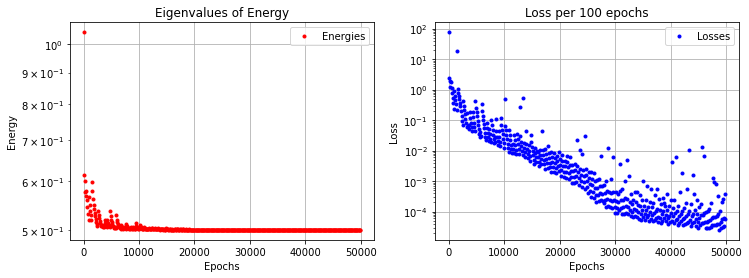

In [8]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, 1+Es, "r.", label="Energies")
plt.title("Eigenvalues of Energy")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.grid()
plt.legend(loc="best")
plt.subplot(122)
plt.plot(epochs, lss, "b.", label="Losses")
plt.title("Loss per 100 epochs")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="best")
plt.show()

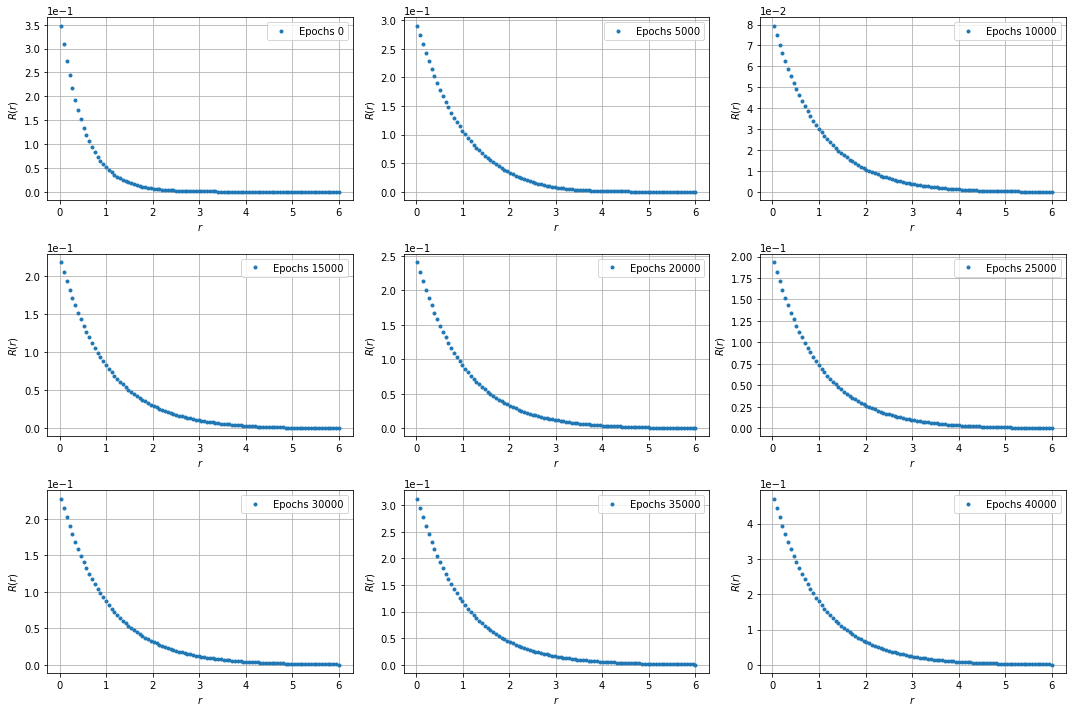

In [9]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]
fig, axs = plt.subplots(3,3,figsize=(15,10))

fil = 0
col = 0
for i in range(0,9):
    yy = Phis_t[50*i]
    yy = yy.reshape((200,1))
    axs[fil,col].plot(rr[100:], np.divide(yy[100:], rr[100:]), ".", label=f"Epochs {epochs[50*i]}")
    axs[fil,col].set_xlabel("$r$")
    axs[fil,col].set_ylabel("$R(r)$")
    axs[fil,col].legend(loc="best")
    axs[fil,col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[fil,col].grid()
    if col == 2:
       col = 0
       fil = fil+1
    else:
       col = col+1
plt.tight_layout()
plt.show()  

In [10]:
Es

array([ 0.04617826, -0.38590747, -0.4001501 , -0.4228043 , -0.4319999 ,
       -0.4206954 , -0.4399324 , -0.45553818, -0.46827433, -0.48007116,
       -0.43391883, -0.45110443, -0.4623204 , -0.47176492, -0.48096117,
       -0.40238836, -0.42183557, -0.43862066, -0.4505797 , -0.45970193,
       -0.46721503, -0.47381923, -0.4798737 , -0.48528805, -0.48943195,
       -0.4921634 , -0.46394107, -0.4711929 , -0.4777437 , -0.48316526,
       -0.48751453, -0.49072155, -0.49294528, -0.4902682 , -0.4925689 ,
       -0.49412373, -0.4920078 , -0.4940024 , -0.48182568, -0.4866401 ,
       -0.49050802, -0.4931114 , -0.49480835, -0.4808743 , -0.48635566,
       -0.49033952, -0.4930776 , -0.494868  , -0.46240216, -0.47416952,
       -0.48092714, -0.48565805, -0.48923305, -0.49200377, -0.49410045,
       -0.49558762, -0.49658132, -0.49490553, -0.49622256, -0.47058845,
       -0.48007488, -0.48514104, -0.48871586, -0.4914649 , -0.49363717,
       -0.4952945 , -0.4964631 , -0.49723974, -0.49105427, -0.49

In [11]:
np.mean(np.squeeze(Es))

-0.49465823

In [12]:
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0

Phi_0 = torch.Tensor(Phis_t[-1].reshape((200,1)))
V = lambda r: -(Z*e**2)/r
Phi_t_1 = lambda r: Phi_t(r) - Phi_0*torch.trapezoid(Phi_0[100:]*Phi_t(r)[100:], r[100:],dim=0)

In [13]:
def loss_fn_1(r):
    r.requires_grad = True
    
    Phi = Phi_t_1(r)
    Phi_t_r = torch.autograd.grad(Phi, r, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*Phi
    
    prom = Phi.size()[0]
    
    norm = torch.trapezoid(Phi[100:]**2,r[100:],dim=0) # integral over r=-6 to 6
    
    global E
    E = torch.trapezoid(Phi[100:]*H_Phi[100:],r[100:],dim=0)/norm 
    
    
    return (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/(2*norm) #multiply by m to avoit division by m in the mean function of torh 

In [14]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epoch = 50
lr = 2e-2
Phis_t_1 = []
Es_1 = []
lss_1 = []
epochs_1 = []


model_1 = NeuralNetwork().to(device)
initialize_weights(model_1)
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
for t in range(epoch):
    loss_1 = loss_fn_1(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_1}")
    training(R_train, loss_fn_1, optimizer)
    if t%100 == 0:
        Phis_t_1.append(Phi_t_1(R_train).detach().numpy())
        Es_1.append(E.detach().numpy())
        lss_1.append(loss_1.detach().numpy())
        epochs_1.append(t)
Es_1 = np.squeeze(Es_1)
lss_1 = np.squeeze(lss_1)
Phis_t_1 = np.squeeze(Phis_t_1)
print("Done!")

Epoch 1
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([3.3067e+08], grad_fn=<DivBackward0>)
E

/tmp/ipykernel_67503/1047098892.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


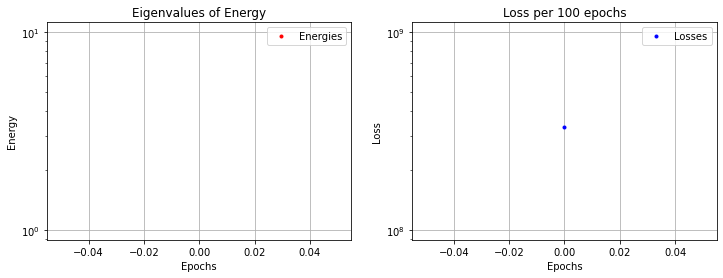

In [15]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
plt.plot(epochs_1, 1+Es_1, "r.", label="Energies")
plt.title("Eigenvalues of Energy")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.grid()
plt.legend(loc="best")
plt.subplot(122)
plt.plot(epochs_1, lss_1, "b.", label="Losses")
plt.title("Loss per 100 epochs")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="best")
plt.show()

In [16]:
Es_1

array(-1011.73895, dtype=float32)